In [1]:
# Cell 1:
!pip install --upgrade --force-reinstall numpy scipy scikit-learn scikit-image
!pip install --upgrade pandas matplotlib seaborn opencv-python-headless albumentations
!pip install --upgrade xgboost imbalanced-learn

  Using cached numpy-2.3.4-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.16.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached scikit_learn-1.7.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached scikit_image-0.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached pillow-12.0.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.8 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached tifffile-2025.10.16-py3-none-any.whl.metadata (31 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Usin

Using device: cuda ⚙️
--- Loading and merging initial data ---
Loaded 6702 total valid image-mask pairs with metadata.

--- Loading segmentation models ---
All segmentation models loaded successfully. ✅

--- Generating predictions and loading image data for 6702 samples ---


Processing images and masks: 100%|██████████| 210/210 [06:50<00:00,  1.95s/it]



--- Creating final DataFrame with image arrays ---
Saving DataFrame with image arrays to: /kaggle/working/cirrhosis_image_data.pkl
DataFrame saved successfully.

--- Verifying saved data and visualizing a few samples ---
Successfully loaded 6702 rows from pickle file.
Columns: Index(['ID', 'radiological_evaluation', 'split', 'original_image',
       'ground_truth_mask', 'predicted_mask'],
      dtype='object')


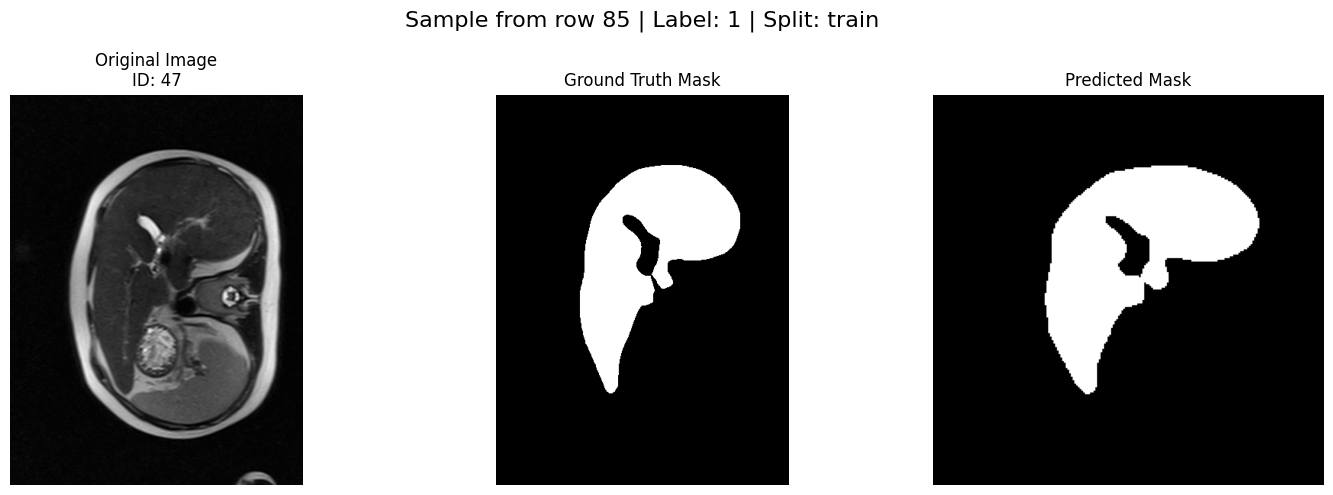

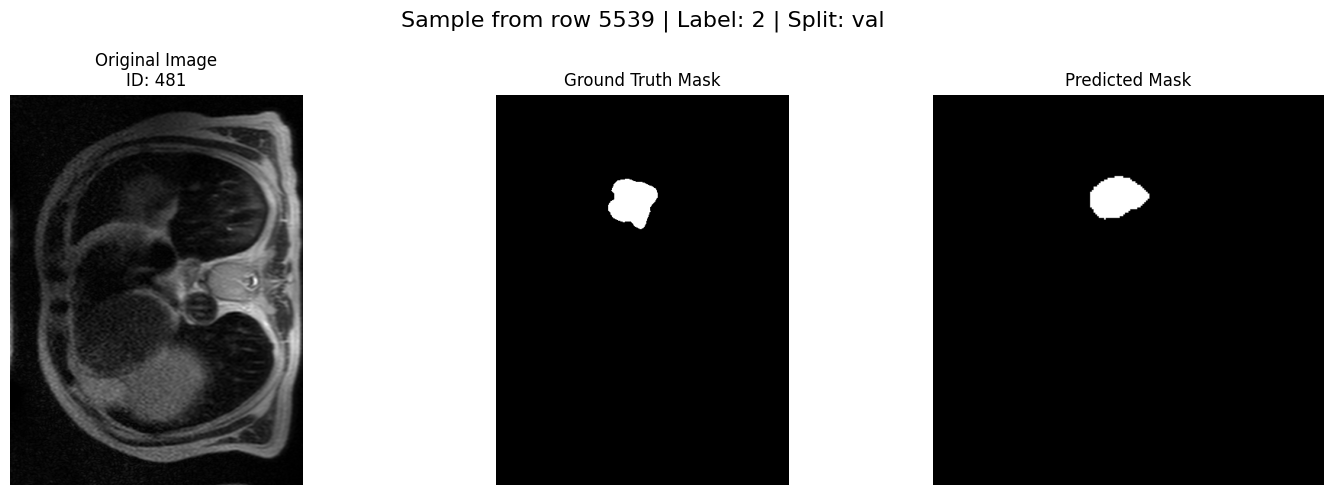

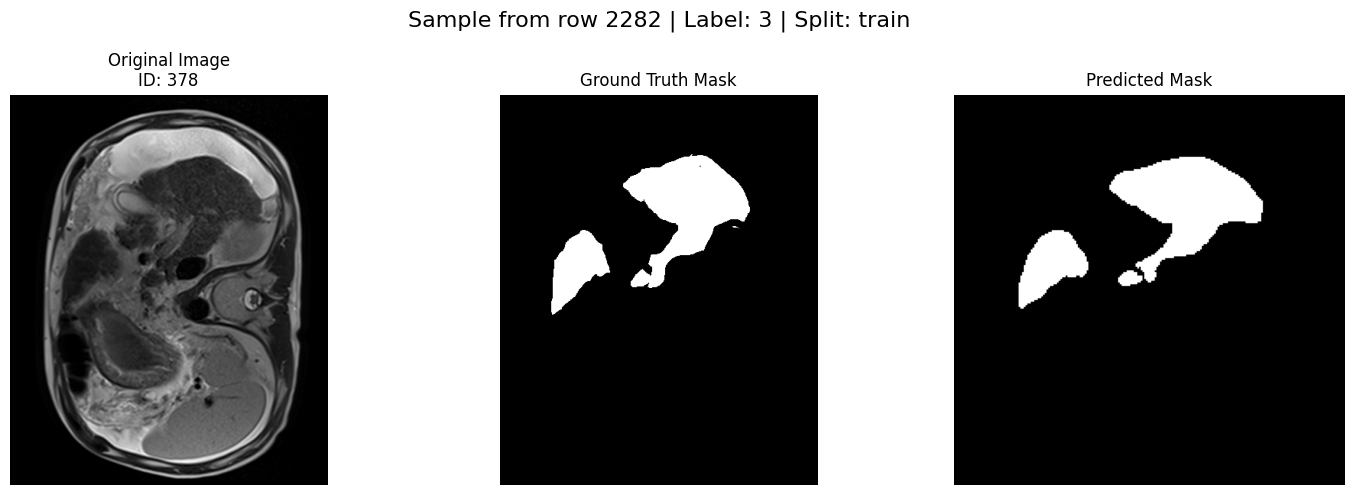

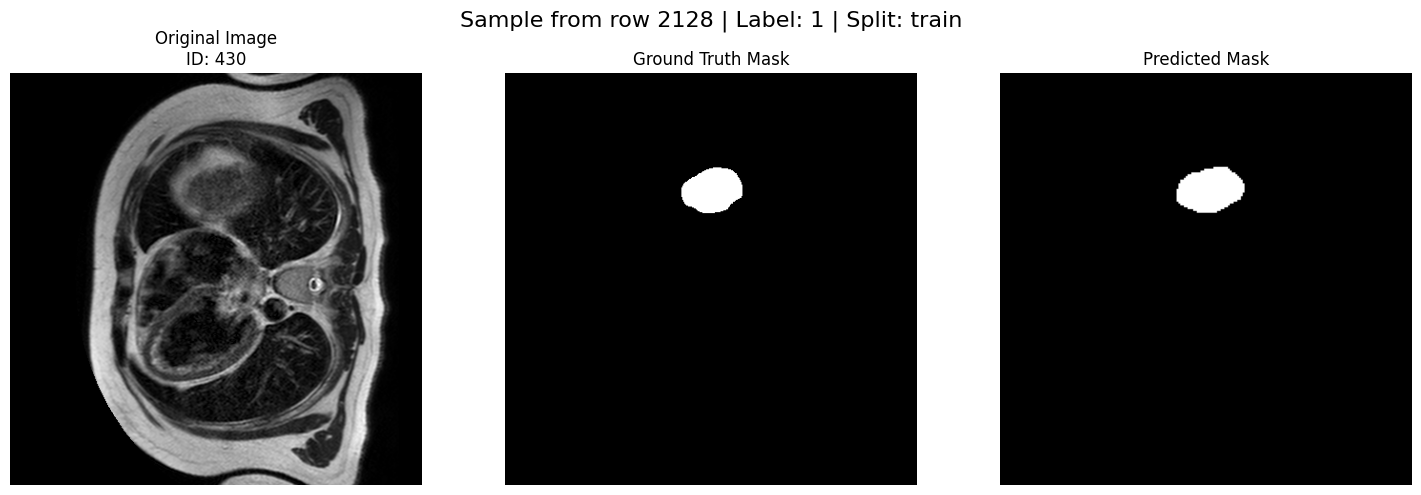

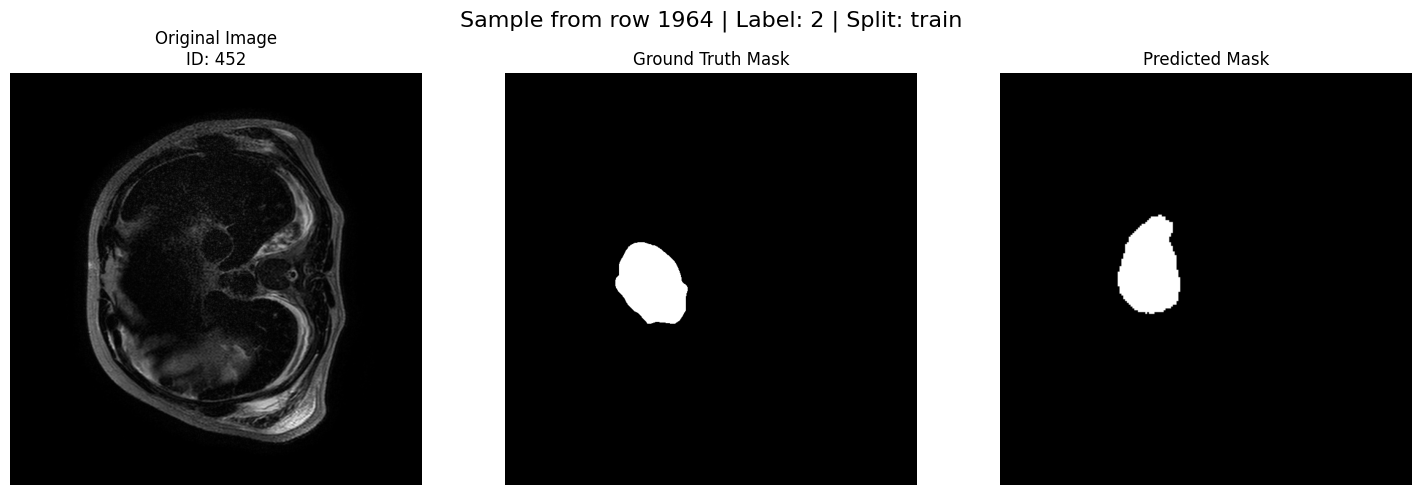


--- Script Finished ---


In [2]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# --- 1. CONFIGURATION ---
# Kaggle environment theke input path-gulo
MODEL1_PATH = '/kaggle/input/ourensemble/model1/best_segmentation_model1.pth'
MODEL2_PATH = '/kaggle/input/ourensemble/model1/best_transunetpp_model.pth'
MODEL3_PATH = '/kaggle/input/model3v/best_segmentation_model3.pth'
METADATA_PATH = '/kaggle/input/t2metadataaa2/T2_age_gender_evaluation.csv'
BASE_DATA_DIR = '/kaggle/input/dataa2/Cirrhosis_T2_2D/'

# --- <<< NEW OUTPUT PATH >>> ---
# Amra final DataFrame-take ekta single Pickle file hishebe save korbo
OUTPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model settings
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- 2. MODEL ARCHITECTURE DEFINITIONS (Apnar script theke copy kora) ---
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True))
    def forward(self, x):
        return self.conv(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x, skip_connection):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip_connection], dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class UNetWithResNet50Encoder(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base_model = models.resnet50(weights=None)
        base_layers = list(base_model.children())
        self.encoder0, self.encoder1 = nn.Sequential(*base_layers[:3]), nn.Sequential(*base_layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = base_layers[5], base_layers[6], base_layers[7]
        self.decoder3 = DecoderBlock(2048, 1024, 512)
        self.decoder2 = DecoderBlock(512, 512, 256)
        self.decoder1 = DecoderBlock(256, 256, 128)
        self.decoder0 = DecoderBlock(128, 64, 64)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x):
        e0 = self.encoder0(x); e1 = self.encoder1(e0); e2 = self.encoder2(e1); e3 = self.encoder3(e2); e4 = self.encoder4(e3)
        d3 = self.decoder3(e4, e3); d2 = self.decoder2(d3, e2); d1 = self.decoder1(d2, e1); d0 = self.decoder0(d1, e0)
        out = F.interpolate(d0, scale_factor=2, mode='bilinear', align_corners=True)
        return self.final_conv(out)

class TransUNetPP(nn.Module):
    def __init__(self, n_classes=1, img_dim=224, vit_dim=768, vit_depth=12, vit_heads=12):
        super().__init__()
        base_model = models.resnet50(weights=None)
        base_layers = list(base_model.children())
        self.encoder0, self.encoder1 = nn.Sequential(*base_layers[:3]), nn.Sequential(*base_layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = base_layers[5], base_layers[6], base_layers[7]
        num_patches, self.patch_dim = (img_dim // 32) ** 2, 2048
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, vit_dim))
        self.patch_to_embedding = nn.Linear(self.patch_dim, vit_dim)
        transformer_layer = nn.TransformerEncoderLayer(d_model=vit_dim, nhead=vit_heads, dim_feedforward=vit_dim * 4, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=vit_depth)
        self.transformer_output_to_conv = nn.Sequential(nn.Linear(vit_dim, self.patch_dim), nn.LayerNorm(self.patch_dim))
        d_ch = {'d0': 64, 'd1': 128, 'd2': 256, 'd3': 512, 'd4': 1024}
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.X_0_0 = ConvBlock(64, d_ch['d0']); self.X_1_0 = ConvBlock(256, d_ch['d1']); self.X_0_1 = ConvBlock(d_ch['d0'] + d_ch['d1'], d_ch['d0'])
        self.X_2_0 = ConvBlock(512, d_ch['d2']); self.X_1_1 = ConvBlock(d_ch['d1'] + d_ch['d2'], d_ch['d1']); self.X_0_2 = ConvBlock(d_ch['d0'] * 2 + d_ch['d1'], d_ch['d0'])
        self.X_3_0 = ConvBlock(1024, d_ch['d3']); self.X_2_1 = ConvBlock(d_ch['d2'] + d_ch['d3'], d_ch['d2']); self.X_1_2 = ConvBlock(d_ch['d1'] * 2 + d_ch['d2'], d_ch['d1']); self.X_0_3 = ConvBlock(d_ch['d0'] * 3 + d_ch['d1'], d_ch['d0'])
        self.X_4_0 = ConvBlock(2048, d_ch['d4']); self.X_3_1 = ConvBlock(d_ch['d3'] + d_ch['d4'], d_ch['d3']); self.X_2_2 = ConvBlock(d_ch['d2'] * 2 + d_ch['d3'], d_ch['d2']); self.X_1_3 = ConvBlock(d_ch['d1'] * 3 + d_ch['d2'], d_ch['d1']); self.X_0_4 = ConvBlock(d_ch['d0'] * 4 + d_ch['d1'], d_ch['d0'])
        self.final_conv = nn.Conv2d(d_ch['d0'], n_classes, kernel_size=1)
    def forward(self, x):
        e0 = self.encoder0(x); e1 = self.encoder1(e0); e2 = self.encoder2(e1); e3 = self.encoder3(e2); e4 = self.encoder4(e3)
        bs, _, h, w = e4.shape; trans_in = self.patch_to_embedding(e4.flatten(2).transpose(1, 2)) + self.pos_embedding
        trans_out = self.transformer_output_to_conv(self.transformer_encoder(trans_in)).transpose(1, 2).view(bs, self.patch_dim, h, w)
        x0_0=self.X_0_0(e0); x1_0=self.X_1_0(e1); x0_1=self.X_0_1(torch.cat([x0_0,self.upsample(x1_0)],1)); x2_0=self.X_2_0(e2); x1_1=self.X_1_1(torch.cat([x1_0,self.upsample(x2_0)],1)); x0_2=self.X_0_2(torch.cat([x0_0,x0_1,self.upsample(x1_1)],1))
        x3_0=self.X_3_0(e3); x2_1=self.X_2_1(torch.cat([x2_0,self.upsample(x3_0)],1)); x1_2=self.X_1_2(torch.cat([x1_0,x1_1,self.upsample(x2_1)],1)); x0_3=self.X_0_3(torch.cat([x0_0,x0_1,x0_2,self.upsample(x1_2)],1))
        x4_0=self.X_4_0(trans_out); x3_1=self.X_3_1(torch.cat([x3_0,self.upsample(x4_0)],1)); x2_2=self.X_2_2(torch.cat([x2_0,x2_1,self.upsample(x3_1)],1)); x1_3=self.X_1_3(torch.cat([x1_0,x1_1,x1_2,self.upsample(x2_2)],1)); x0_4=self.X_0_4(torch.cat([x0_0,x0_1,x0_2,x0_3,self.upsample(x1_3)],1))
        return F.interpolate(self.final_conv(x0_4), scale_factor=2, mode='bilinear', align_corners=True)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__(); self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.BatchNorm2d(F_int)); self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.BatchNorm2d(F_int)); self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.BatchNorm2d(1), nn.Sigmoid()); self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        psi = self.relu(self.W_g(g) + self.W_x(x)); return x * self.psi(psi)

class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__(); base = models.resnet50(weights=None); layers = list(base.children()); self.encoder0, self.encoder1 = nn.Sequential(*layers[:3]), nn.Sequential(*layers[3:5]); self.encoder2, self.encoder3, self.encoder4 = layers[5], layers[6], layers[7]
        self.upconv3 = nn.ConvTranspose2d(2048, 1024, 2, 2); self.attn3 = AttentionGate(1024, 1024, 512); self.dec_conv3 = ConvBlock(2048, 1024); self.upconv2 = nn.ConvTranspose2d(1024, 512, 2, 2); self.attn2 = AttentionGate(512, 512, 256); self.dec_conv2 = ConvBlock(1024, 512)
        self.upconv1 = nn.ConvTranspose2d(512, 256, 2, 2); self.attn1 = AttentionGate(256, 256, 128); self.dec_conv1 = ConvBlock(512, 256); self.upconv0 = nn.ConvTranspose2d(256, 64, 2, 2); self.attn0 = AttentionGate(64, 64, 32); self.dec_conv0 = ConvBlock(128, 64)
        self.final_up = nn.ConvTranspose2d(64, 32, 2, 2); self.final_conv = nn.Conv2d(32, n_classes, 1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3); d3=self.upconv3(e4); x3=self.attn3(d3,e3); d3=self.dec_conv3(torch.cat((x3,d3),1)); d2=self.upconv2(d3); x2=self.attn2(d2,e2); d2=self.dec_conv2(torch.cat((x2,d2),1))
        d1=self.upconv1(d2); x1=self.attn1(d1,e1); d1=self.dec_conv1(torch.cat((x1,d1),1)); d0=self.upconv0(d1); x0=self.attn0(d0,e0); d0=self.dec_conv0(torch.cat((x0,d0),1)); return self.final_conv(self.final_up(d0))

# --- 3. DATASET FOR INFERENCE ---
# Ei dataset ekhon image ebong ground truth mask er path load korbe
class FullDataDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe
        self.transform = transforms.Compose([
            transforms.Resize(IMAGE_SIZE, transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_file_path']
        mask_path = row['mask_file_path']
        
        image_pil = Image.open(image_path).convert('RGB')
        
        # Amra path-gulo pass korbo jate result-gulo shothikvabe associate kora jay
        return self.transform(image_pil), image_path, mask_path

# --- 4. MAIN SCRIPT ---
def main():
    # --- Data Load and Merge ---
    print("--- Loading and merging initial data ---")
    try:
        metadata_df = pd.read_csv(METADATA_PATH)
        metadata_df.rename(columns={'Patient ID': 'ID', 'Radiological Evaluation': 'radiological_evaluation'}, inplace=True)
        metadata_df.dropna(subset=['radiological_evaluation'], inplace=True)
        metadata_df['radiological_evaluation'] = metadata_df['radiological_evaluation'].astype(int)
        metadata_df['ID'] = metadata_df['ID'].astype(str)
        
        def create_dataframe_from_ids(directory, dir_name):
            data = []
            if not os.path.exists(directory):
                return pd.DataFrame(data)
            for folder_name in os.listdir(directory):
                folder_path = os.path.join(directory, folder_name)
                images_dir = os.path.join(folder_path, 'images')
                if os.path.exists(images_dir):
                    for image_file in os.listdir(images_dir):
                        image_path = os.path.join(images_dir, image_file)
                        mask_path = os.path.join(folder_path, 'masks', image_file)
                        if os.path.exists(mask_path):
                            data.append((folder_name, image_path, mask_path, dir_name))
            return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path', 'split'])
        
        train_df = create_dataframe_from_ids(os.path.join(BASE_DATA_DIR, 'train'), 'train')
        val_df = create_dataframe_from_ids(os.path.join(BASE_DATA_DIR, 'valid'), 'val')
        test_df = create_dataframe_from_ids(os.path.join(BASE_DATA_DIR, 'test'), 'test')

        full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
        final_df = pd.merge(full_df, metadata_df[['ID', 'radiological_evaluation']], on='ID', how='inner')
        
        if final_df.empty:
            raise ValueError("The final merged dataframe is empty. Check patient IDs and file paths.")
        print(f"Loaded {len(final_df)} total valid image-mask pairs with metadata.")
        
    except Exception as e:
        print(f"Error during data loading: {e}")
        return

    # --- Segmentation Model Load ---
    print("\n--- Loading segmentation models ---")
    try:
        model1 = UNetWithResNet50Encoder(n_classes=1).to(device)
        model1.load_state_dict(torch.load(MODEL1_PATH, map_location=device))
        model1.eval()

        model2 = TransUNetPP(n_classes=1).to(device)
        model2.load_state_dict(torch.load(MODEL2_PATH, map_location=device))
        model2.eval()

        model3 = AttentionUNet(n_classes=1).to(device)
        model3.load_state_dict(torch.load(MODEL3_PATH, map_location=device))
        model3.eval()
        print("All segmentation models loaded successfully. ✅")
    except Exception as e:
        print(f"Error loading models: {e}")
        return

    # --- Predicted Mask Generate kora ebong Data List toiri kora ---
    print(f"\n--- Generating predictions and loading image data for {len(final_df)} samples ---")
    
    dataset = FullDataDataset(final_df)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    processed_data = [] # Ei list amader notun DataFrame-er jonno dictionary-gulo dharon korbe
    
    with torch.no_grad():
        for images_tensor, image_paths, mask_paths in tqdm(loader, desc="Processing images and masks"):
            images_tensor = images_tensor.to(device)
            p1 = model1(images_tensor)
            p2 = model2(images_tensor)
            p3 = model3(images_tensor)
            
            ensembled_preds = torch.sigmoid(torch.mean(torch.stack([p1, p2, p3]), dim=0))
            binary_masks_np = (ensembled_preds > 0.5).cpu().numpy().astype(np.uint8)

            # Batch-er prottekta item process kora
            for i in range(len(image_paths)):
                original_img_path = image_paths[i]
                gt_mask_path = mask_paths[i]
                
                # Original image ebong ground truth mask numpy array hishebe load kora
                original_img_np = cv2.imread(original_img_path)
                original_img_np = cv2.cvtColor(original_img_np, cv2.COLOR_BGR2RGB) # RGB format-e rakha
                
                gt_mask_np = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
                
                # Ei image-er jonno predicted mask-ta neya
                predicted_mask_np = binary_masks_np[i].squeeze()
                
                # Metadata paowar jonno original dataframe theke corresponding row khuje ber kora
                row = final_df[final_df['image_file_path'] == original_img_path].iloc[0]
                
                # Amader list-e shob data shoho ekta dictionary append kora
                processed_data.append({
                    'ID': row['ID'],
                    'radiological_evaluation': row['radiological_evaluation'],
                    'split': row['split'],
                    'original_image': original_img_np,
                    'ground_truth_mask': gt_mask_np,
                    'predicted_mask': predicted_mask_np
                })

    # --- Final DataFrame toiri kora ---
    print("\n--- Creating final DataFrame with image arrays ---")
    final_image_df = pd.DataFrame(processed_data)
    
    # --- Pickle File-e Save kora ---
    print(f"Saving DataFrame with image arrays to: {OUTPUT_PICKLE_PATH}")
    final_image_df.to_pickle(OUTPUT_PICKLE_PATH)
    print("DataFrame saved successfully.")

    # --- Verification and Visualization ---
    print("\n--- Verifying saved data and visualizing a few samples ---")
    
    # Verify korar jonno data abar load kora
    loaded_df = pd.read_pickle(OUTPUT_PICKLE_PATH)
    print(f"Successfully loaded {len(loaded_df)} rows from pickle file.")
    print("Columns:", loaded_df.columns)

    # Display korar jonno 5-ta random sample neya
    num_samples_to_show = 5
    sample_df = loaded_df.sample(n=min(num_samples_to_show, len(loaded_df)))

    for index, row in sample_df.iterrows():
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # 1. Original Image (ekhon NumPy array)
        axes[0].imshow(row['original_image'])
        axes[0].set_title(f"Original Image\nID: {row['ID']}")
        axes[0].axis('off')
        
        # 2. Ground Truth Mask (ekhon NumPy array)
        axes[1].imshow(row['ground_truth_mask'], cmap='gray')
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis('off')
        
        # 3. Predicted Mask (ekhon NumPy array)
        axes[2].imshow(row['predicted_mask'], cmap='gray')
        axes[2].set_title("Predicted Mask")
        axes[2].axis('off')
        
        plt.suptitle(f"Sample from row {index} | Label: {row['radiological_evaluation']} | Split: {row['split']}", fontsize=16)
        plt.tight_layout()
        plt.show()

    print("\n--- Script Finished ---")


if __name__ == '__main__':
    main()



In [3]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda ⚙️

--- Loading Pre-processed Data from Pickle File ---
Loaded data: 5364 train, 674 val, 664 test.

Setting up data balancing for training...
Class weights for loss function: tensor([0.8206, 0.8642, 1.6022], device='cuda:0')


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_112/2055210528.py:84: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 60.0), p=0.5),
/tmp/ipykernel_112/2055210528.py:85: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 204MB/s]
/tmp/ipykernel_112/2055210528.py:153: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  


--- Training Expert: Global_ResNet34 ---


Train Ep 1:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_112/2055210528.py:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val Ep 1:   0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_112/2055210528.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val Ep 1: 100%|██████████| 11/11 [00:01<00:00,  8.27it/s]


Epoch 1 Val Acc: 0.7270
  -> New best model saved!


Val Ep 2: 100%|██████████| 11/11 [00:01<00:00,  8.73it/s]


Epoch 2 Val Acc: 0.7226


Val Ep 3: 100%|██████████| 11/11 [00:01<00:00,  8.79it/s]


Epoch 3 Val Acc: 0.7418
  -> New best model saved!


Val Ep 4: 100%|██████████| 11/11 [00:01<00:00,  8.57it/s]


Epoch 4 Val Acc: 0.7522
  -> New best model saved!


Val Ep 5: 100%|██████████| 11/11 [00:01<00:00,  8.71it/s]


Epoch 5 Val Acc: 0.7359


Val Ep 6: 100%|██████████| 11/11 [00:01<00:00,  8.66it/s]


Epoch 6 Val Acc: 0.7552
  -> New best model saved!


Val Ep 7: 100%|██████████| 11/11 [00:01<00:00,  8.69it/s]


Epoch 7 Val Acc: 0.7478


Val Ep 8: 100%|██████████| 11/11 [00:01<00:00,  8.77it/s]


Epoch 8 Val Acc: 0.7166


Val Ep 9: 100%|██████████| 11/11 [00:01<00:00,  8.13it/s]


Epoch 9 Val Acc: 0.7418


Val Ep 10: 100%|██████████| 11/11 [00:01<00:00,  8.95it/s]


Epoch 10 Val Acc: 0.7285


Val Ep 11: 100%|██████████| 11/11 [00:01<00:00,  8.74it/s]


Epoch 11 Val Acc: 0.7448


Val Ep 12: 100%|██████████| 11/11 [00:01<00:00,  8.68it/s]


Epoch 12 Val Acc: 0.7033


Val Ep 13: 100%|██████████| 11/11 [00:01<00:00,  8.60it/s]


Epoch 13 Val Acc: 0.7374
  -> Early stopping.


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 161MB/s]



--- Training Expert: Local_DenseNet121 ---


Val Ep 1: 100%|██████████| 11/11 [00:02<00:00,  4.97it/s]


Epoch 1 Val Acc: 0.5386
  -> New best model saved!


Val Ep 2: 100%|██████████| 11/11 [00:01<00:00,  6.18it/s]


Epoch 2 Val Acc: 0.3427


Val Ep 3: 100%|██████████| 11/11 [00:01<00:00,  6.13it/s]


Epoch 3 Val Acc: 0.4169


Val Ep 4: 100%|██████████| 11/11 [00:01<00:00,  6.14it/s]


Epoch 4 Val Acc: 0.4570


Val Ep 5: 100%|██████████| 11/11 [00:01<00:00,  6.19it/s]


Epoch 5 Val Acc: 0.5341


Val Ep 6: 100%|██████████| 11/11 [00:01<00:00,  6.24it/s]


Epoch 6 Val Acc: 0.5119


Val Ep 7: 100%|██████████| 11/11 [00:01<00:00,  6.22it/s]


Epoch 7 Val Acc: 0.5134


Val Ep 8: 100%|██████████| 11/11 [00:01<00:00,  6.14it/s]


Epoch 8 Val Acc: 0.4955
  -> Early stopping.


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]



--- Training Expert: Mask_ResNet50 ---


Train Ep 1:   0%|          | 0/167 [00:00<?, ?it/s]


!!!!!!!! FAILED to train Expert C (Mask_ResNet50): Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_112/2055210528.py", line 140, in __getitem__
    stacked = np.stack([gt_mask, pred_mask], axis=-1)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dis

Getting Predictions:   0%|          | 0/84 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c1ee80e8e0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c1ee80e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1564, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.11/threading.py", line 1116, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c1ee80e8e0>
    Traceback (most recent call last):
  File "/usr/local/lib/

Getting predictions from: Local_DenseNet121


Getting Predictions: 100%|██████████| 11/11 [00:02<00:00,  5.19it/s]

Meta-dataset created. Train shape: (5364, 6)

--- Training Manager Model (XGBoost) ---
[0]	validation_0-mlogloss:1.05934



/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [10:13:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[80]	validation_0-mlogloss:0.82790

--- Manager Training Complete ---

--- FINAL STACKED ENSEMBLE TEST EVALUATION ---

--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        Mild       0.86      0.70      0.77       350
    Moderate       0.13      0.21      0.16       133
      Severe       0.56      0.53      0.54       181

    accuracy                           0.55       664
   macro avg       0.52      0.48      0.49       664
weighted avg       0.63      0.55      0.59       664


--- Individual Class Metrics ---
--- Class: Mild (Original Label: 1) ---
  Accuracy (Recall): 0.6971
  Precision:         0.8592
  F1-Score:          0.7697
--- Class: Moderate (Original Label: 2) ---
  Accuracy (Recall): 0.2105
  Precision:         0.1346
  F1-Score:          0.1642
--- Class: Severe (Original Label: 3) ---
  Accuracy (Recall): 0.5304
  Precision:         0.5581
  F1-Score:          0.5439

--- Confusion Matrix ---


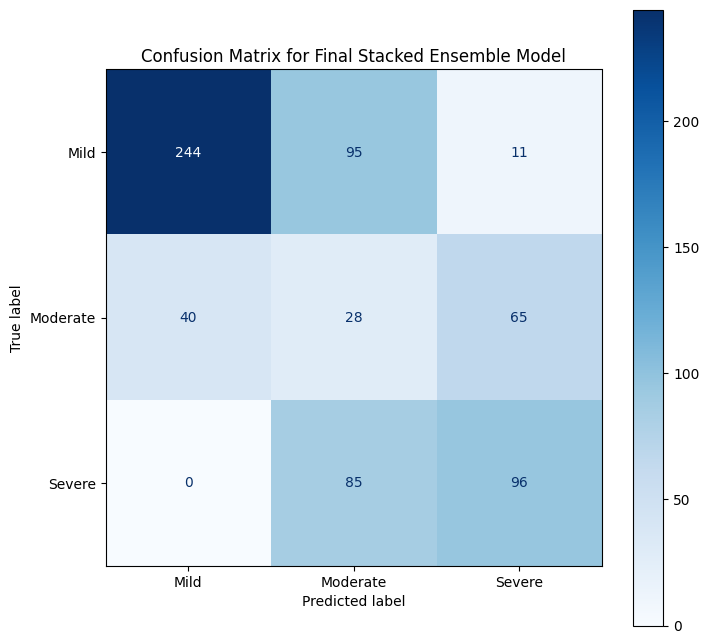

In [4]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
from torchvision import models
import xgboost as xgb
import timm

# --- 1. CONFIGURATION ---
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 3
BATCH_SIZE = 32
NUM_EPOCHS_CNN = 25
PATIENCE_CNN = 7
INITIAL_LR = 1e-4

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- 3. DATA LOADING & BALANCING SETUP ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"Proyojoniyo input file-ti paowa jayni: {INPUT_PICKLE_PATH}")
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['radiological_evaluation'].value_counts().sort_index().to_dict()
    main_task_labels_for_weighting = (train_df['radiological_evaluation'] - 1).values
    
    sample_weights_dict = {
        1: len(train_df) / class_counts.get(1, 1e-6),
        2: len(train_df) / class_counts.get(2, 1e-6),
        3: len(train_df) / class_counts.get(3, 1e-6)
    }
    sample_weights = np.array([sample_weights_dict[t] for t in train_df['radiological_evaluation'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    
    class_weights_loss = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=main_task_labels_for_weighting), dtype=torch.float).to(device)
    print(f"Class weights for loss function: {class_weights_loss}")
    
    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASETS AND AUGMENTATIONS ---
if data_loaded:
    # Augmentations for RGB images
    strong_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
        A.GaussNoise(var_limit=(10.0, 60.0), p=0.5),
        A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    # Augmentations for 2-channel mask images (geometric only)
    mask_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75),
        ToTensorV2()
    ])

    # --- Datasets for each Expert ---
    # Expert A: Global Context (Full Image)
    class GlobalDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            image = self.transform(image=row['original_image'])['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

    # Expert B: Local Texture (Cropped Image)
    class LocalDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            image, mask = row['original_image'], row['predicted_mask']
            crop = image
            try:
                if mask is not None and mask.max() > 0:
                    bbox = find_objects(mask)
                    if bbox:
                        sy, sx = bbox[0]
                        if sy.stop > sy.start and sx.stop > sx.start: crop = image[sy.start:sy.stop, sx.start:sx.stop]
            except: pass
            image = self.transform(image=crop)['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

    # Expert C: Shape & Error Analysis (Mask Comparison)
    class MaskDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            gt_mask = (row['ground_truth_mask'] > 0).astype(np.uint8) * 255
            pred_mask = (row['predicted_mask'] > 0).astype(np.uint8) * 255
            stacked = np.stack([gt_mask, pred_mask], axis=-1)
            image = self.transform(image=stacked)['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

# --- 5. HELPER FUNCTIONS FOR TRAINING & PREDICTION ---
def train_expert_model(model, model_name, train_loader, val_loader):
    print(f"\n--- Training Expert: {model_name} ---")
    criterion = nn.CrossEntropyLoss(weight=class_weights_loss, label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-6)
    best_acc = 0.0
    epochs_no_improve = 0
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS_CNN):
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Train Ep {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        scheduler.step()

        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Val Ep {epoch+1}"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Epoch {epoch+1} Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'best_expert_{model_name}.pth')
            epochs_no_improve = 0
            print(f"  -> New best model saved!")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= PATIENCE_CNN:
            print("  -> Early stopping.")
            break
    
    model.load_state_dict(torch.load(f'best_expert_{model_name}.pth'))
    return model

def get_expert_predictions(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for images, _ in tqdm(loader, desc="Getting Predictions"):
            images = images.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
            preds.append(F.softmax(outputs, dim=1).cpu().numpy())
    return np.concatenate(preds, axis=0)

# --- 6. PHASE 1: Train All Expert Models ---
if data_loaded:
    successful_experts = {}
    
    # --- Expert A: Global (ResNet34) ---
    try:
        train_loader_global = DataLoader(GlobalDataset(train_df, strong_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_global = DataLoader(GlobalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_global = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        model_global.fc = nn.Linear(model_global.fc.in_features, NUM_CLASSES)
        model_global = train_expert_model(model_global.to(device), "Global_ResNet34", train_loader_global, val_loader_global)
        successful_experts['global'] = model_global
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert A (Global_ResNet34): {e} !!!!!!!!")

    # --- Expert B: Local (DenseNet121) ---
    try:
        train_loader_local = DataLoader(LocalDataset(train_df, strong_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_local = DataLoader(LocalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_local = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        model_local.classifier = nn.Linear(model_local.classifier.in_features, NUM_CLASSES)
        model_local = train_expert_model(model_local.to(device), "Local_DenseNet121", train_loader_local, val_loader_local)
        successful_experts['local'] = model_local
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert B (Local_DenseNet121): {e} !!!!!!!!")

    # --- Expert C: Mask Comparison (ResNet50) ---
    try:
        train_loader_mask = DataLoader(MaskDataset(train_df, mask_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_mask = DataLoader(MaskDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_mask = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        orig_weights = model_mask.conv1.weight.clone()
        new_weights = orig_weights.sum(dim=1, keepdim=True).repeat(1,2,1,1) / 3
        model_mask.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model_mask.conv1.weight.data = new_weights
        model_mask.fc = nn.Linear(model_mask.fc.in_features, NUM_CLASSES)
        model_mask = train_expert_model(model_mask.to(device), "Mask_ResNet50", train_loader_mask, val_loader_mask)
        successful_experts['mask'] = model_mask
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert C (Mask_ResNet50): {e} !!!!!!!!")
    
# --- 7. PHASE 2: Create Meta-Dataset and Train XGBoost ---
if 'successful_experts' in locals() and successful_experts:
    print("\n--- Creating Meta-Dataset from successfully trained experts ---")
    
    meta_features_train, meta_features_val, meta_features_test = [], [], []

    if 'global' in successful_experts:
        print("Getting predictions from: Global_ResNet34")
        train_loader_pred = DataLoader(GlobalDataset(train_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        val_loader_pred = DataLoader(GlobalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        test_loader_pred = DataLoader(GlobalDataset(test_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        meta_features_train.append(get_expert_predictions(successful_experts['global'], train_loader_pred))
        meta_features_val.append(get_expert_predictions(successful_experts['global'], val_loader_pred))
        meta_features_test.append(get_expert_predictions(successful_experts['global'], test_loader_pred))

    if 'local' in successful_experts:
        print("Getting predictions from: Local_DenseNet121")
        train_loader_pred = DataLoader(LocalDataset(train_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        val_loader_pred = DataLoader(LocalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        test_loader_pred = DataLoader(LocalDataset(test_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        meta_features_train.append(get_expert_predictions(successful_experts['local'], train_loader_pred))
        meta_features_val.append(get_expert_predictions(successful_experts['local'], val_loader_pred))
        meta_features_test.append(get_expert_predictions(successful_experts['local'], test_loader_pred))
        
    if 'mask' in successful_experts:
        print("Getting predictions from: Mask_ResNet50")
        train_loader_pred = DataLoader(MaskDataset(train_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        val_loader_pred = DataLoader(MaskDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        test_loader_pred = DataLoader(MaskDataset(test_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        meta_features_train.append(get_expert_predictions(successful_experts['mask'], train_loader_pred))
        meta_features_val.append(get_expert_predictions(successful_experts['mask'], val_loader_pred))
        meta_features_test.append(get_expert_predictions(successful_experts['mask'], test_loader_pred))

    # Combine predictions to form meta-dataset
    X_train_meta = np.hstack(meta_features_train)
    X_val_meta = np.hstack(meta_features_val)
    X_test_meta = np.hstack(meta_features_test)

    y_train_meta = (train_df['radiological_evaluation'] - 1).values
    y_val_meta = (val_df['radiological_evaluation'] - 1).values
    y_test_meta = (test_df['radiological_evaluation'] - 1).values
    
    print(f"Meta-dataset created. Train shape: {X_train_meta.shape}")

    # --- Train XGBoost Manager ---
    print("\n--- Training Manager Model (XGBoost) ---")
    from sklearn.utils.class_weight import compute_sample_weight
    sample_weights_xgb = compute_sample_weight(class_weight='balanced', y=y_train_meta)
    
    xgb_manager = xgb.XGBClassifier(
        objective='multi:softmax', num_class=NUM_CLASSES, use_label_encoder=False,
        eval_metric='mlogloss', n_estimators=500, learning_rate=0.05,
        max_depth=4, subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=50
    )

    xgb_manager.fit(X_train_meta, y_train_meta,
                    sample_weight=sample_weights_xgb,
                    eval_set=[(X_val_meta, y_val_meta)],
                    verbose=100)
    
    print("\n--- Manager Training Complete ---")

    # --- 8. FINAL EVALUATION ---
    print("\n" + "="*80)
    print("--- FINAL STACKED ENSEMBLE TEST EVALUATION ---")
    print("="*80)

    y_pred_meta = xgb_manager.predict(X_test_meta)
    
    print("\n--- FINAL CLASSIFICATION REPORT ---")
    report_dict = classification_report(y_test_meta, y_pred_meta, target_names=class_names, zero_division=0, output_dict=True)
    print(classification_report(y_test_meta, y_pred_meta, target_names=class_names, zero_division=0))
    
    print("\n--- Individual Class Metrics ---")
    for i, class_name in enumerate(class_names):
        metrics = report_dict.get(class_name, {})
        print(f"--- Class: {class_name} (Original Label: {i+1}) ---")
        print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
        print(f"  Precision:         {metrics.get('precision', 0):.4f}")
        print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test_meta, y_pred_meta, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Final Stacked Ensemble Model")
    plt.show()

else:
    print("\nNo expert models were trained successfully. Cannot proceed to stacking.")



Using device: cuda ⚙️
PyTorch version: 2.6.0+cu124

--- Loading Pre-processed Data from Pickle File ---
Loaded data: 5364 train, 674 val, 664 test.

Setting up data balancing for training...
WeightedRandomSampler created.
Main Task Loss Weights (for 0,1,2): tensor([0.8206, 0.8642, 1.6022], device='cuda:0')
Multi-Task Datasets (for original images) and DataLoaders are ready. 📊


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 218MB/s] 
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_112/4281224170.py:204: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Multi-Task VGG16 model created.

--- Starting Training ---


Epoch 1/50 (Train):   0%|          | 0/335 [00:00<?, ?it/s]/tmp/ipykernel_112/4281224170.py:217: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 (Val):   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_112/4281224170.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.69it/s]


Epoch 1 | Train Loss: 2.5866 | Val Acc: 0.7582
  -> ✅ New best model saved with validation accuracy: 0.7582


Epoch 2/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.84it/s]


Epoch 2 | Train Loss: 2.1053 | Val Acc: 0.7938
  -> ✅ New best model saved with validation accuracy: 0.7938


Epoch 3/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  9.01it/s]


Epoch 3 | Train Loss: 1.9007 | Val Acc: 0.7685
  -> ❌ No improvement for 1 epochs.


Epoch 4/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.93it/s]


Epoch 4 | Train Loss: 1.7910 | Val Acc: 0.7567
  -> ❌ No improvement for 2 epochs.


Epoch 5/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.79it/s]


Epoch 5 | Train Loss: 1.6280 | Val Acc: 0.7730
  -> ❌ No improvement for 3 epochs.


Epoch 6/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.87it/s]


Epoch 6 | Train Loss: 1.5290 | Val Acc: 0.7596
  -> ❌ No improvement for 4 epochs.


Epoch 7/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.70it/s]


Epoch 7 | Train Loss: 1.4593 | Val Acc: 0.7671
  -> ❌ No improvement for 5 epochs.


Epoch 8/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.85it/s]


Epoch 8 | Train Loss: 1.3716 | Val Acc: 0.7552
  -> ❌ No improvement for 6 epochs.


Epoch 9/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.95it/s]


Epoch 9 | Train Loss: 1.3314 | Val Acc: 0.7537
  -> ❌ No improvement for 7 epochs.


Epoch 10/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.93it/s]


Epoch 10 | Train Loss: 1.2768 | Val Acc: 0.7418
  -> ❌ No improvement for 8 epochs.


Epoch 11/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.88it/s]


Epoch 11 | Train Loss: 1.3710 | Val Acc: 0.7537
  -> ❌ No improvement for 9 epochs.


Epoch 12/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.91it/s]


Epoch 12 | Train Loss: 1.2817 | Val Acc: 0.7463
  -> ❌ No improvement for 10 epochs.

Early stopping triggered.

--- Training Finished ---

--- Evaluating Best Model on Test Set ---


Testing:   0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_112/4281224170.py:276: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Testing: 100%|██████████| 21/21 [00:02<00:00,  8.56it/s]



--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        Mild       0.86      0.63      0.73       350
    Moderate       0.11      0.17      0.13       133
      Severe       0.55      0.58      0.56       181

    accuracy                           0.53       664
   macro avg       0.51      0.46      0.48       664
weighted avg       0.63      0.53      0.56       664


--- Individual Class Metrics ---
--- Class: Mild (Original Label: 1) ---
  Accuracy (Recall): 0.6314
  Precision:         0.8633
  F1-Score:          0.7294
--- Class: Moderate (Original Label: 2) ---
  Accuracy (Recall): 0.1729
  Precision:         0.1060
  F1-Score:          0.1314
--- Class: Severe (Original Label: 3) ---
  Accuracy (Recall): 0.5801
  Precision:         0.5497
  F1-Score:          0.5645

--- Confusion Matrix ---


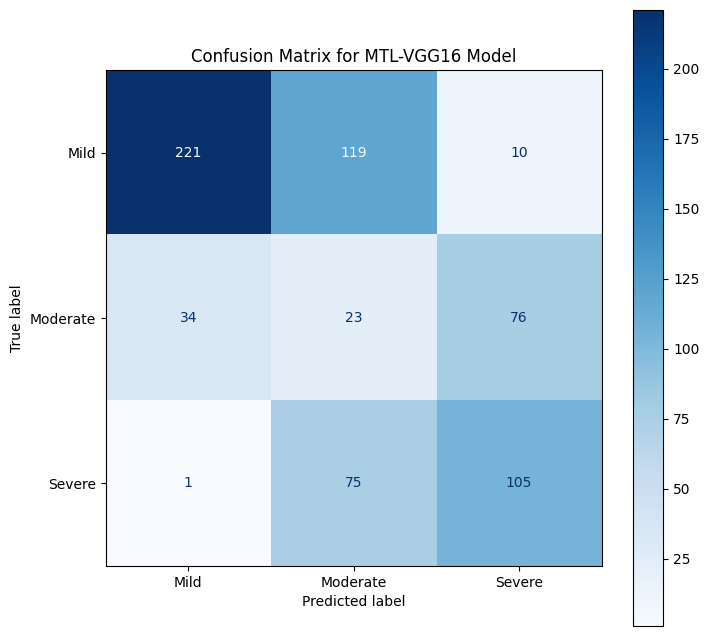

In [5]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import copy
import time
from torchvision import models

# --- 1. CONFIGURATION ---
# This pickle file is created by your data generation script
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224) # VGG16 is pre-trained on 224x224
NUM_MAIN_CLASSES = 3
NUM_AUX_CLASSES = 2 # Binary (e.g., Mild vs Not-Mild)
BATCH_SIZE = 16 # VGG16 is large, so a smaller batch size is better
NUM_EPOCHS = 50
PATIENCE = 10
INITIAL_LR = 1e-5 # A smaller LR is good for fine-tuning
ETA_MIN_LR = 1e-6
T_0_EPOCHS = 10

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")
print(f"PyTorch version: {torch.__version__}")

# --- 3. DATA LOADING AND PREPARATION ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"The required input file was not found: {INPUT_PICKLE_PATH}\nPlease run 'generate_image_dataset.py' first.")
        
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("One or more data splits are empty after loading the pickle file.")
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['radiological_evaluation'].value_counts().sort_index().to_dict()
    main_task_labels = (train_df['radiological_evaluation'] - 1).values
    
    sample_weights_dict = {
        1: len(train_df) / class_counts.get(1, 1e-6),
        2: len(train_df) / class_counts.get(2, 1e-6),
        3: len(train_df) / class_counts.get(3, 1e-6)
    }
    sample_weights = np.array([sample_weights_dict[t] for t in train_df['radiological_evaluation'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    print("WeightedRandomSampler created.")
    
    # --- Create Weights for each Loss Function ---
    weights_main = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_MAIN_CLASSES), y=main_task_labels), dtype=torch.float).to(device)
    print(f"Main Task Loss Weights (for 0,1,2): {weights_main}")

    aux_mild_labels = (main_task_labels == 0).astype(int)
    weights_aux_mild = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=aux_mild_labels), dtype=torch.float).to(device)
    
    aux_moderate_labels = (main_task_labels == 1).astype(int)
    weights_aux_moderate = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=aux_moderate_labels), dtype=torch.float).to(device)

    aux_severe_labels = (main_task_labels == 2).astype(int)
    weights_aux_severe = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=aux_severe_labels), dtype=torch.float).to(device)

    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASET AND AUGMENTATIONS ---
if data_loaded:
    # Augmentations
    train_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
        A.GaussNoise(p=0.3),
        A.CoarseDropout(p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # --- *** UPDATED: MTL DATASET FOR ORIGINAL IMAGES *** ---
    class MTLDataset(Dataset):
        def __init__(self, dataframe, transform):
            self.df = dataframe
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            
            # --- New: Using only the original image ---
            image = row['original_image']
            
            image_tensor = self.transform(image=image)['image']
            
            # Create four separate labels
            original_label = row['radiological_evaluation']
            
            main_label = original_label - 1 # 0, 1, 2
            
            label_mild = 1 if main_label == 0 else 0
            label_moderate = 1 if main_label == 1 else 0
            label_severe = 1 if main_label == 2 else 0
            
            return (image_tensor, 
                    torch.tensor(main_label, dtype=torch.long),
                    torch.tensor(label_mild, dtype=torch.long),
                    torch.tensor(label_moderate, dtype=torch.long),
                    torch.tensor(label_severe, dtype=torch.long))

    # Datasets
    train_dataset = MTLDataset(train_df, train_aug)
    val_dataset = MTLDataset(val_df, eval_aug)
    test_dataset = MTLDataset(test_df, eval_aug)
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    
    print("Multi-Task Datasets (for original images) and DataLoaders are ready. 📊")

# --- 5. MODEL DEFINITION & TRAINING ---
if data_loaded:
    # --- *** MTL VGG16 MODEL (As per the paper) *** ---
    class MTL_VGG16(nn.Module):
        def __init__(self):
            super().__init__()
            base_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
            
            self.features = base_model.features
            self.avgpool = base_model.avgpool
            
            in_features = 512 * 7 * 7
            
            self.head_main = nn.Sequential(nn.Linear(in_features, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, NUM_MAIN_CLASSES))
            self.head_mild = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, NUM_AUX_CLASSES))
            self.head_moderate = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, NUM_AUX_CLASSES))
            self.head_severe = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, NUM_AUX_CLASSES))
        
        def forward(self, x):
            x = self.features(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            
            out_main = self.head_main(x)
            out_mild = self.head_mild(x)
            out_moderate = self.head_moderate(x)
            out_severe = self.head_severe(x)
            
            return out_main, out_mild, out_moderate, out_severe
            
    model = MTL_VGG16().to(device)
    print("Multi-Task VGG16 model created.")

if 'model' in locals() and model is not None:
    # --- Training Loop ---
    print("\n--- Starting Training ---")
    
    criterion_main = nn.CrossEntropyLoss(weight=weights_main)
    criterion_aux_mild = nn.CrossEntropyLoss(weight=weights_aux_mild)
    criterion_aux_moderate = nn.CrossEntropyLoss(weight=weights_aux_moderate)
    criterion_aux_severe = nn.CrossEntropyLoss(weight=weights_aux_severe)

    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0_EPOCHS, eta_min=ETA_MIN_LR, verbose=True)
    
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Train)")
        
        for image, label_main, label_mild, label_moderate, label_severe in train_pbar:
            image, label_main, label_mild, label_moderate, label_severe = \
                image.to(device), label_main.to(device), label_mild.to(device), label_moderate.to(device), label_severe.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():
                out_main, out_mild, out_moderate, out_severe = model(image)
                
                loss_main = criterion_main(out_main, label_main)
                loss_mild = criterion_aux_mild(out_mild, label_mild)
                loss_moderate = criterion_aux_moderate(out_moderate, label_moderate)
                loss_severe = criterion_aux_severe(out_severe, label_severe)
                
                # Sum all losses (as done in the paper)
                total_loss = loss_main + loss_mild + loss_moderate + loss_severe
            
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += total_loss.item()
            train_pbar.set_postfix({'total_loss': running_loss / (train_pbar.n + 1)})

        # Validation (only on the main task)
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for image, label_main, _, _, _ in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Val)"):
                image, label_main = image.to(device), label_main.to(device)
                with torch.cuda.amp.autocast():
                    out_main, _, _, _ = model(image)
                _, preds = torch.max(out_main, 1)
                val_corrects += torch.sum(preds == label_main.data)
        
        val_accuracy = val_corrects.double() / len(val_dataset)
        print(f"Epoch {epoch + 1} | Train Loss: {running_loss / len(train_loader):.4f} | Val Acc: {val_accuracy:.4f}")
        
        scheduler.step()
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_mtl_vgg16_model.pth')
            epochs_no_improve = 0
            print(f"  -> ✅ New best model saved with validation accuracy: {best_val_accuracy:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  -> ❌ No improvement for {epochs_no_improve} epochs.")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered.")
            break
            
    print("\n--- Training Finished ---")

    # --- FINAL EVALUATION ---
    print("\n--- Evaluating Best Model on Test Set ---")
    try:
        model.load_state_dict(torch.load('best_mtl_vgg16_model.pth'))
        model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for image, label_main, _, _, _ in tqdm(test_loader, desc="Testing"):
                image, label_main = image.to(device), label_main.to(device)
                with torch.cuda.amp.autocast():
                    outputs, _, _, _ = model(image)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(label_main.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        print("\n--- FINAL CLASSIFICATION REPORT ---")
        report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        
        print("\n--- Individual Class Metrics ---")
        for i, class_name in enumerate(class_names):
            metrics = report_dict.get(class_name, {})
            print(f"--- Class: {class_name} (Original Label: {i+1}) ---")
            print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
            print(f"  Precision:         {metrics.get('precision', 0):.4f}")
            print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix for MTL-VGG16 Model")
        plt.show()

    except FileNotFoundError:
        print("Error: 'best_mtl_vgg16_model.pth' not found.")
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")



Using device: cuda ⚙️
PyTorch version: 2.6.0+cu124

--- Loading Pre-processed Data from Pickle File ---
Loaded data: 5364 train, 674 val, 664 test.

Setting up data balancing for training...
WeightedRandomSampler created.
Main Task Loss Weights (for 0,1,2): tensor([0.8206, 0.8642, 1.6022], device='cuda:0')
Multi-Task Datasets (for original images) and DataLoaders are ready. 📊


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_112/4281224170.py:204: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Multi-Task VGG16 model created.

--- Starting Training ---


Epoch 1/50 (Train):   0%|          | 0/335 [00:00<?, ?it/s]/tmp/ipykernel_112/4281224170.py:217: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 (Val):   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_112/4281224170.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.09it/s]


Epoch 1 | Train Loss: 2.5827 | Val Acc: 0.7507
  -> ✅ New best model saved with validation accuracy: 0.7507


Epoch 2/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.17it/s]


Epoch 2 | Train Loss: 2.1003 | Val Acc: 0.7849
  -> ✅ New best model saved with validation accuracy: 0.7849


Epoch 3/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.06it/s]


Epoch 3 | Train Loss: 1.9297 | Val Acc: 0.7789
  -> ❌ No improvement for 1 epochs.


Epoch 4/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.25it/s]


Epoch 4 | Train Loss: 1.7534 | Val Acc: 0.7478
  -> ❌ No improvement for 2 epochs.


Epoch 5/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.22it/s]


Epoch 5 | Train Loss: 1.6440 | Val Acc: 0.7433
  -> ❌ No improvement for 3 epochs.


Epoch 6/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.27it/s]


Epoch 6 | Train Loss: 1.5151 | Val Acc: 0.7478
  -> ❌ No improvement for 4 epochs.


Epoch 7/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.19it/s]


Epoch 7 | Train Loss: 1.4508 | Val Acc: 0.7433
  -> ❌ No improvement for 5 epochs.


Epoch 8/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.21it/s]


Epoch 8 | Train Loss: 1.3827 | Val Acc: 0.6825
  -> ❌ No improvement for 6 epochs.


Epoch 9/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.27it/s]


Epoch 9 | Train Loss: 1.3339 | Val Acc: 0.7344
  -> ❌ No improvement for 7 epochs.


Epoch 10/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.09it/s]


Epoch 10 | Train Loss: 1.2531 | Val Acc: 0.7329
  -> ❌ No improvement for 8 epochs.


Epoch 11/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.17it/s]


Epoch 11 | Train Loss: 1.3123 | Val Acc: 0.7226
  -> ❌ No improvement for 9 epochs.


Epoch 12/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.16it/s]


Epoch 12 | Train Loss: 1.2538 | Val Acc: 0.7329
  -> ❌ No improvement for 10 epochs.

Early stopping triggered.

--- Training Finished ---

--- Evaluating Best Model on Test Set ---


Testing:   0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_112/4281224170.py:276: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Testing: 100%|██████████| 21/21 [00:02<00:00,  7.81it/s]


--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        Mild       0.86      0.80      0.83       350
    Moderate       0.10      0.09      0.09       133
      Severe       0.62      0.75      0.68       181

    accuracy                           0.64       664
   macro avg       0.53      0.55      0.53       664
weighted avg       0.64      0.64      0.64       664


--- Individual Class Metrics ---
--- Class: Mild (Original Label: 1) ---
  Accuracy (Recall): 0.8000
  Precision:         0.8589
  F1-Score:          0.8284
--- Class: Moderate (Original Label: 2) ---
  Accuracy (Recall): 0.0902
  Precision:         0.1000
  F1-Score:          0.0949
--- Class: Severe (Original Label: 3) ---
  Accuracy (Recall): 0.7514
  Precision:         0.6239
  F1-Score:          0.6817

--- Confusion Matrix ---


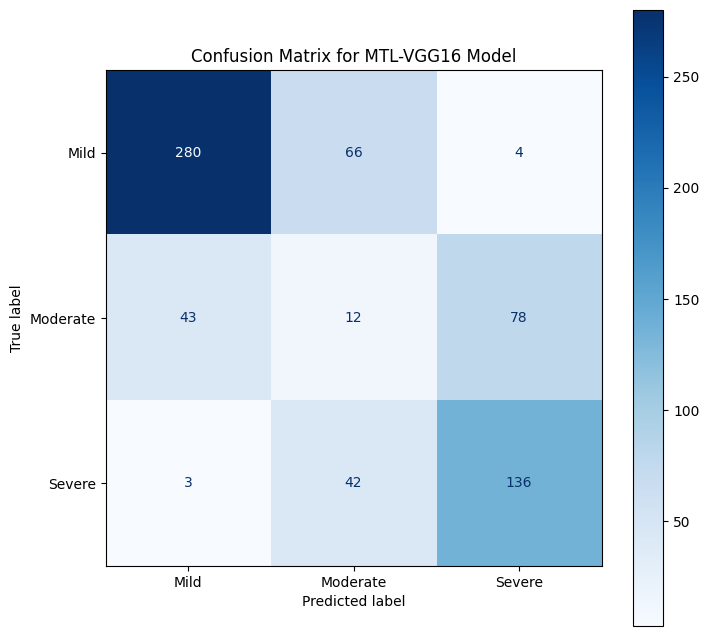

In [6]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import copy
import time
from torchvision import models

# --- 1. CONFIGURATION ---
# This pickle file is created by your data generation script
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224) # VGG16 is pre-trained on 224x224
NUM_MAIN_CLASSES = 3
NUM_AUX_CLASSES = 2 # Binary (e.g., Mild vs Not-Mild)
BATCH_SIZE = 16 # VGG16 is large, so a smaller batch size is better
NUM_EPOCHS = 50
PATIENCE = 10
INITIAL_LR = 1e-5 # A smaller LR is good for fine-tuning
ETA_MIN_LR = 1e-6
T_0_EPOCHS = 10

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")
print(f"PyTorch version: {torch.__version__}")

# --- 3. DATA LOADING AND PREPARATION ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"The required input file was not found: {INPUT_PICKLE_PATH}\nPlease run 'generate_image_dataset.py' first.")
        
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("One or more data splits are empty after loading the pickle file.")
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['radiological_evaluation'].value_counts().sort_index().to_dict()
    main_task_labels = (train_df['radiological_evaluation'] - 1).values
    
    sample_weights_dict = {
        1: len(train_df) / class_counts.get(1, 1e-6),
        2: len(train_df) / class_counts.get(2, 1e-6),
        3: len(train_df) / class_counts.get(3, 1e-6)
    }
    sample_weights = np.array([sample_weights_dict[t] for t in train_df['radiological_evaluation'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    print("WeightedRandomSampler created.")
    
    # --- Create Weights for each Loss Function ---
    weights_main = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_MAIN_CLASSES), y=main_task_labels), dtype=torch.float).to(device)
    print(f"Main Task Loss Weights (for 0,1,2): {weights_main}")

    aux_mild_labels = (main_task_labels == 0).astype(int)
    weights_aux_mild = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=aux_mild_labels), dtype=torch.float).to(device)
    
    aux_moderate_labels = (main_task_labels == 1).astype(int)
    weights_aux_moderate = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=aux_moderate_labels), dtype=torch.float).to(device)

    aux_severe_labels = (main_task_labels == 2).astype(int)
    weights_aux_severe = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=aux_severe_labels), dtype=torch.float).to(device)

    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASET AND AUGMENTATIONS ---
if data_loaded:
    # Augmentations
    train_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
        A.GaussNoise(p=0.3),
        A.CoarseDropout(p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # --- *** UPDATED: MTL DATASET FOR ORIGINAL IMAGES *** ---
    class MTLDataset(Dataset):
        def __init__(self, dataframe, transform):
            self.df = dataframe
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            
            # --- New: Using only the original image ---
            image = row['original_image']
            
            image_tensor = self.transform(image=image)['image']
            
            # Create four separate labels
            original_label = row['radiological_evaluation']
            
            main_label = original_label - 1 # 0, 1, 2
            
            label_mild = 1 if main_label == 0 else 0
            label_moderate = 1 if main_label == 1 else 0
            label_severe = 1 if main_label == 2 else 0
            
            return (image_tensor, 
                    torch.tensor(main_label, dtype=torch.long),
                    torch.tensor(label_mild, dtype=torch.long),
                    torch.tensor(label_moderate, dtype=torch.long),
                    torch.tensor(label_severe, dtype=torch.long))

    # Datasets
    train_dataset = MTLDataset(train_df, train_aug)
    val_dataset = MTLDataset(val_df, eval_aug)
    test_dataset = MTLDataset(test_df, eval_aug)
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    
    print("Multi-Task Datasets (for original images) and DataLoaders are ready. 📊")

# --- 5. MODEL DEFINITION & TRAINING ---
if data_loaded:
    # --- *** MTL VGG16 MODEL (As per the paper) *** ---
    class MTL_VGG16(nn.Module):
        def __init__(self):
            super().__init__()
            base_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
            
            self.features = base_model.features
            self.avgpool = base_model.avgpool
            
            in_features = 512 * 7 * 7
            
            self.head_main = nn.Sequential(nn.Linear(in_features, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, NUM_MAIN_CLASSES))
            self.head_mild = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, NUM_AUX_CLASSES))
            self.head_moderate = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, NUM_AUX_CLASSES))
            self.head_severe = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, NUM_AUX_CLASSES))
        
        def forward(self, x):
            x = self.features(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            
            out_main = self.head_main(x)
            out_mild = self.head_mild(x)
            out_moderate = self.head_moderate(x)
            out_severe = self.head_severe(x)
            
            return out_main, out_mild, out_moderate, out_severe
            
    model = MTL_VGG16().to(device)
    print("Multi-Task VGG16 model created.")

if 'model' in locals() and model is not None:
    # --- Training Loop ---
    print("\n--- Starting Training ---")
    
    criterion_main = nn.CrossEntropyLoss(weight=weights_main)
    criterion_aux_mild = nn.CrossEntropyLoss(weight=weights_aux_mild)
    criterion_aux_moderate = nn.CrossEntropyLoss(weight=weights_aux_moderate)
    criterion_aux_severe = nn.CrossEntropyLoss(weight=weights_aux_severe)

    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0_EPOCHS, eta_min=ETA_MIN_LR, verbose=True)
    
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Train)")
        
        for image, label_main, label_mild, label_moderate, label_severe in train_pbar:
            image, label_main, label_mild, label_moderate, label_severe = \
                image.to(device), label_main.to(device), label_mild.to(device), label_moderate.to(device), label_severe.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():
                out_main, out_mild, out_moderate, out_severe = model(image)
                
                loss_main = criterion_main(out_main, label_main)
                loss_mild = criterion_aux_mild(out_mild, label_mild)
                loss_moderate = criterion_aux_moderate(out_moderate, label_moderate)
                loss_severe = criterion_aux_severe(out_severe, label_severe)
                
                # Sum all losses (as done in the paper)
                total_loss = loss_main + loss_mild + loss_moderate + loss_severe
            
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += total_loss.item()
            train_pbar.set_postfix({'total_loss': running_loss / (train_pbar.n + 1)})

        # Validation (only on the main task)
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for image, label_main, _, _, _ in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Val)"):
                image, label_main = image.to(device), label_main.to(device)
                with torch.cuda.amp.autocast():
                    out_main, _, _, _ = model(image)
                _, preds = torch.max(out_main, 1)
                val_corrects += torch.sum(preds == label_main.data)
        
        val_accuracy = val_corrects.double() / len(val_dataset)
        print(f"Epoch {epoch + 1} | Train Loss: {running_loss / len(train_loader):.4f} | Val Acc: {val_accuracy:.4f}")
        
        scheduler.step()
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_mtl_vgg16_model.pth')
            epochs_no_improve = 0
            print(f"  -> ✅ New best model saved with validation accuracy: {best_val_accuracy:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  -> ❌ No improvement for {epochs_no_improve} epochs.")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered.")
            break
            
    print("\n--- Training Finished ---")

    # --- FINAL EVALUATION ---
    print("\n--- Evaluating Best Model on Test Set ---")
    try:
        model.load_state_dict(torch.load('best_mtl_vgg16_model.pth'))
        model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for image, label_main, _, _, _ in tqdm(test_loader, desc="Testing"):
                image, label_main = image.to(device), label_main.to(device)
                with torch.cuda.amp.autocast():
                    outputs, _, _, _ = model(image)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(label_main.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        print("\n--- FINAL CLASSIFICATION REPORT ---")
        report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        
        print("\n--- Individual Class Metrics ---")
        for i, class_name in enumerate(class_names):
            metrics = report_dict.get(class_name, {})
            print(f"--- Class: {class_name} (Original Label: {i+1}) ---")
            print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
            print(f"  Precision:         {metrics.get('precision', 0):.4f}")
            print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix for MTL-VGG16 Model")
        plt.show()

    except FileNotFoundError:
        print("Error: 'best_mtl_vgg16_model.pth' not found.")
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")



Using device: cuda ⚙️
PyTorch version: 2.6.0+cu124

--- Loading Pre-processed Data from Pickle File ---
Loaded data: 5364 train, 674 val, 664 test.

Setting up data balancing for training...
WeightedRandomSampler created.
Main Task Loss Weights (for 0,1,2): tensor([0.8206, 0.8642, 1.6022], device='cuda:0')
Multi-Task Datasets (for original images) and DataLoaders are ready. 📊


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_112/4281224170.py:204: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Multi-Task VGG16 model created.

--- Starting Training ---


Epoch 1/50 (Train):   0%|          | 0/335 [00:00<?, ?it/s]/tmp/ipykernel_112/4281224170.py:217: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 (Val):   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_112/4281224170.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.02it/s]


Epoch 1 | Train Loss: 2.6027 | Val Acc: 0.7478
  -> ✅ New best model saved with validation accuracy: 0.7478


Epoch 2/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.09it/s]


Epoch 2 | Train Loss: 2.1354 | Val Acc: 0.7745
  -> ✅ New best model saved with validation accuracy: 0.7745


Epoch 3/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.06it/s]


Epoch 3 | Train Loss: 1.9308 | Val Acc: 0.7611
  -> ❌ No improvement for 1 epochs.


Epoch 4/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.02it/s]


Epoch 4 | Train Loss: 1.7818 | Val Acc: 0.7641
  -> ❌ No improvement for 2 epochs.


Epoch 5/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  7.93it/s]


Epoch 5 | Train Loss: 1.6615 | Val Acc: 0.7537
  -> ❌ No improvement for 3 epochs.


Epoch 6/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  7.95it/s]


Epoch 6 | Train Loss: 1.5167 | Val Acc: 0.7567
  -> ❌ No improvement for 4 epochs.


Epoch 7/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.09it/s]


Epoch 7 | Train Loss: 1.4605 | Val Acc: 0.7240
  -> ❌ No improvement for 5 epochs.


Epoch 8/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.00it/s]


Epoch 8 | Train Loss: 1.4017 | Val Acc: 0.7255
  -> ❌ No improvement for 6 epochs.


Epoch 9/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.03it/s]


Epoch 9 | Train Loss: 1.3652 | Val Acc: 0.7018
  -> ❌ No improvement for 7 epochs.


Epoch 10/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.07it/s]


Epoch 10 | Train Loss: 1.3106 | Val Acc: 0.7315
  -> ❌ No improvement for 8 epochs.


Epoch 11/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.10it/s]


Epoch 11 | Train Loss: 1.3332 | Val Acc: 0.7300
  -> ❌ No improvement for 9 epochs.


Epoch 12/50 (Val): 100%|██████████| 22/22 [00:02<00:00,  8.10it/s]


Epoch 12 | Train Loss: 1.2339 | Val Acc: 0.6944
  -> ❌ No improvement for 10 epochs.

Early stopping triggered.

--- Training Finished ---

--- Evaluating Best Model on Test Set ---


Testing:   0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_112/4281224170.py:276: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Testing: 100%|██████████| 21/21 [00:02<00:00,  7.77it/s]


--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        Mild       0.85      0.78      0.81       350
    Moderate       0.15      0.19      0.17       133
      Severe       0.59      0.57      0.58       181

    accuracy                           0.61       664
   macro avg       0.53      0.51      0.52       664
weighted avg       0.64      0.61      0.62       664


--- Individual Class Metrics ---
--- Class: Mild (Original Label: 1) ---
  Accuracy (Recall): 0.7800
  Precision:         0.8531
  F1-Score:          0.8149
--- Class: Moderate (Original Label: 2) ---
  Accuracy (Recall): 0.1880
  Precision:         0.1497
  F1-Score:          0.1667
--- Class: Severe (Original Label: 3) ---
  Accuracy (Recall): 0.5746
  Precision:         0.5876
  F1-Score:          0.5810

--- Confusion Matrix ---


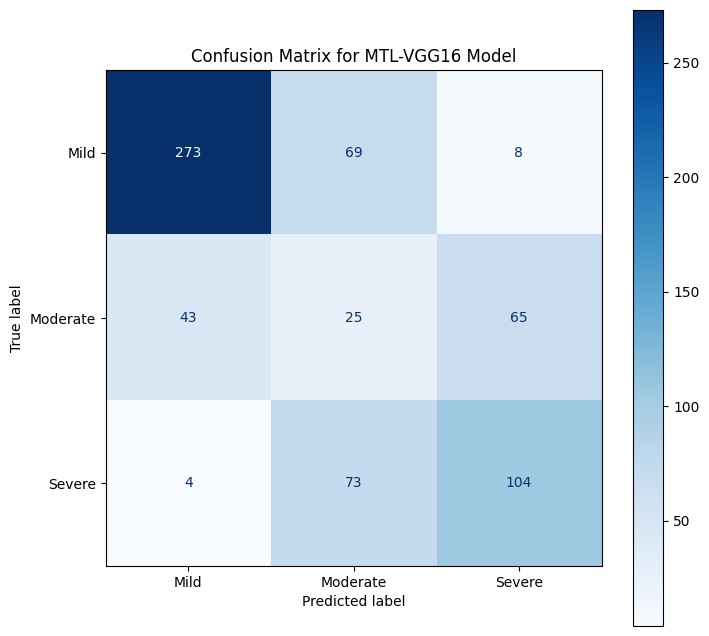

In [7]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import copy
import time
from torchvision import models

# --- 1. CONFIGURATION ---
# This pickle file is created by your data generation script
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224) # VGG16 is pre-trained on 224x224
NUM_MAIN_CLASSES = 3
NUM_AUX_CLASSES = 2 # Binary (e.g., Mild vs Not-Mild)
BATCH_SIZE = 16 # VGG16 is large, so a smaller batch size is better
NUM_EPOCHS = 50
PATIENCE = 10
INITIAL_LR = 1e-5 # A smaller LR is good for fine-tuning
ETA_MIN_LR = 1e-6
T_0_EPOCHS = 10

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")
print(f"PyTorch version: {torch.__version__}")

# --- 3. DATA LOADING AND PREPARATION ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"The required input file was not found: {INPUT_PICKLE_PATH}\nPlease run 'generate_image_dataset.py' first.")
        
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("One or more data splits are empty after loading the pickle file.")
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['radiological_evaluation'].value_counts().sort_index().to_dict()
    main_task_labels = (train_df['radiological_evaluation'] - 1).values
    
    sample_weights_dict = {
        1: len(train_df) / class_counts.get(1, 1e-6),
        2: len(train_df) / class_counts.get(2, 1e-6),
        3: len(train_df) / class_counts.get(3, 1e-6)
    }
    sample_weights = np.array([sample_weights_dict[t] for t in train_df['radiological_evaluation'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    print("WeightedRandomSampler created.")
    
    # --- Create Weights for each Loss Function ---
    weights_main = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_MAIN_CLASSES), y=main_task_labels), dtype=torch.float).to(device)
    print(f"Main Task Loss Weights (for 0,1,2): {weights_main}")

    aux_mild_labels = (main_task_labels == 0).astype(int)
    weights_aux_mild = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=aux_mild_labels), dtype=torch.float).to(device)
    
    aux_moderate_labels = (main_task_labels == 1).astype(int)
    weights_aux_moderate = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=aux_moderate_labels), dtype=torch.float).to(device)

    aux_severe_labels = (main_task_labels == 2).astype(int)
    weights_aux_severe = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=aux_severe_labels), dtype=torch.float).to(device)

    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASET AND AUGMENTATIONS ---
if data_loaded:
    # Augmentations
    train_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
        A.GaussNoise(p=0.3),
        A.CoarseDropout(p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # --- *** UPDATED: MTL DATASET FOR ORIGINAL IMAGES *** ---
    class MTLDataset(Dataset):
        def __init__(self, dataframe, transform):
            self.df = dataframe
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            
            # --- New: Using only the original image ---
            image = row['original_image']
            
            image_tensor = self.transform(image=image)['image']
            
            # Create four separate labels
            original_label = row['radiological_evaluation']
            
            main_label = original_label - 1 # 0, 1, 2
            
            label_mild = 1 if main_label == 0 else 0
            label_moderate = 1 if main_label == 1 else 0
            label_severe = 1 if main_label == 2 else 0
            
            return (image_tensor, 
                    torch.tensor(main_label, dtype=torch.long),
                    torch.tensor(label_mild, dtype=torch.long),
                    torch.tensor(label_moderate, dtype=torch.long),
                    torch.tensor(label_severe, dtype=torch.long))

    # Datasets
    train_dataset = MTLDataset(train_df, train_aug)
    val_dataset = MTLDataset(val_df, eval_aug)
    test_dataset = MTLDataset(test_df, eval_aug)
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    
    print("Multi-Task Datasets (for original images) and DataLoaders are ready. 📊")

# --- 5. MODEL DEFINITION & TRAINING ---
if data_loaded:
    # --- *** MTL VGG16 MODEL (As per the paper) *** ---
    class MTL_VGG16(nn.Module):
        def __init__(self):
            super().__init__()
            base_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
            
            self.features = base_model.features
            self.avgpool = base_model.avgpool
            
            in_features = 512 * 7 * 7
            
            self.head_main = nn.Sequential(nn.Linear(in_features, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, NUM_MAIN_CLASSES))
            self.head_mild = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, NUM_AUX_CLASSES))
            self.head_moderate = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, NUM_AUX_CLASSES))
            self.head_severe = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, NUM_AUX_CLASSES))
        
        def forward(self, x):
            x = self.features(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            
            out_main = self.head_main(x)
            out_mild = self.head_mild(x)
            out_moderate = self.head_moderate(x)
            out_severe = self.head_severe(x)
            
            return out_main, out_mild, out_moderate, out_severe
            
    model = MTL_VGG16().to(device)
    print("Multi-Task VGG16 model created.")

if 'model' in locals() and model is not None:
    # --- Training Loop ---
    print("\n--- Starting Training ---")
    
    criterion_main = nn.CrossEntropyLoss(weight=weights_main)
    criterion_aux_mild = nn.CrossEntropyLoss(weight=weights_aux_mild)
    criterion_aux_moderate = nn.CrossEntropyLoss(weight=weights_aux_moderate)
    criterion_aux_severe = nn.CrossEntropyLoss(weight=weights_aux_severe)

    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0_EPOCHS, eta_min=ETA_MIN_LR, verbose=True)
    
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Train)")
        
        for image, label_main, label_mild, label_moderate, label_severe in train_pbar:
            image, label_main, label_mild, label_moderate, label_severe = \
                image.to(device), label_main.to(device), label_mild.to(device), label_moderate.to(device), label_severe.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():
                out_main, out_mild, out_moderate, out_severe = model(image)
                
                loss_main = criterion_main(out_main, label_main)
                loss_mild = criterion_aux_mild(out_mild, label_mild)
                loss_moderate = criterion_aux_moderate(out_moderate, label_moderate)
                loss_severe = criterion_aux_severe(out_severe, label_severe)
                
                # Sum all losses (as done in the paper)
                total_loss = loss_main + loss_mild + loss_moderate + loss_severe
            
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += total_loss.item()
            train_pbar.set_postfix({'total_loss': running_loss / (train_pbar.n + 1)})

        # Validation (only on the main task)
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for image, label_main, _, _, _ in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Val)"):
                image, label_main = image.to(device), label_main.to(device)
                with torch.cuda.amp.autocast():
                    out_main, _, _, _ = model(image)
                _, preds = torch.max(out_main, 1)
                val_corrects += torch.sum(preds == label_main.data)
        
        val_accuracy = val_corrects.double() / len(val_dataset)
        print(f"Epoch {epoch + 1} | Train Loss: {running_loss / len(train_loader):.4f} | Val Acc: {val_accuracy:.4f}")
        
        scheduler.step()
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_mtl_vgg16_model.pth')
            epochs_no_improve = 0
            print(f"  -> ✅ New best model saved with validation accuracy: {best_val_accuracy:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  -> ❌ No improvement for {epochs_no_improve} epochs.")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered.")
            break
            
    print("\n--- Training Finished ---")

    # --- FINAL EVALUATION ---
    print("\n--- Evaluating Best Model on Test Set ---")
    try:
        model.load_state_dict(torch.load('best_mtl_vgg16_model.pth'))
        model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for image, label_main, _, _, _ in tqdm(test_loader, desc="Testing"):
                image, label_main = image.to(device), label_main.to(device)
                with torch.cuda.amp.autocast():
                    outputs, _, _, _ = model(image)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(label_main.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        print("\n--- FINAL CLASSIFICATION REPORT ---")
        report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        
        print("\n--- Individual Class Metrics ---")
        for i, class_name in enumerate(class_names):
            metrics = report_dict.get(class_name, {})
            print(f"--- Class: {class_name} (Original Label: {i+1}) ---")
            print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
            print(f"  Precision:         {metrics.get('precision', 0):.4f}")
            print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix for MTL-VGG16 Model")
        plt.show()

    except FileNotFoundError:
        print("Error: 'best_mtl_vgg16_model.pth' not found.")
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")



Using device: cuda ⚙️

--- Loading Pre-processed Data from Pickle File ---
Loaded data: 5364 train, 674 val, 664 test.

Setting up data balancing for training...
Class weights for loss function: tensor([0.8206, 0.8642, 1.6022], device='cuda:0')


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_112/2055210528.py:84: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 60.0), p=0.5),
/tmp/ipykernel_112/2055210528.py:85: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
/tmp/ipykernel_112/2055210528.py:153: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



--- Training Expert: Global_ResNet34 ---


Train Ep 1:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_112/2055210528.py:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val Ep 1:   0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_112/2055210528.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val Ep 1: 100%|██████████| 11/11 [00:01<00:00,  7.12it/s]


Epoch 1 Val Acc: 0.7448
  -> New best model saved!


Val Ep 2: 100%|██████████| 11/11 [00:01<00:00,  7.27it/s]


Epoch 2 Val Acc: 0.7240


Val Ep 3: 100%|██████████| 11/11 [00:01<00:00,  7.33it/s]


Epoch 3 Val Acc: 0.6484


Val Ep 4: 100%|██████████| 11/11 [00:01<00:00,  7.22it/s]


Epoch 4 Val Acc: 0.7211


Val Ep 5: 100%|██████████| 11/11 [00:01<00:00,  7.17it/s]


Epoch 5 Val Acc: 0.6617


Val Ep 6: 100%|██████████| 11/11 [00:01<00:00,  7.25it/s]


Epoch 6 Val Acc: 0.7329


Val Ep 7: 100%|██████████| 11/11 [00:01<00:00,  7.25it/s]


Epoch 7 Val Acc: 0.6929


Val Ep 8: 100%|██████████| 11/11 [00:01<00:00,  7.25it/s]


Epoch 8 Val Acc: 0.7136
  -> Early stopping.

--- Training Expert: Local_DenseNet121 ---


Val Ep 1: 100%|██████████| 11/11 [00:02<00:00,  5.39it/s]


Epoch 1 Val Acc: 0.4585
  -> New best model saved!


Val Ep 2: 100%|██████████| 11/11 [00:02<00:00,  5.47it/s]


Epoch 2 Val Acc: 0.3754


Val Ep 3: 100%|██████████| 11/11 [00:02<00:00,  5.43it/s]


Epoch 3 Val Acc: 0.4807
  -> New best model saved!


Val Ep 4: 100%|██████████| 11/11 [00:02<00:00,  5.39it/s]


Epoch 4 Val Acc: 0.4837
  -> New best model saved!


Val Ep 5: 100%|██████████| 11/11 [00:02<00:00,  5.35it/s]


Epoch 5 Val Acc: 0.5297
  -> New best model saved!


Val Ep 6: 100%|██████████| 11/11 [00:02<00:00,  5.37it/s]


Epoch 6 Val Acc: 0.5475
  -> New best model saved!


Val Ep 7: 100%|██████████| 11/11 [00:02<00:00,  5.45it/s]


Epoch 7 Val Acc: 0.5208


Val Ep 8: 100%|██████████| 11/11 [00:02<00:00,  5.41it/s]


Epoch 8 Val Acc: 0.5208


Val Ep 9: 100%|██████████| 11/11 [00:02<00:00,  5.37it/s]


Epoch 9 Val Acc: 0.5148


Val Ep 10: 100%|██████████| 11/11 [00:02<00:00,  5.38it/s]


Epoch 10 Val Acc: 0.5163


Val Ep 11: 100%|██████████| 11/11 [00:02<00:00,  5.40it/s]


Epoch 11 Val Acc: 0.5015


Val Ep 12: 100%|██████████| 11/11 [00:02<00:00,  5.33it/s]


Epoch 12 Val Acc: 0.5163


Val Ep 13: 100%|██████████| 11/11 [00:02<00:00,  5.39it/s]


Epoch 13 Val Acc: 0.5237
  -> Early stopping.

--- Training Expert: Mask_ResNet50 ---


Train Ep 1:   0%|          | 0/167 [00:00<?, ?it/s]


!!!!!!!! FAILED to train Expert C (Mask_ResNet50): Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_112/2055210528.py", line 140, in __getitem__
    stacked = np.stack([gt_mask, pred_mask], axis=-1)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dis

Getting Predictions:   0%|          | 0/84 [00:00<?, ?it/s]/tmp/ipykernel_112/2055210528.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Getting Predictions: 100%|██████████| 11/11 [00:01<00:00,  6.66it/s]


Getting predictions from: Local_DenseNet121


Getting Predictions:  58%|█████▊    | 49/84 [00:06<00:04,  8.07it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c1ee80e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
Getting Predictions:  60%|█████▉    | 50/84 [00:06<00:04,  8.14it/s]^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Getting Predictions:  61%|██████    | 51/84 [00:06<00:04,  7.91it/s]^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Getting Predictions:  74%|███████▍  | 62/84 [00:08<00:02,  7.92it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c1ee80e8e0>
Traceback (

Meta-dataset created. Train shape: (5364, 6)

--- Training Manager Model (XGBoost) ---
[0]	validation_0-mlogloss:1.06449



/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:36:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-mlogloss:0.61136
[149]	validation_0-mlogloss:0.61448

--- Manager Training Complete ---

--- FINAL STACKED ENSEMBLE TEST EVALUATION ---

--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        Mild       0.85      0.63      0.72       350
    Moderate       0.13      0.20      0.16       133
      Severe       0.63      0.66      0.64       181

    accuracy                           0.55       664
   macro avg       0.53      0.50      0.51       664
weighted avg       0.64      0.55      0.59       664


--- Individual Class Metrics ---
--- Class: Mild (Original Label: 1) ---
  Accuracy (Recall): 0.6286
  Precision:         0.8494
  F1-Score:          0.7225
--- Class: Moderate (Original Label: 2) ---
  Accuracy (Recall): 0.2030
  Precision:         0.1256
  F1-Score:          0.1552
--- Class: Severe (Original Label: 3) ---
  Accuracy (Recall): 0.6575
  Precision:         0.6263
  F1-Score:          0.6415

--- Confusion 

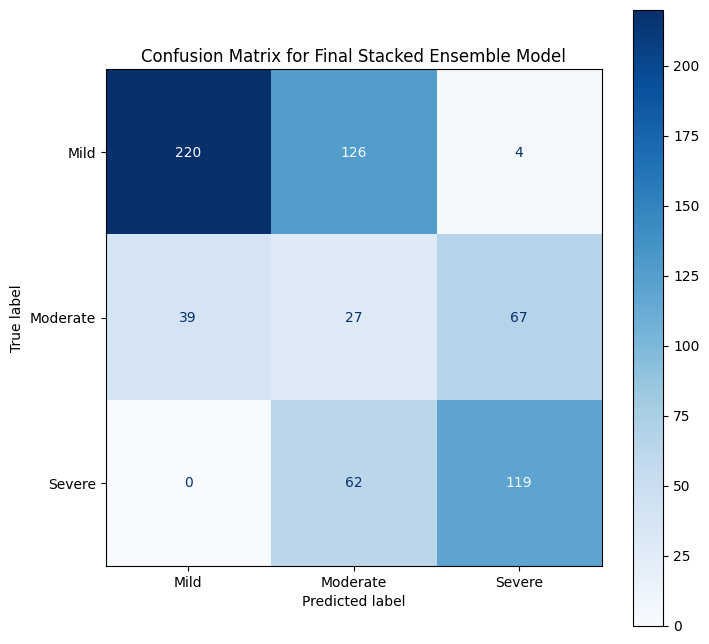

In [8]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
from torchvision import models
import xgboost as xgb
import timm

# --- 1. CONFIGURATION ---
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 3
BATCH_SIZE = 32
NUM_EPOCHS_CNN = 25
PATIENCE_CNN = 7
INITIAL_LR = 1e-4

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- 3. DATA LOADING & BALANCING SETUP ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"Proyojoniyo input file-ti paowa jayni: {INPUT_PICKLE_PATH}")
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['radiological_evaluation'].value_counts().sort_index().to_dict()
    main_task_labels_for_weighting = (train_df['radiological_evaluation'] - 1).values
    
    sample_weights_dict = {
        1: len(train_df) / class_counts.get(1, 1e-6),
        2: len(train_df) / class_counts.get(2, 1e-6),
        3: len(train_df) / class_counts.get(3, 1e-6)
    }
    sample_weights = np.array([sample_weights_dict[t] for t in train_df['radiological_evaluation'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    
    class_weights_loss = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=main_task_labels_for_weighting), dtype=torch.float).to(device)
    print(f"Class weights for loss function: {class_weights_loss}")
    
    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASETS AND AUGMENTATIONS ---
if data_loaded:
    # Augmentations for RGB images
    strong_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
        A.GaussNoise(var_limit=(10.0, 60.0), p=0.5),
        A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    # Augmentations for 2-channel mask images (geometric only)
    mask_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75),
        ToTensorV2()
    ])

    # --- Datasets for each Expert ---
    # Expert A: Global Context (Full Image)
    class GlobalDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            image = self.transform(image=row['original_image'])['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

    # Expert B: Local Texture (Cropped Image)
    class LocalDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            image, mask = row['original_image'], row['predicted_mask']
            crop = image
            try:
                if mask is not None and mask.max() > 0:
                    bbox = find_objects(mask)
                    if bbox:
                        sy, sx = bbox[0]
                        if sy.stop > sy.start and sx.stop > sx.start: crop = image[sy.start:sy.stop, sx.start:sx.stop]
            except: pass
            image = self.transform(image=crop)['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

    # Expert C: Shape & Error Analysis (Mask Comparison)
    class MaskDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            gt_mask = (row['ground_truth_mask'] > 0).astype(np.uint8) * 255
            pred_mask = (row['predicted_mask'] > 0).astype(np.uint8) * 255
            stacked = np.stack([gt_mask, pred_mask], axis=-1)
            image = self.transform(image=stacked)['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

# --- 5. HELPER FUNCTIONS FOR TRAINING & PREDICTION ---
def train_expert_model(model, model_name, train_loader, val_loader):
    print(f"\n--- Training Expert: {model_name} ---")
    criterion = nn.CrossEntropyLoss(weight=class_weights_loss, label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-6)
    best_acc = 0.0
    epochs_no_improve = 0
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS_CNN):
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Train Ep {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        scheduler.step()

        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Val Ep {epoch+1}"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Epoch {epoch+1} Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'best_expert_{model_name}.pth')
            epochs_no_improve = 0
            print(f"  -> New best model saved!")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= PATIENCE_CNN:
            print("  -> Early stopping.")
            break
    
    model.load_state_dict(torch.load(f'best_expert_{model_name}.pth'))
    return model

def get_expert_predictions(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for images, _ in tqdm(loader, desc="Getting Predictions"):
            images = images.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
            preds.append(F.softmax(outputs, dim=1).cpu().numpy())
    return np.concatenate(preds, axis=0)

# --- 6. PHASE 1: Train All Expert Models ---
if data_loaded:
    successful_experts = {}
    
    # --- Expert A: Global (ResNet34) ---
    try:
        train_loader_global = DataLoader(GlobalDataset(train_df, strong_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_global = DataLoader(GlobalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_global = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        model_global.fc = nn.Linear(model_global.fc.in_features, NUM_CLASSES)
        model_global = train_expert_model(model_global.to(device), "Global_ResNet34", train_loader_global, val_loader_global)
        successful_experts['global'] = model_global
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert A (Global_ResNet34): {e} !!!!!!!!")

    # --- Expert B: Local (DenseNet121) ---
    try:
        train_loader_local = DataLoader(LocalDataset(train_df, strong_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_local = DataLoader(LocalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_local = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        model_local.classifier = nn.Linear(model_local.classifier.in_features, NUM_CLASSES)
        model_local = train_expert_model(model_local.to(device), "Local_DenseNet121", train_loader_local, val_loader_local)
        successful_experts['local'] = model_local
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert B (Local_DenseNet121): {e} !!!!!!!!")

    # --- Expert C: Mask Comparison (ResNet50) ---
    try:
        train_loader_mask = DataLoader(MaskDataset(train_df, mask_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_mask = DataLoader(MaskDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_mask = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        orig_weights = model_mask.conv1.weight.clone()
        new_weights = orig_weights.sum(dim=1, keepdim=True).repeat(1,2,1,1) / 3
        model_mask.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model_mask.conv1.weight.data = new_weights
        model_mask.fc = nn.Linear(model_mask.fc.in_features, NUM_CLASSES)
        model_mask = train_expert_model(model_mask.to(device), "Mask_ResNet50", train_loader_mask, val_loader_mask)
        successful_experts['mask'] = model_mask
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert C (Mask_ResNet50): {e} !!!!!!!!")
    
# --- 7. PHASE 2: Create Meta-Dataset and Train XGBoost ---
if 'successful_experts' in locals() and successful_experts:
    print("\n--- Creating Meta-Dataset from successfully trained experts ---")
    
    meta_features_train, meta_features_val, meta_features_test = [], [], []

    if 'global' in successful_experts:
        print("Getting predictions from: Global_ResNet34")
        train_loader_pred = DataLoader(GlobalDataset(train_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        val_loader_pred = DataLoader(GlobalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        test_loader_pred = DataLoader(GlobalDataset(test_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        meta_features_train.append(get_expert_predictions(successful_experts['global'], train_loader_pred))
        meta_features_val.append(get_expert_predictions(successful_experts['global'], val_loader_pred))
        meta_features_test.append(get_expert_predictions(successful_experts['global'], test_loader_pred))

    if 'local' in successful_experts:
        print("Getting predictions from: Local_DenseNet121")
        train_loader_pred = DataLoader(LocalDataset(train_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        val_loader_pred = DataLoader(LocalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        test_loader_pred = DataLoader(LocalDataset(test_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        meta_features_train.append(get_expert_predictions(successful_experts['local'], train_loader_pred))
        meta_features_val.append(get_expert_predictions(successful_experts['local'], val_loader_pred))
        meta_features_test.append(get_expert_predictions(successful_experts['local'], test_loader_pred))
        
    if 'mask' in successful_experts:
        print("Getting predictions from: Mask_ResNet50")
        train_loader_pred = DataLoader(MaskDataset(train_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        val_loader_pred = DataLoader(MaskDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        test_loader_pred = DataLoader(MaskDataset(test_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        meta_features_train.append(get_expert_predictions(successful_experts['mask'], train_loader_pred))
        meta_features_val.append(get_expert_predictions(successful_experts['mask'], val_loader_pred))
        meta_features_test.append(get_expert_predictions(successful_experts['mask'], test_loader_pred))

    # Combine predictions to form meta-dataset
    X_train_meta = np.hstack(meta_features_train)
    X_val_meta = np.hstack(meta_features_val)
    X_test_meta = np.hstack(meta_features_test)

    y_train_meta = (train_df['radiological_evaluation'] - 1).values
    y_val_meta = (val_df['radiological_evaluation'] - 1).values
    y_test_meta = (test_df['radiological_evaluation'] - 1).values
    
    print(f"Meta-dataset created. Train shape: {X_train_meta.shape}")

    # --- Train XGBoost Manager ---
    print("\n--- Training Manager Model (XGBoost) ---")
    from sklearn.utils.class_weight import compute_sample_weight
    sample_weights_xgb = compute_sample_weight(class_weight='balanced', y=y_train_meta)
    
    xgb_manager = xgb.XGBClassifier(
        objective='multi:softmax', num_class=NUM_CLASSES, use_label_encoder=False,
        eval_metric='mlogloss', n_estimators=500, learning_rate=0.05,
        max_depth=4, subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=50
    )

    xgb_manager.fit(X_train_meta, y_train_meta,
                    sample_weight=sample_weights_xgb,
                    eval_set=[(X_val_meta, y_val_meta)],
                    verbose=100)
    
    print("\n--- Manager Training Complete ---")

    # --- 8. FINAL EVALUATION ---
    print("\n" + "="*80)
    print("--- FINAL STACKED ENSEMBLE TEST EVALUATION ---")
    print("="*80)

    y_pred_meta = xgb_manager.predict(X_test_meta)
    
    print("\n--- FINAL CLASSIFICATION REPORT ---")
    report_dict = classification_report(y_test_meta, y_pred_meta, target_names=class_names, zero_division=0, output_dict=True)
    print(classification_report(y_test_meta, y_pred_meta, target_names=class_names, zero_division=0))
    
    print("\n--- Individual Class Metrics ---")
    for i, class_name in enumerate(class_names):
        metrics = report_dict.get(class_name, {})
        print(f"--- Class: {class_name} (Original Label: {i+1}) ---")
        print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
        print(f"  Precision:         {metrics.get('precision', 0):.4f}")
        print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test_meta, y_pred_meta, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Final Stacked Ensemble Model")
    plt.show()

else:
    print("\nNo expert models were trained successfully. Cannot proceed to stacking.")



Using device: cuda ⚙️

--- Loading Pre-processed Data from Pickle File ---
Loaded data: 5364 train, 674 val, 664 test.

Setting up data balancing for training...
Class weights for loss function: tensor([0.8206, 0.8642, 1.6022], device='cuda:0')


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_112/2055210528.py:84: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 60.0), p=0.5),
/tmp/ipykernel_112/2055210528.py:85: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
/tmp/ipykernel_112/2055210528.py:153: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



--- Training Expert: Global_ResNet34 ---


Train Ep 1:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_112/2055210528.py:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val Ep 1:   0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_112/2055210528.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val Ep 1: 100%|██████████| 11/11 [00:01<00:00,  7.01it/s]


Epoch 1 Val Acc: 0.7107
  -> New best model saved!


Val Ep 2: 100%|██████████| 11/11 [00:01<00:00,  7.07it/s]


Epoch 2 Val Acc: 0.7240
  -> New best model saved!


Val Ep 3: 100%|██████████| 11/11 [00:01<00:00,  7.28it/s]


Epoch 3 Val Acc: 0.7285
  -> New best model saved!


Val Ep 4: 100%|██████████| 11/11 [00:01<00:00,  7.29it/s]


Epoch 4 Val Acc: 0.6929


Val Ep 5: 100%|██████████| 11/11 [00:01<00:00,  7.19it/s]


Epoch 5 Val Acc: 0.6484


Val Ep 6: 100%|██████████| 11/11 [00:01<00:00,  7.25it/s]


Epoch 6 Val Acc: 0.6869


Val Ep 7: 100%|██████████| 11/11 [00:01<00:00,  7.22it/s]


Epoch 7 Val Acc: 0.7077


Val Ep 8: 100%|██████████| 11/11 [00:01<00:00,  7.18it/s]


Epoch 8 Val Acc: 0.6944


Val Ep 9: 100%|██████████| 11/11 [00:01<00:00,  7.02it/s]


Epoch 9 Val Acc: 0.6691


Val Ep 10: 100%|██████████| 11/11 [00:01<00:00,  7.18it/s]


Epoch 10 Val Acc: 0.6855
  -> Early stopping.

--- Training Expert: Local_DenseNet121 ---


Val Ep 1: 100%|██████████| 11/11 [00:02<00:00,  5.36it/s]


Epoch 1 Val Acc: 0.4629
  -> New best model saved!


Val Ep 2: 100%|██████████| 11/11 [00:02<00:00,  5.32it/s]


Epoch 2 Val Acc: 0.5371
  -> New best model saved!


Val Ep 3: 100%|██████████| 11/11 [00:02<00:00,  5.37it/s]


Epoch 3 Val Acc: 0.4941


Val Ep 4: 100%|██████████| 11/11 [00:02<00:00,  5.33it/s]


Epoch 4 Val Acc: 0.4941


Val Ep 5: 100%|██████████| 11/11 [00:02<00:00,  5.38it/s]


Epoch 5 Val Acc: 0.5579
  -> New best model saved!


Val Ep 6: 100%|██████████| 11/11 [00:02<00:00,  5.32it/s]


Epoch 6 Val Acc: 0.5593
  -> New best model saved!


Val Ep 7: 100%|██████████| 11/11 [00:02<00:00,  5.35it/s]


Epoch 7 Val Acc: 0.4985


Val Ep 8: 100%|██████████| 11/11 [00:02<00:00,  5.36it/s]


Epoch 8 Val Acc: 0.5267


Val Ep 9: 100%|██████████| 11/11 [00:02<00:00,  5.36it/s]


Epoch 9 Val Acc: 0.5445


Val Ep 10: 100%|██████████| 11/11 [00:02<00:00,  5.40it/s]


Epoch 10 Val Acc: 0.5534


Val Ep 11: 100%|██████████| 11/11 [00:02<00:00,  5.36it/s]


Epoch 11 Val Acc: 0.5252


Val Ep 12: 100%|██████████| 11/11 [00:02<00:00,  5.35it/s]


Epoch 12 Val Acc: 0.4955


Val Ep 13: 100%|██████████| 11/11 [00:02<00:00,  5.38it/s]


Epoch 13 Val Acc: 0.5178
  -> Early stopping.

--- Training Expert: Mask_ResNet50 ---


Train Ep 1:   0%|          | 0/167 [00:00<?, ?it/s]


!!!!!!!! FAILED to train Expert C (Mask_ResNet50): Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_112/2055210528.py", line 140, in __getitem__
    stacked = np.stack([gt_mask, pred_mask], axis=-1)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dis

Getting Predictions:   0%|          | 0/84 [00:00<?, ?it/s]/tmp/ipykernel_112/2055210528.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Getting Predictions: 100%|██████████| 11/11 [00:01<00:00,  6.75it/s]


Getting predictions from: Local_DenseNet121


Getting Predictions:  44%|████▍     | 37/84 [00:05<00:05,  8.20it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c1ee80e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
Getting Predictions:  45%|████▌     | 38/84 [00:05<00:05,  8.21it/s]^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Getting Predictions:  46%|████▋     | 39/84 [00:05<00:05,  8.07it/s]^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Getting Predictions:  55%|█████▍    | 46/84 [00:06<00:04,  7.84it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c1ee80e8e0>
Traceback (m

Meta-dataset created. Train shape: (5364, 6)

--- Training Manager Model (XGBoost) ---
[0]	validation_0-mlogloss:1.06148
[100]	validation_0-mlogloss:0.61221



/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [12:05:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[181]	validation_0-mlogloss:0.61933

--- Manager Training Complete ---

--- FINAL STACKED ENSEMBLE TEST EVALUATION ---

--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        Mild       0.88      0.67      0.76       350
    Moderate       0.18      0.29      0.22       133
      Severe       0.59      0.59      0.59       181

    accuracy                           0.57       664
   macro avg       0.55      0.52      0.53       664
weighted avg       0.66      0.57      0.61       664


--- Individual Class Metrics ---
--- Class: Mild (Original Label: 1) ---
  Accuracy (Recall): 0.6743
  Precision:         0.8806
  F1-Score:          0.7638
--- Class: Moderate (Original Label: 2) ---
  Accuracy (Recall): 0.2932
  Precision:         0.1797
  F1-Score:          0.2229
--- Class: Severe (Original Label: 3) ---
  Accuracy (Recall): 0.5856
  Precision:         0.5922
  F1-Score:          0.5889

--- Confusion Matrix ---


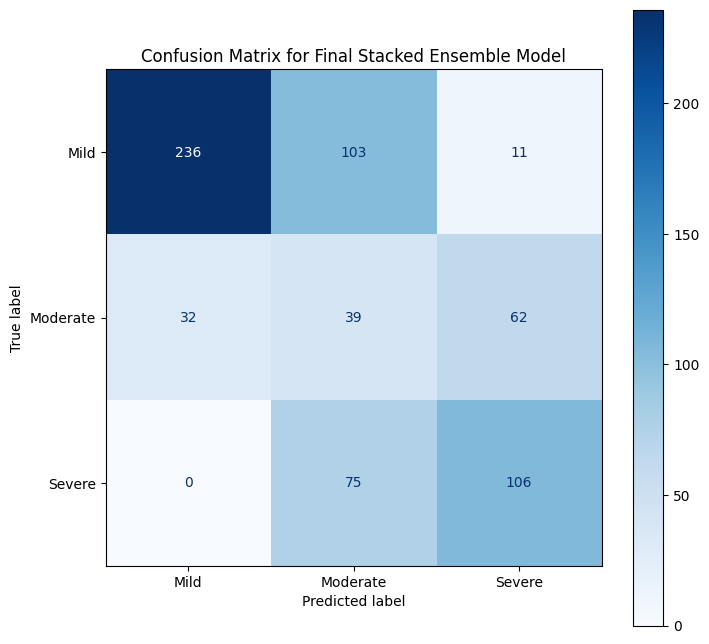

In [9]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
from torchvision import models
import xgboost as xgb
import timm

# --- 1. CONFIGURATION ---
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 3
BATCH_SIZE = 32
NUM_EPOCHS_CNN = 25
PATIENCE_CNN = 7
INITIAL_LR = 1e-4

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- 3. DATA LOADING & BALANCING SETUP ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"Proyojoniyo input file-ti paowa jayni: {INPUT_PICKLE_PATH}")
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['radiological_evaluation'].value_counts().sort_index().to_dict()
    main_task_labels_for_weighting = (train_df['radiological_evaluation'] - 1).values
    
    sample_weights_dict = {
        1: len(train_df) / class_counts.get(1, 1e-6),
        2: len(train_df) / class_counts.get(2, 1e-6),
        3: len(train_df) / class_counts.get(3, 1e-6)
    }
    sample_weights = np.array([sample_weights_dict[t] for t in train_df['radiological_evaluation'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    
    class_weights_loss = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=main_task_labels_for_weighting), dtype=torch.float).to(device)
    print(f"Class weights for loss function: {class_weights_loss}")
    
    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASETS AND AUGMENTATIONS ---
if data_loaded:
    # Augmentations for RGB images
    strong_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
        A.GaussNoise(var_limit=(10.0, 60.0), p=0.5),
        A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    # Augmentations for 2-channel mask images (geometric only)
    mask_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75),
        ToTensorV2()
    ])

    # --- Datasets for each Expert ---
    # Expert A: Global Context (Full Image)
    class GlobalDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            image = self.transform(image=row['original_image'])['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

    # Expert B: Local Texture (Cropped Image)
    class LocalDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            image, mask = row['original_image'], row['predicted_mask']
            crop = image
            try:
                if mask is not None and mask.max() > 0:
                    bbox = find_objects(mask)
                    if bbox:
                        sy, sx = bbox[0]
                        if sy.stop > sy.start and sx.stop > sx.start: crop = image[sy.start:sy.stop, sx.start:sx.stop]
            except: pass
            image = self.transform(image=crop)['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

    # Expert C: Shape & Error Analysis (Mask Comparison)
    class MaskDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            gt_mask = (row['ground_truth_mask'] > 0).astype(np.uint8) * 255
            pred_mask = (row['predicted_mask'] > 0).astype(np.uint8) * 255
            stacked = np.stack([gt_mask, pred_mask], axis=-1)
            image = self.transform(image=stacked)['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

# --- 5. HELPER FUNCTIONS FOR TRAINING & PREDICTION ---
def train_expert_model(model, model_name, train_loader, val_loader):
    print(f"\n--- Training Expert: {model_name} ---")
    criterion = nn.CrossEntropyLoss(weight=class_weights_loss, label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-6)
    best_acc = 0.0
    epochs_no_improve = 0
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS_CNN):
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Train Ep {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        scheduler.step()

        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Val Ep {epoch+1}"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Epoch {epoch+1} Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'best_expert_{model_name}.pth')
            epochs_no_improve = 0
            print(f"  -> New best model saved!")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= PATIENCE_CNN:
            print("  -> Early stopping.")
            break
    
    model.load_state_dict(torch.load(f'best_expert_{model_name}.pth'))
    return model

def get_expert_predictions(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for images, _ in tqdm(loader, desc="Getting Predictions"):
            images = images.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
            preds.append(F.softmax(outputs, dim=1).cpu().numpy())
    return np.concatenate(preds, axis=0)

# --- 6. PHASE 1: Train All Expert Models ---
if data_loaded:
    successful_experts = {}
    
    # --- Expert A: Global (ResNet34) ---
    try:
        train_loader_global = DataLoader(GlobalDataset(train_df, strong_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_global = DataLoader(GlobalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_global = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        model_global.fc = nn.Linear(model_global.fc.in_features, NUM_CLASSES)
        model_global = train_expert_model(model_global.to(device), "Global_ResNet34", train_loader_global, val_loader_global)
        successful_experts['global'] = model_global
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert A (Global_ResNet34): {e} !!!!!!!!")

    # --- Expert B: Local (DenseNet121) ---
    try:
        train_loader_local = DataLoader(LocalDataset(train_df, strong_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_local = DataLoader(LocalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_local = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        model_local.classifier = nn.Linear(model_local.classifier.in_features, NUM_CLASSES)
        model_local = train_expert_model(model_local.to(device), "Local_DenseNet121", train_loader_local, val_loader_local)
        successful_experts['local'] = model_local
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert B (Local_DenseNet121): {e} !!!!!!!!")

    # --- Expert C: Mask Comparison (ResNet50) ---
    try:
        train_loader_mask = DataLoader(MaskDataset(train_df, mask_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_mask = DataLoader(MaskDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_mask = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        orig_weights = model_mask.conv1.weight.clone()
        new_weights = orig_weights.sum(dim=1, keepdim=True).repeat(1,2,1,1) / 3
        model_mask.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model_mask.conv1.weight.data = new_weights
        model_mask.fc = nn.Linear(model_mask.fc.in_features, NUM_CLASSES)
        model_mask = train_expert_model(model_mask.to(device), "Mask_ResNet50", train_loader_mask, val_loader_mask)
        successful_experts['mask'] = model_mask
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert C (Mask_ResNet50): {e} !!!!!!!!")
    
# --- 7. PHASE 2: Create Meta-Dataset and Train XGBoost ---
if 'successful_experts' in locals() and successful_experts:
    print("\n--- Creating Meta-Dataset from successfully trained experts ---")
    
    meta_features_train, meta_features_val, meta_features_test = [], [], []

    if 'global' in successful_experts:
        print("Getting predictions from: Global_ResNet34")
        train_loader_pred = DataLoader(GlobalDataset(train_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        val_loader_pred = DataLoader(GlobalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        test_loader_pred = DataLoader(GlobalDataset(test_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        meta_features_train.append(get_expert_predictions(successful_experts['global'], train_loader_pred))
        meta_features_val.append(get_expert_predictions(successful_experts['global'], val_loader_pred))
        meta_features_test.append(get_expert_predictions(successful_experts['global'], test_loader_pred))

    if 'local' in successful_experts:
        print("Getting predictions from: Local_DenseNet121")
        train_loader_pred = DataLoader(LocalDataset(train_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        val_loader_pred = DataLoader(LocalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        test_loader_pred = DataLoader(LocalDataset(test_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        meta_features_train.append(get_expert_predictions(successful_experts['local'], train_loader_pred))
        meta_features_val.append(get_expert_predictions(successful_experts['local'], val_loader_pred))
        meta_features_test.append(get_expert_predictions(successful_experts['local'], test_loader_pred))
        
    if 'mask' in successful_experts:
        print("Getting predictions from: Mask_ResNet50")
        train_loader_pred = DataLoader(MaskDataset(train_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        val_loader_pred = DataLoader(MaskDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        test_loader_pred = DataLoader(MaskDataset(test_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        meta_features_train.append(get_expert_predictions(successful_experts['mask'], train_loader_pred))
        meta_features_val.append(get_expert_predictions(successful_experts['mask'], val_loader_pred))
        meta_features_test.append(get_expert_predictions(successful_experts['mask'], test_loader_pred))

    # Combine predictions to form meta-dataset
    X_train_meta = np.hstack(meta_features_train)
    X_val_meta = np.hstack(meta_features_val)
    X_test_meta = np.hstack(meta_features_test)

    y_train_meta = (train_df['radiological_evaluation'] - 1).values
    y_val_meta = (val_df['radiological_evaluation'] - 1).values
    y_test_meta = (test_df['radiological_evaluation'] - 1).values
    
    print(f"Meta-dataset created. Train shape: {X_train_meta.shape}")

    # --- Train XGBoost Manager ---
    print("\n--- Training Manager Model (XGBoost) ---")
    from sklearn.utils.class_weight import compute_sample_weight
    sample_weights_xgb = compute_sample_weight(class_weight='balanced', y=y_train_meta)
    
    xgb_manager = xgb.XGBClassifier(
        objective='multi:softmax', num_class=NUM_CLASSES, use_label_encoder=False,
        eval_metric='mlogloss', n_estimators=500, learning_rate=0.05,
        max_depth=4, subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=50
    )

    xgb_manager.fit(X_train_meta, y_train_meta,
                    sample_weight=sample_weights_xgb,
                    eval_set=[(X_val_meta, y_val_meta)],
                    verbose=100)
    
    print("\n--- Manager Training Complete ---")

    # --- 8. FINAL EVALUATION ---
    print("\n" + "="*80)
    print("--- FINAL STACKED ENSEMBLE TEST EVALUATION ---")
    print("="*80)

    y_pred_meta = xgb_manager.predict(X_test_meta)
    
    print("\n--- FINAL CLASSIFICATION REPORT ---")
    report_dict = classification_report(y_test_meta, y_pred_meta, target_names=class_names, zero_division=0, output_dict=True)
    print(classification_report(y_test_meta, y_pred_meta, target_names=class_names, zero_division=0))
    
    print("\n--- Individual Class Metrics ---")
    for i, class_name in enumerate(class_names):
        metrics = report_dict.get(class_name, {})
        print(f"--- Class: {class_name} (Original Label: {i+1}) ---")
        print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
        print(f"  Precision:         {metrics.get('precision', 0):.4f}")
        print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test_meta, y_pred_meta, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Final Stacked Ensemble Model")
    plt.show()

else:
    print("\nNo expert models were trained successfully. Cannot proceed to stacking.")



Using device: cuda ⚙️

--- Loading Pre-processed Data from Pickle File ---
Loaded data: 5364 train, 674 val, 664 test.

Setting up data balancing for training...
Class weights for loss function: tensor([0.8206, 0.8642, 1.6022], device='cuda:0')


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_112/1790441739.py:84: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 60.0), p=0.5),
/tmp/ipykernel_112/1790441739.py:85: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
/tmp/ipykernel_112/1790441739.py:150: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



--- Training Expert: Global_ResNet34 ---


Train Ep 1:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_112/1790441739.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val Ep 1:   0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_112/1790441739.py:170: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val Ep 1: 100%|██████████| 11/11 [00:01<00:00,  6.89it/s]


Epoch 1 Val Acc: 0.5623
  -> New best model saved!


Val Ep 2: 100%|██████████| 11/11 [00:01<00:00,  6.88it/s]


Epoch 2 Val Acc: 0.6261
  -> New best model saved!


Val Ep 3: 100%|██████████| 11/11 [00:01<00:00,  7.07it/s]


Epoch 3 Val Acc: 0.7047
  -> New best model saved!


Val Ep 4: 100%|██████████| 11/11 [00:01<00:00,  7.11it/s]


Epoch 4 Val Acc: 0.6855


Val Ep 5: 100%|██████████| 11/11 [00:01<00:00,  7.22it/s]


Epoch 5 Val Acc: 0.7715
  -> New best model saved!


Val Ep 6: 100%|██████████| 11/11 [00:01<00:00,  6.96it/s]


Epoch 6 Val Acc: 0.7062


Val Ep 7: 100%|██████████| 11/11 [00:01<00:00,  7.07it/s]


Epoch 7 Val Acc: 0.7211


Val Ep 8: 100%|██████████| 11/11 [00:01<00:00,  6.97it/s]


Epoch 8 Val Acc: 0.7092


Val Ep 9: 100%|██████████| 11/11 [00:01<00:00,  7.17it/s]


Epoch 9 Val Acc: 0.7196


Val Ep 10: 100%|██████████| 11/11 [00:01<00:00,  7.15it/s]


Epoch 10 Val Acc: 0.7255


Val Ep 11: 100%|██████████| 11/11 [00:01<00:00,  7.00it/s]


Epoch 11 Val Acc: 0.7255


Val Ep 12: 100%|██████████| 11/11 [00:01<00:00,  7.26it/s]


Epoch 12 Val Acc: 0.7136
  -> Early stopping.

--- Training Expert: Local_DenseNet121 ---


Val Ep 1: 100%|██████████| 11/11 [00:02<00:00,  5.40it/s]


Epoch 1 Val Acc: 0.3976
  -> New best model saved!


Val Ep 2: 100%|██████████| 11/11 [00:02<00:00,  5.31it/s]


Epoch 2 Val Acc: 0.4629
  -> New best model saved!


Val Ep 3: 100%|██████████| 11/11 [00:02<00:00,  5.35it/s]


Epoch 3 Val Acc: 0.4585


Val Ep 4: 100%|██████████| 11/11 [00:02<00:00,  5.39it/s]


Epoch 4 Val Acc: 0.4777
  -> New best model saved!


Val Ep 5: 100%|██████████| 11/11 [00:02<00:00,  5.33it/s]


Epoch 5 Val Acc: 0.5415
  -> New best model saved!


Val Ep 6: 100%|██████████| 11/11 [00:02<00:00,  5.33it/s]


Epoch 6 Val Acc: 0.5356


Val Ep 7: 100%|██████████| 11/11 [00:02<00:00,  5.36it/s]


Epoch 7 Val Acc: 0.5356


Val Ep 8: 100%|██████████| 11/11 [00:02<00:00,  5.38it/s]


Epoch 8 Val Acc: 0.5297


Val Ep 9: 100%|██████████| 11/11 [00:02<00:00,  5.31it/s]


Epoch 9 Val Acc: 0.5326


Val Ep 10: 100%|██████████| 11/11 [00:02<00:00,  5.38it/s]


Epoch 10 Val Acc: 0.5312


Val Ep 11: 100%|██████████| 11/11 [00:02<00:00,  5.35it/s]


Epoch 11 Val Acc: 0.5326


Val Ep 12: 100%|██████████| 11/11 [00:02<00:00,  5.37it/s]


Epoch 12 Val Acc: 0.4763
  -> Early stopping.


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]


--- Training Expert: Local_EffNetB0 ---


Val Ep 1: 100%|██████████| 11/11 [00:01<00:00,  6.26it/s]


Epoch 1 Val Acc: 0.3754
  -> New best model saved!


Val Ep 2: 100%|██████████| 11/11 [00:01<00:00,  6.88it/s]


Epoch 2 Val Acc: 0.3769
  -> New best model saved!


Val Ep 3: 100%|██████████| 11/11 [00:01<00:00,  6.69it/s]


Epoch 3 Val Acc: 0.4228
  -> New best model saved!


Val Ep 4: 100%|██████████| 11/11 [00:01<00:00,  6.93it/s]


Epoch 4 Val Acc: 0.4555
  -> New best model saved!


Val Ep 5: 100%|██████████| 11/11 [00:01<00:00,  6.74it/s]


Epoch 5 Val Acc: 0.4540


Val Ep 6: 100%|██████████| 11/11 [00:01<00:00,  6.70it/s]


Epoch 6 Val Acc: 0.4792
  -> New best model saved!


Val Ep 7: 100%|██████████| 11/11 [00:01<00:00,  6.79it/s]


Epoch 7 Val Acc: 0.4703


Val Ep 8: 100%|██████████| 11/11 [00:01<00:00,  6.88it/s]


Epoch 8 Val Acc: 0.4748


Val Ep 9: 100%|██████████| 11/11 [00:01<00:00,  6.79it/s]


Epoch 9 Val Acc: 0.4436


Val Ep 10: 100%|██████████| 11/11 [00:01<00:00,  6.66it/s]


Epoch 10 Val Acc: 0.4392


Val Ep 11: 100%|██████████| 11/11 [00:01<00:00,  6.91it/s]


Epoch 11 Val Acc: 0.4733


Val Ep 12: 100%|██████████| 11/11 [00:01<00:00,  6.72it/s]


Epoch 12 Val Acc: 0.5223
  -> New best model saved!


Val Ep 13: 100%|██████████| 11/11 [00:01<00:00,  6.65it/s]


Epoch 13 Val Acc: 0.4377


Val Ep 14: 100%|██████████| 11/11 [00:01<00:00,  6.99it/s]


Epoch 14 Val Acc: 0.4926


Val Ep 15: 100%|██████████| 11/11 [00:01<00:00,  6.74it/s]


Epoch 15 Val Acc: 0.4792


Val Ep 16: 100%|██████████| 11/11 [00:01<00:00,  6.65it/s]


Epoch 16 Val Acc: 0.4777


Val Ep 17: 100%|██████████| 11/11 [00:01<00:00,  6.73it/s]


Epoch 17 Val Acc: 0.4837


Val Ep 18: 100%|██████████| 11/11 [00:01<00:00,  6.73it/s]


Epoch 18 Val Acc: 0.4866


Val Ep 19: 100%|██████████| 11/11 [00:01<00:00,  6.92it/s]


Epoch 19 Val Acc: 0.4941
  -> Early stopping.

--- Training Expert: Mask_ResNet50 ---


Train Ep 1:   0%|          | 0/167 [00:00<?, ?it/s]


!!!!!!!! FAILED to train Expert C (Mask_ResNet50): Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_112/1790441739.py", line 137, in __getitem__
    stacked = np.stack([gt_mask, pred_mask], axis=-1)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dis

Getting Predictions:   0%|          | 0/84 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c1ee80e8e0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x79c1ee80e8e0>    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive(): 
           ^ ^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.11/multipro

Getting predictions from: local_densenet


Getting Predictions:   0%|          | 0/84 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c1ee80e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c1ee80e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python

Getting predictions from: local_effnet


Getting Predictions: 100%|██████████| 11/11 [00:01<00:00,  6.33it/s]

Meta-dataset created. Train shape: (5364, 9)

--- Training Manager Model (XGBoost) ---
[0]	validation_0-mlogloss:1.05826



/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [12:49:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-mlogloss:0.65431

--- Manager Training Complete ---

--- FINAL STACKED ENSEMBLE TEST EVALUATION ---

--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        Mild       0.88      0.69      0.78       350
    Moderate       0.18      0.28      0.22       133
      Severe       0.61      0.60      0.60       181

    accuracy                           0.58       664
   macro avg       0.55      0.52      0.53       664
weighted avg       0.67      0.58      0.62       664


--- Individual Class Metrics ---
--- Class: Mild (Original Label: 1) ---
  Accuracy (Recall): 0.6914
  Precision:         0.8832
  F1-Score:          0.7756
--- Class: Moderate (Original Label: 2) ---
  Accuracy (Recall): 0.2782
  Precision:         0.1762
  F1-Score:          0.2157
--- Class: Severe (Original Label: 3) ---
  Accuracy (Recall): 0.6022
  Precision:         0.6056
  F1-Score:          0.6039

--- Confusion Matrix ---


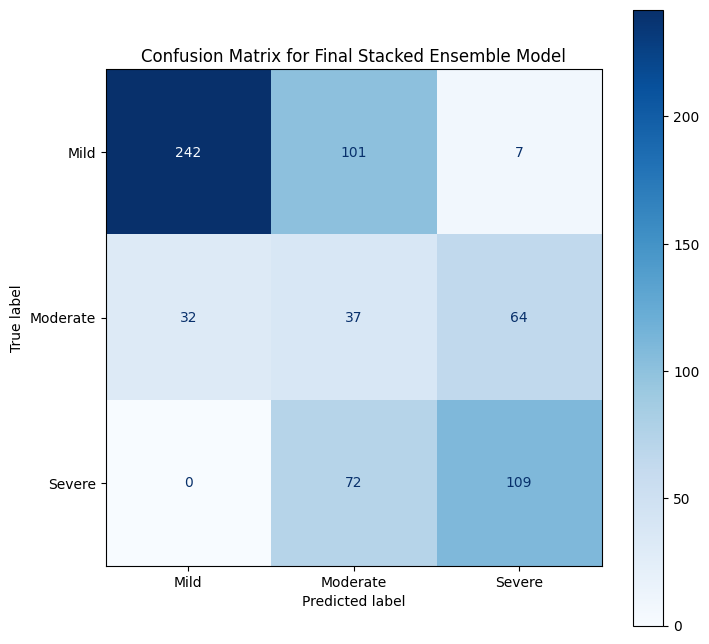

In [10]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
from torchvision import models
import xgboost as xgb
import timm

# --- 1. CONFIGURATION ---
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 3
BATCH_SIZE = 32
NUM_EPOCHS_CNN = 25
PATIENCE_CNN = 7
INITIAL_LR = 1e-4

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- 3. DATA LOADING & BALANCING SETUP ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"Proyojoniyo input file-ti paowa jayni: {INPUT_PICKLE_PATH}")
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['radiological_evaluation'].value_counts().sort_index().to_dict()
    main_task_labels_for_weighting = (train_df['radiological_evaluation'] - 1).values
    
    sample_weights_dict = {
        1: len(train_df) / class_counts.get(1, 1e-6),
        2: len(train_df) / class_counts.get(2, 1e-6),
        3: len(train_df) / class_counts.get(3, 1e-6)
    }
    sample_weights = np.array([sample_weights_dict[t] for t in train_df['radiological_evaluation'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    
    class_weights_loss = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=main_task_labels_for_weighting), dtype=torch.float).to(device)
    print(f"Class weights for loss function: {class_weights_loss}")
    
    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASETS AND AUGMENTATIONS ---
if data_loaded:
    # Augmentations for RGB images
    strong_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
        A.GaussNoise(var_limit=(10.0, 60.0), p=0.5),
        A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    # Augmentations for 2-channel mask images (geometric only)
    mask_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75),
        ToTensorV2()
    ])

    # --- Datasets for each Expert ---
    class GlobalDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            image = self.transform(image=row['original_image'])['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

    class LocalDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            image, mask = row['original_image'], row['predicted_mask']
            crop = image
            try:
                if mask is not None and mask.max() > 0:
                    bbox = find_objects(mask)
                    if bbox:
                        sy, sx = bbox[0]
                        if sy.stop > sy.start and sx.stop > sx.start: crop = image[sy.start:sy.stop, sx.start:sx.stop]
            except: pass
            image = self.transform(image=crop)['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

    class MaskDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            gt_mask = (row['ground_truth_mask'] > 0).astype(np.uint8) * 255
            pred_mask = (row['predicted_mask'] > 0).astype(np.uint8) * 255
            stacked = np.stack([gt_mask, pred_mask], axis=-1)
            image = self.transform(image=stacked)['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

# --- 5. HELPER FUNCTIONS FOR TRAINING & PREDICTION ---
def train_expert_model(model, model_name, train_loader, val_loader):
    print(f"\n--- Training Expert: {model_name} ---")
    criterion = nn.CrossEntropyLoss(weight=class_weights_loss, label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-6)
    best_acc = 0.0
    epochs_no_improve = 0
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS_CNN):
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Train Ep {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        scheduler.step()

        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Val Ep {epoch+1}"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Epoch {epoch+1} Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'best_expert_{model_name}.pth')
            epochs_no_improve = 0
            print(f"  -> New best model saved!")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= PATIENCE_CNN:
            print("  -> Early stopping.")
            break
    
    model.load_state_dict(torch.load(f'best_expert_{model_name}.pth'))
    return model

def get_expert_predictions(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for images, _ in tqdm(loader, desc="Getting Predictions"):
            images = images.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
            preds.append(F.softmax(outputs, dim=1).cpu().numpy())
    return np.concatenate(preds, axis=0)

# --- 6. PHASE 1: Train All Expert Models ---
if data_loaded:
    successful_experts = {}
    
    # --- Expert A: Global (ResNet34) ---
    try:
        train_loader_global = DataLoader(GlobalDataset(train_df, strong_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_global = DataLoader(GlobalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_global = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        model_global.fc = nn.Linear(model_global.fc.in_features, NUM_CLASSES)
        model_global = train_expert_model(model_global.to(device), "Global_ResNet34", train_loader_global, val_loader_global)
        successful_experts['global'] = model_global
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert A (Global_ResNet34): {e} !!!!!!!!")

    # --- Expert B: Local (DenseNet121) ---
    try:
        train_loader_local = DataLoader(LocalDataset(train_df, strong_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_local = DataLoader(LocalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_local_densenet = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        model_local_densenet.classifier = nn.Linear(model_local_densenet.classifier.in_features, NUM_CLASSES)
        model_local_densenet = train_expert_model(model_local_densenet.to(device), "Local_DenseNet121", train_loader_local, val_loader_local)
        successful_experts['local_densenet'] = model_local_densenet
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert B (Local_DenseNet121): {e} !!!!!!!!")

    # --- NEW Expert D: Local (EfficientNet-B0) ---
    try:
        # We can reuse the same dataloader as they use the same dataset type
        model_local_effnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=NUM_CLASSES)
        model_local_effnet = train_expert_model(model_local_effnet.to(device), "Local_EffNetB0", train_loader_local, val_loader_local)
        successful_experts['local_effnet'] = model_local_effnet
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert D (Local_EffNetB0): {e} !!!!!!!!")
        
    # --- Expert C: Mask Comparison (ResNet50) ---
    try:
        train_loader_mask = DataLoader(MaskDataset(train_df, mask_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_mask = DataLoader(MaskDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_mask = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        orig_weights = model_mask.conv1.weight.clone()
        new_weights = orig_weights.sum(dim=1, keepdim=True).repeat(1,2,1,1) / 3
        model_mask.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model_mask.conv1.weight.data = new_weights
        model_mask.fc = nn.Linear(model_mask.fc.in_features, NUM_CLASSES)
        model_mask = train_expert_model(model_mask.to(device), "Mask_ResNet50", train_loader_mask, val_loader_mask)
        successful_experts['mask'] = model_mask
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert C (Mask_ResNet50): {e} !!!!!!!!")

# --- 7. PHASE 2: Create Meta-Dataset and Train XGBoost ---
if 'successful_experts' in locals() and successful_experts:
    print("\n--- Creating Meta-Dataset from successfully trained experts ---")
    
    meta_features_train, meta_features_val, meta_features_test = [], [], []

    # --- Helper function for getting predictions to avoid code repetition ---
    def get_and_append_predictions(expert_name, expert_model, train_df, val_df, test_df, dataset_class, aug):
        if expert_name in successful_experts:
            print(f"Getting predictions from: {expert_name}")
            train_loader = DataLoader(dataset_class(train_df, aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
            val_loader = DataLoader(dataset_class(val_df, aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
            test_loader = DataLoader(dataset_class(test_df, aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
            
            meta_features_train.append(get_expert_predictions(expert_model, train_loader))
            meta_features_val.append(get_expert_predictions(expert_model, val_loader))
            meta_features_test.append(get_expert_predictions(expert_model, test_loader))

    get_and_append_predictions('global', successful_experts.get('global'), train_df, val_df, test_df, GlobalDataset, eval_aug)
    get_and_append_predictions('local_densenet', successful_experts.get('local_densenet'), train_df, val_df, test_df, LocalDataset, eval_aug)
    get_and_append_predictions('local_effnet', successful_experts.get('local_effnet'), train_df, val_df, test_df, LocalDataset, eval_aug)
    get_and_append_predictions('mask', successful_experts.get('mask'), train_df, val_df, test_df, MaskDataset, eval_aug)

    # Combine predictions to form meta-dataset
    X_train_meta = np.hstack(meta_features_train)
    X_val_meta = np.hstack(meta_features_val)
    X_test_meta = np.hstack(meta_features_test)

    y_train_meta = (train_df['radiological_evaluation'] - 1).values
    y_val_meta = (val_df['radiological_evaluation'] - 1).values
    y_test_meta = (test_df['radiological_evaluation'] - 1).values
    
    print(f"Meta-dataset created. Train shape: {X_train_meta.shape}")

    # --- Train XGBoost Manager ---
    print("\n--- Training Manager Model (XGBoost) ---")
    from sklearn.utils.class_weight import compute_sample_weight
    sample_weights_xgb = compute_sample_weight(class_weight='balanced', y=y_train_meta)
    
    xgb_manager = xgb.XGBClassifier(
        objective='multi:softmax', num_class=NUM_CLASSES, use_label_encoder=False,
        eval_metric='mlogloss', n_estimators=500, learning_rate=0.05,
        max_depth=4, subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=50
    )

    xgb_manager.fit(X_train_meta, y_train_meta,
                    sample_weight=sample_weights_xgb,
                    eval_set=[(X_val_meta, y_val_meta)],
                    verbose=100)
    
    print("\n--- Manager Training Complete ---")

    # --- 8. FINAL EVALUATION ---
    print("\n" + "="*80)
    print("--- FINAL STACKED ENSEMBLE TEST EVALUATION ---")
    print("="*80)

    y_pred_meta = xgb_manager.predict(X_test_meta)
    
    print("\n--- FINAL CLASSIFICATION REPORT ---")
    report_dict = classification_report(y_test_meta, y_pred_meta, target_names=class_names, zero_division=0, output_dict=True)
    print(classification_report(y_test_meta, y_pred_meta, target_names=class_names, zero_division=0))
    
    print("\n--- Individual Class Metrics ---")
    for i, class_name in enumerate(class_names):
        metrics = report_dict.get(class_name, {})
        print(f"--- Class: {class_name} (Original Label: {i+1}) ---")
        print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
        print(f"  Precision:         {metrics.get('precision', 0):.4f}")
        print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test_meta, y_pred_meta, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Final Stacked Ensemble Model")
    plt.show()

else:
    print("\nNo expert models were trained successfully. Cannot proceed to stacking.")



Using device: cuda ⚙️

--- Loading Pre-processed Data from Pickle File ---
Loaded data: 5364 train, 674 val, 664 test.

Setting up data balancing for training...
Class weights for loss function: tensor([0.8206, 0.8642, 1.6022], device='cuda:0')


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_112/1790441739.py:84: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 60.0), p=0.5),
/tmp/ipykernel_112/1790441739.py:85: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
/tmp/ipykernel_112/1790441739.py:150: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



--- Training Expert: Global_ResNet34 ---


Train Ep 1:   0%|          | 0/167 [00:00<?, ?it/s]/tmp/ipykernel_112/1790441739.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val Ep 1:   0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_112/1790441739.py:170: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Val Ep 1: 100%|██████████| 11/11 [00:01<00:00,  6.11it/s]


Epoch 1 Val Acc: 0.6499
  -> New best model saved!


Val Ep 2: 100%|██████████| 11/11 [00:01<00:00,  6.05it/s]


Epoch 2 Val Acc: 0.7181
  -> New best model saved!


Val Ep 3: 100%|██████████| 11/11 [00:01<00:00,  6.13it/s]


Epoch 3 Val Acc: 0.7226
  -> New best model saved!


Val Ep 4: 100%|██████████| 11/11 [00:01<00:00,  6.16it/s]


Epoch 4 Val Acc: 0.7285
  -> New best model saved!


Val Ep 5: 100%|██████████| 11/11 [00:01<00:00,  6.03it/s]


Epoch 5 Val Acc: 0.7611
  -> New best model saved!


Val Ep 6: 100%|██████████| 11/11 [00:01<00:00,  6.21it/s]


Epoch 6 Val Acc: 0.7404


Val Ep 7: 100%|██████████| 11/11 [00:01<00:00,  6.08it/s]


Epoch 7 Val Acc: 0.7463


Val Ep 8: 100%|██████████| 11/11 [00:01<00:00,  6.09it/s]


Epoch 8 Val Acc: 0.7315


Val Ep 9: 100%|██████████| 11/11 [00:01<00:00,  6.11it/s]


Epoch 9 Val Acc: 0.7389


Val Ep 10: 100%|██████████| 11/11 [00:01<00:00,  6.10it/s]


Epoch 10 Val Acc: 0.7463


Val Ep 11: 100%|██████████| 11/11 [00:01<00:00,  6.13it/s]


Epoch 11 Val Acc: 0.7478


Val Ep 12: 100%|██████████| 11/11 [00:01<00:00,  6.04it/s]


Epoch 12 Val Acc: 0.6617
  -> Early stopping.

--- Training Expert: Local_DenseNet121 ---


Val Ep 1: 100%|██████████| 11/11 [00:02<00:00,  4.76it/s]


Epoch 1 Val Acc: 0.4288
  -> New best model saved!


Val Ep 2: 100%|██████████| 11/11 [00:02<00:00,  4.77it/s]


Epoch 2 Val Acc: 0.4718
  -> New best model saved!


Val Ep 3: 100%|██████████| 11/11 [00:02<00:00,  4.80it/s]


Epoch 3 Val Acc: 0.4955
  -> New best model saved!


Val Ep 4: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]


Epoch 4 Val Acc: 0.4228


Val Ep 5: 100%|██████████| 11/11 [00:02<00:00,  4.79it/s]


Epoch 5 Val Acc: 0.4970
  -> New best model saved!


Val Ep 6: 100%|██████████| 11/11 [00:02<00:00,  4.77it/s]


Epoch 6 Val Acc: 0.4659


Val Ep 7: 100%|██████████| 11/11 [00:02<00:00,  4.77it/s]


Epoch 7 Val Acc: 0.5208
  -> New best model saved!


Val Ep 8: 100%|██████████| 11/11 [00:02<00:00,  4.75it/s]


Epoch 8 Val Acc: 0.5104


Val Ep 9: 100%|██████████| 11/11 [00:02<00:00,  4.75it/s]


Epoch 9 Val Acc: 0.4777


Val Ep 10: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]


Epoch 10 Val Acc: 0.5015


Val Ep 11: 100%|██████████| 11/11 [00:02<00:00,  4.75it/s]


Epoch 11 Val Acc: 0.4807


Val Ep 12: 100%|██████████| 11/11 [00:02<00:00,  4.76it/s]


Epoch 12 Val Acc: 0.4644


Val Ep 13: 100%|██████████| 11/11 [00:02<00:00,  4.77it/s]


Epoch 13 Val Acc: 0.4911


Val Ep 14: 100%|██████████| 11/11 [00:02<00:00,  4.77it/s]


Epoch 14 Val Acc: 0.4970
  -> Early stopping.

--- Training Expert: Local_EffNetB0 ---


Val Ep 1: 100%|██████████| 11/11 [00:01<00:00,  5.81it/s]


Epoch 1 Val Acc: 0.4036
  -> New best model saved!


Val Ep 2: 100%|██████████| 11/11 [00:01<00:00,  5.84it/s]


Epoch 2 Val Acc: 0.3605


Val Ep 3: 100%|██████████| 11/11 [00:01<00:00,  5.91it/s]


Epoch 3 Val Acc: 0.4199
  -> New best model saved!


Val Ep 4: 100%|██████████| 11/11 [00:01<00:00,  5.89it/s]


Epoch 4 Val Acc: 0.4674
  -> New best model saved!


Val Ep 5: 100%|██████████| 11/11 [00:01<00:00,  5.70it/s]


Epoch 5 Val Acc: 0.3976


Val Ep 6: 100%|██████████| 11/11 [00:01<00:00,  5.81it/s]


Epoch 6 Val Acc: 0.4703
  -> New best model saved!


Val Ep 7: 100%|██████████| 11/11 [00:01<00:00,  6.01it/s]


Epoch 7 Val Acc: 0.4674


Val Ep 8: 100%|██████████| 11/11 [00:01<00:00,  5.83it/s]


Epoch 8 Val Acc: 0.4718
  -> New best model saved!


Val Ep 9: 100%|██████████| 11/11 [00:01<00:00,  5.90it/s]


Epoch 9 Val Acc: 0.4555


Val Ep 10: 100%|██████████| 11/11 [00:01<00:00,  5.96it/s]


Epoch 10 Val Acc: 0.4481


Val Ep 11: 100%|██████████| 11/11 [00:01<00:00,  5.86it/s]


Epoch 11 Val Acc: 0.4614


Val Ep 12: 100%|██████████| 11/11 [00:01<00:00,  5.95it/s]


Epoch 12 Val Acc: 0.4525


Val Ep 13: 100%|██████████| 11/11 [00:01<00:00,  6.04it/s]


Epoch 13 Val Acc: 0.4733
  -> New best model saved!


Val Ep 14: 100%|██████████| 11/11 [00:01<00:00,  5.91it/s]


Epoch 14 Val Acc: 0.5430
  -> New best model saved!


Val Ep 15: 100%|██████████| 11/11 [00:01<00:00,  5.76it/s]


Epoch 15 Val Acc: 0.4748


Val Ep 16: 100%|██████████| 11/11 [00:01<00:00,  5.73it/s]


Epoch 16 Val Acc: 0.5045


Val Ep 17: 100%|██████████| 11/11 [00:01<00:00,  5.59it/s]


Epoch 17 Val Acc: 0.5475
  -> New best model saved!


Val Ep 18: 100%|██████████| 11/11 [00:01<00:00,  5.68it/s]


Epoch 18 Val Acc: 0.5252


Val Ep 19: 100%|██████████| 11/11 [00:01<00:00,  5.85it/s]


Epoch 19 Val Acc: 0.5163


Val Ep 20: 100%|██████████| 11/11 [00:01<00:00,  5.88it/s]


Epoch 20 Val Acc: 0.5208


Val Ep 21: 100%|██████████| 11/11 [00:01<00:00,  5.96it/s]


Epoch 21 Val Acc: 0.5134


Val Ep 22: 100%|██████████| 11/11 [00:01<00:00,  5.82it/s]


Epoch 22 Val Acc: 0.5312


Val Ep 23: 100%|██████████| 11/11 [00:01<00:00,  5.90it/s]


Epoch 23 Val Acc: 0.5252


Val Ep 24: 100%|██████████| 11/11 [00:01<00:00,  5.96it/s]


Epoch 24 Val Acc: 0.5237
  -> Early stopping.

--- Training Expert: Mask_ResNet50 ---


Train Ep 1:   0%|          | 0/167 [00:00<?, ?it/s]


!!!!!!!! FAILED to train Expert C (Mask_ResNet50): Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_112/1790441739.py", line 137, in __getitem__
    stacked = np.stack([gt_mask, pred_mask], axis=-1)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dis

Getting Predictions:   0%|          | 0/84 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c1ee80e8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x79c1ee80e8e0>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    if w.is_alive():    
self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():  
    ^ ^ ^^ ^ ^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(),

Getting predictions from: local_densenet


Getting Predictions: 100%|██████████| 11/11 [00:02<00:00,  4.46it/s]


Getting predictions from: local_effnet


Getting Predictions: 100%|██████████| 11/11 [00:01<00:00,  5.72it/s]

Meta-dataset created. Train shape: (5364, 9)

--- Training Manager Model (XGBoost) ---
[0]	validation_0-mlogloss:1.05676



/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [13:14:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[94]	validation_0-mlogloss:0.66145

--- Manager Training Complete ---

--- FINAL STACKED ENSEMBLE TEST EVALUATION ---

--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        Mild       0.86      0.72      0.79       350
    Moderate       0.14      0.20      0.16       133
      Severe       0.59      0.59      0.59       181

    accuracy                           0.58       664
   macro avg       0.53      0.50      0.51       664
weighted avg       0.64      0.58      0.61       664


--- Individual Class Metrics ---
--- Class: Mild (Original Label: 1) ---
  Accuracy (Recall): 0.7200
  Precision:         0.8630
  F1-Score:          0.7850
--- Class: Moderate (Original Label: 2) ---
  Accuracy (Recall): 0.1955
  Precision:         0.1361
  F1-Score:          0.1605
--- Class: Severe (Original Label: 3) ---
  Accuracy (Recall): 0.5912
  Precision:         0.5912
  F1-Score:          0.5912

--- Confusion Matrix ---


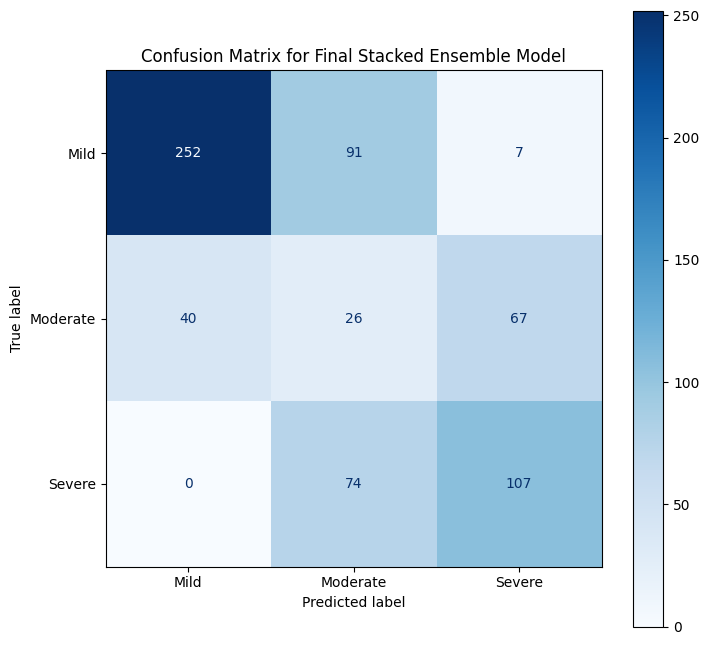

In [11]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
from torchvision import models
import xgboost as xgb
import timm

# --- 1. CONFIGURATION ---
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 3
BATCH_SIZE = 32
NUM_EPOCHS_CNN = 25
PATIENCE_CNN = 7
INITIAL_LR = 1e-4

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- 3. DATA LOADING & BALANCING SETUP ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"Proyojoniyo input file-ti paowa jayni: {INPUT_PICKLE_PATH}")
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['radiological_evaluation'].value_counts().sort_index().to_dict()
    main_task_labels_for_weighting = (train_df['radiological_evaluation'] - 1).values
    
    sample_weights_dict = {
        1: len(train_df) / class_counts.get(1, 1e-6),
        2: len(train_df) / class_counts.get(2, 1e-6),
        3: len(train_df) / class_counts.get(3, 1e-6)
    }
    sample_weights = np.array([sample_weights_dict[t] for t in train_df['radiological_evaluation'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    
    class_weights_loss = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=main_task_labels_for_weighting), dtype=torch.float).to(device)
    print(f"Class weights for loss function: {class_weights_loss}")
    
    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASETS AND AUGMENTATIONS ---
if data_loaded:
    # Augmentations for RGB images
    strong_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
        A.GaussNoise(var_limit=(10.0, 60.0), p=0.5),
        A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    # Augmentations for 2-channel mask images (geometric only)
    mask_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75),
        ToTensorV2()
    ])

    # --- Datasets for each Expert ---
    class GlobalDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            image = self.transform(image=row['original_image'])['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

    class LocalDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            image, mask = row['original_image'], row['predicted_mask']
            crop = image
            try:
                if mask is not None and mask.max() > 0:
                    bbox = find_objects(mask)
                    if bbox:
                        sy, sx = bbox[0]
                        if sy.stop > sy.start and sx.stop > sx.start: crop = image[sy.start:sy.stop, sx.start:sx.stop]
            except: pass
            image = self.transform(image=crop)['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

    class MaskDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            gt_mask = (row['ground_truth_mask'] > 0).astype(np.uint8) * 255
            pred_mask = (row['predicted_mask'] > 0).astype(np.uint8) * 255
            stacked = np.stack([gt_mask, pred_mask], axis=-1)
            image = self.transform(image=stacked)['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

# --- 5. HELPER FUNCTIONS FOR TRAINING & PREDICTION ---
def train_expert_model(model, model_name, train_loader, val_loader):
    print(f"\n--- Training Expert: {model_name} ---")
    criterion = nn.CrossEntropyLoss(weight=class_weights_loss, label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-6)
    best_acc = 0.0
    epochs_no_improve = 0
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS_CNN):
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Train Ep {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        scheduler.step()

        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Val Ep {epoch+1}"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Epoch {epoch+1} Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'best_expert_{model_name}.pth')
            epochs_no_improve = 0
            print(f"  -> New best model saved!")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= PATIENCE_CNN:
            print("  -> Early stopping.")
            break
    
    model.load_state_dict(torch.load(f'best_expert_{model_name}.pth'))
    return model

def get_expert_predictions(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for images, _ in tqdm(loader, desc="Getting Predictions"):
            images = images.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
            preds.append(F.softmax(outputs, dim=1).cpu().numpy())
    return np.concatenate(preds, axis=0)

# --- 6. PHASE 1: Train All Expert Models ---
if data_loaded:
    successful_experts = {}
    
    # --- Expert A: Global (ResNet34) ---
    try:
        train_loader_global = DataLoader(GlobalDataset(train_df, strong_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_global = DataLoader(GlobalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_global = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        model_global.fc = nn.Linear(model_global.fc.in_features, NUM_CLASSES)
        model_global = train_expert_model(model_global.to(device), "Global_ResNet34", train_loader_global, val_loader_global)
        successful_experts['global'] = model_global
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert A (Global_ResNet34): {e} !!!!!!!!")

    # --- Expert B: Local (DenseNet121) ---
    try:
        train_loader_local = DataLoader(LocalDataset(train_df, strong_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_local = DataLoader(LocalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_local_densenet = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        model_local_densenet.classifier = nn.Linear(model_local_densenet.classifier.in_features, NUM_CLASSES)
        model_local_densenet = train_expert_model(model_local_densenet.to(device), "Local_DenseNet121", train_loader_local, val_loader_local)
        successful_experts['local_densenet'] = model_local_densenet
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert B (Local_DenseNet121): {e} !!!!!!!!")

    # --- NEW Expert D: Local (EfficientNet-B0) ---
    try:
        # We can reuse the same dataloader as they use the same dataset type
        model_local_effnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=NUM_CLASSES)
        model_local_effnet = train_expert_model(model_local_effnet.to(device), "Local_EffNetB0", train_loader_local, val_loader_local)
        successful_experts['local_effnet'] = model_local_effnet
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert D (Local_EffNetB0): {e} !!!!!!!!")
        
    # --- Expert C: Mask Comparison (ResNet50) ---
    try:
        train_loader_mask = DataLoader(MaskDataset(train_df, mask_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_mask = DataLoader(MaskDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_mask = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        orig_weights = model_mask.conv1.weight.clone()
        new_weights = orig_weights.sum(dim=1, keepdim=True).repeat(1,2,1,1) / 3
        model_mask.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model_mask.conv1.weight.data = new_weights
        model_mask.fc = nn.Linear(model_mask.fc.in_features, NUM_CLASSES)
        model_mask = train_expert_model(model_mask.to(device), "Mask_ResNet50", train_loader_mask, val_loader_mask)
        successful_experts['mask'] = model_mask
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert C (Mask_ResNet50): {e} !!!!!!!!")

# --- 7. PHASE 2: Create Meta-Dataset and Train XGBoost ---
if 'successful_experts' in locals() and successful_experts:
    print("\n--- Creating Meta-Dataset from successfully trained experts ---")
    
    meta_features_train, meta_features_val, meta_features_test = [], [], []

    # --- Helper function for getting predictions to avoid code repetition ---
    def get_and_append_predictions(expert_name, expert_model, train_df, val_df, test_df, dataset_class, aug):
        if expert_name in successful_experts:
            print(f"Getting predictions from: {expert_name}")
            train_loader = DataLoader(dataset_class(train_df, aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
            val_loader = DataLoader(dataset_class(val_df, aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
            test_loader = DataLoader(dataset_class(test_df, aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
            
            meta_features_train.append(get_expert_predictions(expert_model, train_loader))
            meta_features_val.append(get_expert_predictions(expert_model, val_loader))
            meta_features_test.append(get_expert_predictions(expert_model, test_loader))

    get_and_append_predictions('global', successful_experts.get('global'), train_df, val_df, test_df, GlobalDataset, eval_aug)
    get_and_append_predictions('local_densenet', successful_experts.get('local_densenet'), train_df, val_df, test_df, LocalDataset, eval_aug)
    get_and_append_predictions('local_effnet', successful_experts.get('local_effnet'), train_df, val_df, test_df, LocalDataset, eval_aug)
    get_and_append_predictions('mask', successful_experts.get('mask'), train_df, val_df, test_df, MaskDataset, eval_aug)

    # Combine predictions to form meta-dataset
    X_train_meta = np.hstack(meta_features_train)
    X_val_meta = np.hstack(meta_features_val)
    X_test_meta = np.hstack(meta_features_test)

    y_train_meta = (train_df['radiological_evaluation'] - 1).values
    y_val_meta = (val_df['radiological_evaluation'] - 1).values
    y_test_meta = (test_df['radiological_evaluation'] - 1).values
    
    print(f"Meta-dataset created. Train shape: {X_train_meta.shape}")

    # --- Train XGBoost Manager ---
    print("\n--- Training Manager Model (XGBoost) ---")
    from sklearn.utils.class_weight import compute_sample_weight
    sample_weights_xgb = compute_sample_weight(class_weight='balanced', y=y_train_meta)
    
    xgb_manager = xgb.XGBClassifier(
        objective='multi:softmax', num_class=NUM_CLASSES, use_label_encoder=False,
        eval_metric='mlogloss', n_estimators=500, learning_rate=0.05,
        max_depth=4, subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=50
    )

    xgb_manager.fit(X_train_meta, y_train_meta,
                    sample_weight=sample_weights_xgb,
                    eval_set=[(X_val_meta, y_val_meta)],
                    verbose=100)
    
    print("\n--- Manager Training Complete ---")

    # --- 8. FINAL EVALUATION ---
    print("\n" + "="*80)
    print("--- FINAL STACKED ENSEMBLE TEST EVALUATION ---")
    print("="*80)

    y_pred_meta = xgb_manager.predict(X_test_meta)
    
    print("\n--- FINAL CLASSIFICATION REPORT ---")
    report_dict = classification_report(y_test_meta, y_pred_meta, target_names=class_names, zero_division=0, output_dict=True)
    print(classification_report(y_test_meta, y_pred_meta, target_names=class_names, zero_division=0))
    
    print("\n--- Individual Class Metrics ---")
    for i, class_name in enumerate(class_names):
        metrics = report_dict.get(class_name, {})
        print(f"--- Class: {class_name} (Original Label: {i+1}) ---")
        print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
        print(f"  Precision:         {metrics.get('precision', 0):.4f}")
        print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test_meta, y_pred_meta, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Final Stacked Ensemble Model")
    plt.show()

else:
    print("\nNo expert models were trained successfully. Cannot proceed to stacking.")



In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
from torchvision import models
import xgboost as xgb
import timm

# --- 1. CONFIGURATION ---
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 3
BATCH_SIZE = 32
NUM_EPOCHS_CNN = 25
PATIENCE_CNN = 7
INITIAL_LR = 1e-4

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- 3. DATA LOADING & BALANCING SETUP ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"Proyojoniyo input file-ti paowa jayni: {INPUT_PICKLE_PATH}")
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['radiological_evaluation'].value_counts().sort_index().to_dict()
    main_task_labels_for_weighting = (train_df['radiological_evaluation'] - 1).values
    
    sample_weights_dict = {
        1: len(train_df) / class_counts.get(1, 1e-6),
        2: len(train_df) / class_counts.get(2, 1e-6),
        3: len(train_df) / class_counts.get(3, 1e-6)
    }
    sample_weights = np.array([sample_weights_dict[t] for t in train_df['radiological_evaluation'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    
    class_weights_loss = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=main_task_labels_for_weighting), dtype=torch.float).to(device)
    print(f"Class weights for loss function: {class_weights_loss}")
    
    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASETS AND AUGMENTATIONS ---
if data_loaded:
    # Augmentations
    strong_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]), A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5), A.RandomBrightnessContrast(p=0.5),
        A.GaussNoise(p=0.3), A.ElasticTransform(p=0.3), A.CoarseDropout(p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()
    ])
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()
    ])
    mask_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]), A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5), A.ElasticTransform(p=0.3), ToTensorV2()
    ])

    # Datasets for each expert
    class GlobalDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            image = self.transform(image=row['original_image'])['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

    class LocalDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            image, mask = row['original_image'], row['predicted_mask']
            crop = image
            try:
                if mask is not None and mask.max() > 0:
                    bbox = find_objects(mask)
                    if bbox:
                        sy, sx = bbox[0]
                        if sy.stop > sy.start and sx.stop > sx.start: crop = image[sy.start:sy.stop, sx.start:sx.stop]
            except: pass
            image = self.transform(image=crop)['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

    class MaskDataset(Dataset):
        def __init__(self, dataframe, transform): self.df, self.transform = dataframe, transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            gt_mask = (row['ground_truth_mask'] > 0).astype(np.uint8) * 255
            pred_mask = (row['predicted_mask'] > 0).astype(np.uint8) * 255
            stacked = np.stack([gt_mask, pred_mask], axis=-1)
            image = self.transform(image=stacked)['image']
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            return image, label

# --- 5. HELPER FUNCTIONS FOR TRAINING & PREDICTION ---
def train_expert_model(model, model_name, train_loader, val_loader):
    print(f"\n--- Training Expert: {model_name} ---")
    criterion = nn.CrossEntropyLoss(weight=class_weights_loss)
    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-6)
    best_acc = 0.0
    epochs_no_improve = 0
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS_CNN):
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Train Ep {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        scheduler.step()

        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Val Ep {epoch+1}"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Epoch {epoch+1} Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'best_expert_{model_name}.pth')
            epochs_no_improve = 0
            print(f"  -> New best model saved!")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= PATIENCE_CNN:
            print("  -> Early stopping.")
            break
    
    model.load_state_dict(torch.load(f'best_expert_{model_name}.pth'))
    return model

def get_expert_predictions(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for images, _ in tqdm(loader, desc="Getting Predictions"):
            images = images.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
            preds.append(F.softmax(outputs, dim=1).cpu().numpy())
    return np.concatenate(preds, axis=0)

# --- 6. PHASE 1: Train All Expert Models ---
if data_loaded:
    successful_experts = {}
    
    # --- Expert A: Global (ResNet34) ---
    try:
        train_loader_global = DataLoader(GlobalDataset(train_df, strong_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_global = DataLoader(GlobalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_global = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        model_global.fc = nn.Linear(model_global.fc.in_features, NUM_CLASSES)
        model_global = train_expert_model(model_global.to(device), "Global_ResNet34", train_loader_global, val_loader_global)
        successful_experts['global'] = model_global
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert A (Global_ResNet34): {e} !!!!!!!!")

    # --- Expert B: Local (EfficientNet-B0) ---
    try:
        train_loader_local = DataLoader(LocalDataset(train_df, strong_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_local = DataLoader(LocalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_local = timm.create_model('efficientnet_b0', pretrained=True, num_classes=NUM_CLASSES)
        model_local = train_expert_model(model_local.to(device), "Local_EffNetB0", train_loader_local, val_loader_local)
        successful_experts['local'] = model_local
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert B (Local_EffNetB0): {e} !!!!!!!!")

    # --- Expert C: Mask Comparison (ResNet50) ---
    try:
        train_loader_mask = DataLoader(MaskDataset(train_df, mask_aug), batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
        val_loader_mask = DataLoader(MaskDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        model_mask = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        orig_weights = model_mask.conv1.weight.clone()
        new_weights = orig_weights.sum(dim=1, keepdim=True).repeat(1,2,1,1) / 3
        model_mask.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model_mask.conv1.weight.data = new_weights
        model_mask.fc = nn.Linear(model_mask.fc.in_features, NUM_CLASSES)
        model_mask = train_expert_model(model_mask.to(device), "Mask_ResNet50", train_loader_mask, val_loader_mask)
        successful_experts['mask'] = model_mask
    except Exception as e:
        print(f"!!!!!!!! FAILED to train Expert C (Mask_ResNet50): {e} !!!!!!!!")
    
# --- 7. PHASE 2: Create Meta-Dataset and Train XGBoost ---
if 'successful_experts' in locals() and successful_experts:
    print("\n--- Creating Meta-Dataset from successfully trained experts ---")
    
    meta_features_train, meta_features_val, meta_features_test = [], [], []

    if 'global' in successful_experts:
        print("Getting predictions from: Global_ResNet34")
        train_loader_pred = DataLoader(GlobalDataset(train_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        val_loader_pred = DataLoader(GlobalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        test_loader_pred = DataLoader(GlobalDataset(test_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        meta_features_train.append(get_expert_predictions(successful_experts['global'], train_loader_pred))
        meta_features_val.append(get_expert_predictions(successful_experts['global'], val_loader_pred))
        meta_features_test.append(get_expert_predictions(successful_experts['global'], test_loader_pred))

    if 'local' in successful_experts:
        print("Getting predictions from: Local_EffNetB0")
        train_loader_pred = DataLoader(LocalDataset(train_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        val_loader_pred = DataLoader(LocalDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        test_loader_pred = DataLoader(LocalDataset(test_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        meta_features_train.append(get_expert_predictions(successful_experts['local'], train_loader_pred))
        meta_features_val.append(get_expert_predictions(successful_experts['local'], val_loader_pred))
        meta_features_test.append(get_expert_predictions(successful_experts['local'], test_loader_pred))
        
    if 'mask' in successful_experts:
        print("Getting predictions from: Mask_ResNet50")
        train_loader_pred = DataLoader(MaskDataset(train_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        val_loader_pred = DataLoader(MaskDataset(val_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        test_loader_pred = DataLoader(MaskDataset(test_df, eval_aug), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2)
        meta_features_train.append(get_expert_predictions(successful_experts['mask'], train_loader_pred))
        meta_features_val.append(get_expert_predictions(successful_experts['mask'], val_loader_pred))
        meta_features_test.append(get_expert_predictions(successful_experts['mask'], test_loader_pred))

    # Combine predictions to form meta-dataset
    X_train_meta = np.hstack(meta_features_train)
    X_val_meta = np.hstack(meta_features_val)
    X_test_meta = np.hstack(meta_features_test)

    y_train_meta = (train_df['radiological_evaluation'] - 1).values
    y_val_meta = (val_df['radiological_evaluation'] - 1).values
    y_test_meta = (test_df['radiological_evaluation'] - 1).values
    
    print(f"Meta-dataset created. Train shape: {X_train_meta.shape}")

    # --- Train XGBoost Manager ---
    print("\n--- Training Manager Model (XGBoost) ---")
    from sklearn.utils.class_weight import compute_sample_weight
    sample_weights_xgb = compute_sample_weight(class_weight='balanced', y=y_train_meta)
    
    xgb_manager = xgb.XGBClassifier(
        objective='multi:softmax', num_class=NUM_CLASSES, use_label_encoder=False,
        eval_metric='mlogloss', n_estimators=500, learning_rate=0.05,
        max_depth=4, subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=50
    )

    xgb_manager.fit(X_train_meta, y_train_meta,
                    sample_weight=sample_weights_xgb,
                    eval_set=[(X_val_meta, y_val_meta)],
                    verbose=100)
    
    print("\n--- Manager Training Complete ---")

    # --- 8. FINAL EVALUATION ---
    print("\n" + "="*80)
    print("--- FINAL STACKED ENSEMBLE TEST EVALUATION ---")
    print("="*80)

    y_pred_meta = xgb_manager.predict(X_test_meta)
    
    print("\n--- FINAL CLASSIFICATION REPORT ---")
    report_dict = classification_report(y_test_meta, y_pred_meta, target_names=class_names, zero_division=0, output_dict=True)
    print(classification_report(y_test_meta, y_pred_meta, target_names=class_names, zero_division=0))
    
    print("\n--- Individual Class Metrics ---")
    for i, class_name in enumerate(class_names):
        metrics = report_dict.get(class_name, {})
        print(f"--- Class: {class_name} (Original Label: {i+1}) ---")
        print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
        print(f"  Precision:         {metrics.get('precision', 0):.4f}")
        print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test_meta, y_pred_meta, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Final Stacked Ensemble Model")
    plt.show()

else:
    print("\nNo expert models were trained successfully. Cannot proceed to stacking.")



In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
from torchvision import models

# --- 1. CONFIGURATION ---
# Ei pickle file-ti apnar data generation script theke toiri
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224) # VGG16 ei size-e pre-trained
NUM_MAIN_CLASSES = 3
NUM_AUX_CLASSES = 2 # Binary (e.g., Mild vs Not-Mild)
BATCH_SIZE = 16 # VGG16 ektu boro, tai batch size kom rakha bhalo
NUM_EPOCHS = 50
PATIENCE = 10
INITIAL_LR = 1e-5 # Fine-tuning er jonno ektu kom LR
ETA_MIN_LR = 1e-6
T_0_EPOCHS = 10

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")
print(f"PyTorch version: {torch.__version__}")

# --- 3. DATA LOADING AND PREPARATION ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"Proyojoniyo input file-ti paowa jayni: {INPUT_PICKLE_PATH}\nPlease run 'generate_image_dataset.py' first.")
        
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("Pickle file theke load korar por ek ba ekadhik data split khali.")
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['radiological_evaluation'].value_counts().sort_index().to_dict()
    print(f"Training Class Counts (Labels 1,2,3): {class_counts}")
    num_samples = len(train_df)
    
    class_weights_sampler_dict = {
        1: num_samples / class_counts.get(1, 1e-6),
        2: num_samples / class_counts.get(2, 1e-6),
        3: num_samples / class_counts.get(3, 1e-6)
    }
    sample_weights = np.array([class_weights_sampler_dict[t] for t in train_df['radiological_evaluation'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    print("WeightedRandomSampler created.")
    
    # --- Loss Function-er jonno Weight toiri ---
    # Main Task (0, 1, 2)
    main_task_labels = (train_df['radiological_evaluation'] - 1).values
    weights_main = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_MAIN_CLASSES), y=main_task_labels), dtype=torch.float).to(device)
    print(f"Main Task Loss Weights (for 0,1,2): {weights_main}")

    # Auxiliary Tasks (Binary)
    # Mild vs Not-Mild
    aux_mild_labels = (main_task_labels == 0).astype(int)
    weights_aux_mild = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=aux_mild_labels), dtype=torch.float).to(device)
    print(f"Aux (Mild) Loss Weights: {weights_aux_mild}")
    
    # Moderate vs Not-Moderate
    aux_moderate_labels = (main_task_labels == 1).astype(int)
    weights_aux_moderate = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=aux_moderate_labels), dtype=torch.float).to(device)
    print(f"Aux (Moderate) Loss Weights: {weights_aux_moderate}")

    # Severe vs Not-Severe
    aux_severe_labels = (main_task_labels == 2).astype(int)
    weights_aux_severe = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=aux_severe_labels), dtype=torch.float).to(device)
    print(f"Aux (Severe) Loss Weights: {weights_aux_severe}")

    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASET AND AUGMENTATIONS ---
if data_loaded:
    train_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75), 
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7), 
        A.GaussNoise(var_limit=(10.0, 60.0), p=0.5), 
        A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # --- *** UPDATED: MULTI-TASK DATASET *** ---
    class MTLDataset(Dataset):
        def __init__(self, dataframe, transform):
            self.df = dataframe
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            
            image = row['original_image']
            mask = row['predicted_mask']
            
            crop = image 
            try:
                if mask is not None and mask.max() > 0:
                    bbox = find_objects(mask)
                    if bbox:
                        slice_y, slice_x = bbox[0]
                        ymin, ymax, xmin, xmax = slice_y.start, slice_y.stop, slice_x.start, slice_x.stop
                        if ymax > ymin and xmax > xmin: crop = image[ymin:ymax, xmin:xmax]
            except Exception: pass
            
            image_tensor = self.transform(image=crop)['image']
            
            # --- Notun: Chaar-ti alada label toiri kora ---
            original_label = row['radiological_evaluation']
            
            main_label = original_label - 1 # 0, 1, 2
            
            # Auxiliary labels (binary: 0 or 1)
            label_mild = 1 if main_label == 0 else 0
            label_moderate = 1 if main_label == 1 else 0
            label_severe = 1 if main_label == 2 else 0
            
            return (image_tensor, 
                    torch.tensor(main_label, dtype=torch.long),
                    torch.tensor(label_mild, dtype=torch.long),
                    torch.tensor(label_moderate, dtype=torch.long),
                    torch.tensor(label_severe, dtype=torch.long))

    # Datasets
    train_dataset = MTLDataset(train_df, train_aug)
    val_dataset = MTLDataset(val_df, eval_aug)
    test_dataset = MTLDataset(test_df, eval_aug)
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    
    print("Multi-Task Datasets and DataLoaders are ready. 📊")

# --- 5. MODEL DEFINITION & TRAINING ---
if data_loaded:
    # --- *** NEW: MULTI-TASK MODEL *** ---
    class MTL_VGG16(nn.Module):
        def __init__(self):
            super().__init__()
            # Base model load kora
            base_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
            
            # Feature extractor ongsho-take "shared brain" hishebe neya
            self.features = base_model.features
            self.avgpool = base_model.avgpool
            
            # VGG16-er shesher feature dimension
            in_features = 512 * 7 * 7
            
            # --- Chaar-ti alada "specialist" head toiri kora ---
            self.head_main = nn.Sequential(
                nn.Linear(in_features, 512), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(512, NUM_MAIN_CLASSES)
            )
            self.head_mild = nn.Sequential(
                nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(256, NUM_AUX_CLASSES)
            )
            self.head_moderate = nn.Sequential(
                nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(256, NUM_AUX_CLASSES)
            )
            self.head_severe = nn.Sequential(
                nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(256, NUM_AUX_CLASSES)
            )
        
        def forward(self, x):
            # Shared brain diye feature extract kora
            x = self.features(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            
            # Prottekta head diye prediction toiri kora
            out_main = self.head_main(x)
            out_mild = self.head_mild(x)
            out_moderate = self.head_moderate(x)
            out_severe = self.head_severe(x)
            
            return out_main, out_mild, out_moderate, out_severe
            
    model = MTL_VGG16().to(device)
    print("Multi-Task VGG16 model created.")

if 'model' in locals() and model is not None:
    # --- Training Loop ---
    print("\n--- Starting Training ---")
    
    # Prottekta task-er jonno alada loss function
    criterion_main = nn.CrossEntropyLoss(weight=weights_main)
    criterion_aux_mild = nn.CrossEntropyLoss(weight=weights_aux_mild)
    criterion_aux_moderate = nn.CrossEntropyLoss(weight=weights_aux_moderate)
    criterion_aux_severe = nn.CrossEntropyLoss(weight=weights_aux_severe)

    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0_EPOCHS, eta_min=ETA_MIN_LR, verbose=True)
    
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Train)")
        
        for image, label_main, label_mild, label_moderate, label_severe in train_pbar:
            image = image.to(device)
            label_main, label_mild = label_main.to(device), label_mild.to(device)
            label_moderate, label_severe = label_moderate.to(device), label_severe.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():
                out_main, out_mild, out_moderate, out_severe = model(image)
                
                # Prottekta head-er jonno loss calculate kora
                loss_main = criterion_main(out_main, label_main)
                loss_mild = criterion_aux_mild(out_mild, label_mild)
                loss_moderate = criterion_aux_moderate(out_moderate, label_moderate)
                loss_severe = criterion_aux_severe(out_severe, label_severe)
                
                # Shob loss-ke jog kora (paper-e equal weight dewa)
                total_loss = loss_main + loss_mild + loss_moderate + loss_severe
            
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += total_loss.item()
            train_pbar.set_postfix({'total_loss': running_loss / (train_pbar.n + 1)})

        # Validation (shudhu main task-er performance check kora hobe)
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for image, label_main, _, _, _ in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Val)"):
                image, label_main = image.to(device), label_main.to(device)
                with torch.cuda.amp.autocast():
                    out_main, _, _, _ = model(image) # Shudhu main output dorkar
                _, preds = torch.max(out_main, 1)
                val_corrects += torch.sum(preds == label_main.data)
        
        val_accuracy = val_corrects.double() / len(val_dataset)
        print(f"Epoch {epoch + 1} | Train Loss: {running_loss / len(train_loader):.4f} | Val Acc: {val_accuracy:.4f}")
        
        scheduler.step()
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_mtl_vgg16_model.pth')
            epochs_no_improve = 0
            print(f"  -> ✅ New best model saved with validation accuracy: {best_val_accuracy:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  -> ❌ No improvement for {epochs_no_improve} epochs.")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered.")
            break
            
    print("\n--- Training Finished ---")

    # --- FINAL EVALUATION ---
    print("\n--- Evaluating Best Model on Test Set ---")
    try:
        model.load_state_dict(torch.load('best_mtl_vgg16_model.pth'))
        model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for image, label_main, _, _, _ in tqdm(test_loader, desc="Testing"):
                image, label_main = image.to(device), label_main.to(device)
                with torch.cuda.amp.autocast():
                    outputs, _, _, _ = model(image)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(label_main.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        print("\n--- FINAL CLASSIFICATION REPORT ---")
        report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        
        print("\n--- Individual Class Metrics ---")
        for i, class_name in enumerate(class_names):
            metrics = report_dict.get(class_name, {})
            print(f"--- Class: {class_name} (Original Label: {i+1}) ---")
            print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
            print(f"  Precision:         {metrics.get('precision', 0):.4f}")
            print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix for MTL-VGG16 Model")
        plt.show()

    except FileNotFoundError:
        print("Error: 'best_mtl_vgg16_model.pth' not found.")
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
from torchvision import models

# --- 1. CONFIGURATION ---
# Ei pickle file-ti apnar data generation script theke toiri
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224) # Standard size for ResNet
NUM_MAIN_CLASSES = 3
NUM_AUX_CLASSES = 2 # Binary (e.g., Mild vs Not-Mild)
BATCH_SIZE = 32 # ResNet50 can handle this batch size
NUM_EPOCHS = 50
PATIENCE = 10
INITIAL_LR = 1e-4 # A slightly higher LR can work for ResNet fine-tuning
ETA_MIN_LR = 1e-6
T_0_EPOCHS = 10

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")
print(f"PyTorch version: {torch.__version__}")

# --- 3. DATA LOADING AND PREPARATION ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"Proyojoniyo input file-ti paowa jayni: {INPUT_PICKLE_PATH}\nPlease run 'generate_image_dataset.py' first.")
        
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("Pickle file theke load korar por ek ba ekadhik data split khali.")
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['radiological_evaluation'].value_counts().sort_index().to_dict()
    print(f"Training Class Counts (Labels 1,2,3): {class_counts}")
    num_samples = len(train_df)
    
    class_weights_sampler_dict = {
        1: num_samples / class_counts.get(1, 1e-6),
        2: num_samples / class_counts.get(2, 1e-6),
        3: num_samples / class_counts.get(3, 1e-6)
    }
    sample_weights = np.array([class_weights_sampler_dict[t] for t in train_df['radiological_evaluation'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    print("WeightedRandomSampler created.")
    
    # --- Loss Function-er jonno Weight toiri ---
    main_task_labels = (train_df['radiological_evaluation'] - 1).values
    weights_main = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_MAIN_CLASSES), y=main_task_labels), dtype=torch.float).to(device)
    print(f"Main Task Loss Weights (for 0,1,2): {weights_main}")

    aux_mild_labels = (main_task_labels == 0).astype(int)
    weights_aux_mild = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=aux_mild_labels), dtype=torch.float).to(device)
    print(f"Aux (Mild) Loss Weights: {weights_aux_mild}")
    
    aux_moderate_labels = (main_task_labels == 1).astype(int)
    weights_aux_moderate = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=aux_moderate_labels), dtype=torch.float).to(device)
    print(f"Aux (Moderate) Loss Weights: {weights_aux_moderate}")

    aux_severe_labels = (main_task_labels == 2).astype(int)
    weights_aux_severe = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=aux_severe_labels), dtype=torch.float).to(device)
    print(f"Aux (Severe) Loss Weights: {weights_aux_severe}")

    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASET AND AUGMENTATIONS ---
if data_loaded:
    # --- *** NEW: More Aggressive Augmentations *** ---
    train_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75), 
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7), 
        A.GaussNoise(var_limit=(10.0, 60.0), p=0.5), 
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ], p=0.3),
        A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    class MTLDataset(Dataset):
        def __init__(self, dataframe, transform):
            self.df = dataframe
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            
            image = row['original_image']
            mask = row['predicted_mask']
            
            crop = image 
            try:
                if mask is not None and mask.max() > 0:
                    bbox = find_objects(mask)
                    if bbox:
                        slice_y, slice_x = bbox[0]
                        ymin, ymax, xmin, xmax = slice_y.start, slice_y.stop, slice_x.start, slice_x.stop
                        if ymax > ymin and xmax > xmin: crop = image[ymin:ymax, xmin:xmax]
            except Exception: pass
            
            image_tensor = self.transform(image=crop)['image']
            
            original_label = row['radiological_evaluation']
            main_label = original_label - 1 # 0, 1, 2
            
            label_mild = 1 if main_label == 0 else 0
            label_moderate = 1 if main_label == 1 else 0
            label_severe = 1 if main_label == 2 else 0
            
            return (image_tensor, 
                    torch.tensor(main_label, dtype=torch.long),
                    torch.tensor(label_mild, dtype=torch.long),
                    torch.tensor(label_moderate, dtype=torch.long),
                    torch.tensor(label_severe, dtype=torch.long))

    # Datasets
    train_dataset = MTLDataset(train_df, train_aug)
    val_dataset = MTLDataset(val_df, eval_aug)
    test_dataset = MTLDataset(test_df, eval_aug)
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    
    print("Multi-Task Datasets and DataLoaders are ready. 📊")

# --- 5. MODEL DEFINITION & TRAINING ---
if data_loaded:
    # --- *** NEW: MULTI-TASK RESNET50 MODEL *** ---
    class MTL_ResNet50(nn.Module):
        def __init__(self):
            super().__init__()
            # Base model load kora
            base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
            
            # Feature extractor ongsho-take "shared brain" hishebe neya
            self.features = nn.Sequential(*list(base_model.children())[:-1])
            
            # ResNet50-er shesher feature dimension
            in_features = base_model.fc.in_features
            
            # --- Chaar-ti alada "specialist" head toiri kora ---
            self.head_main = nn.Sequential(
                nn.Linear(in_features, 512), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(512, NUM_MAIN_CLASSES)
            )
            self.head_mild = nn.Sequential(
                nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(256, NUM_AUX_CLASSES)
            )
            self.head_moderate = nn.Sequential(
                nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(256, NUM_AUX_CLASSES)
            )
            self.head_severe = nn.Sequential(
                nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(256, NUM_AUX_CLASSES)
            )
        
        def forward(self, x):
            # Shared brain diye feature extract kora
            x = self.features(x)
            x = torch.flatten(x, 1)
            
            # Prottekta head diye prediction toiri kora
            out_main = self.head_main(x)
            out_mild = self.head_mild(x)
            out_moderate = self.head_moderate(x)
            out_severe = self.head_severe(x)
            
            return out_main, out_mild, out_moderate, out_severe
            
    model = MTL_ResNet50().to(device)
    print("Multi-Task ResNet50 model created.")

if 'model' in locals() and model is not None:
    # --- Training Loop ---
    print("\n--- Starting Training ---")
    
    # Prottekta task-er jonno alada loss function
    criterion_main = nn.CrossEntropyLoss(weight=weights_main)
    criterion_aux_mild = nn.CrossEntropyLoss(weight=weights_aux_mild)
    criterion_aux_moderate = nn.CrossEntropyLoss(weight=weights_aux_moderate)
    criterion_aux_severe = nn.CrossEntropyLoss(weight=weights_aux_severe)

    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0_EPOCHS, eta_min=ETA_MIN_LR, verbose=True)
    
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Train)")
        
        for image, label_main, label_mild, label_moderate, label_severe in train_pbar:
            image = image.to(device)
            label_main, label_mild = label_main.to(device), label_mild.to(device)
            label_moderate, label_severe = label_moderate.to(device), label_severe.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():
                out_main, out_mild, out_moderate, out_severe = model(image)
                
                loss_main = criterion_main(out_main, label_main)
                loss_mild = criterion_aux_mild(out_mild, label_mild)
                loss_moderate = criterion_aux_moderate(out_moderate, label_moderate)
                loss_severe = criterion_aux_severe(out_severe, label_severe)
                
                # --- *** NEW: Weighted MTL Loss *** ---
                total_loss = 2.0 * loss_main + 0.5 * (loss_mild + loss_moderate + loss_severe)
            
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += total_loss.item()
            train_pbar.set_postfix({'total_loss': running_loss / (train_pbar.n + 1)})

        # Validation (shudhu main task-er performance check kora hobe)
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for image, label_main, _, _, _ in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Val)"):
                image, label_main = image.to(device), label_main.to(device)
                with torch.cuda.amp.autocast():
                    out_main, _, _, _ = model(image) # Shudhu main output dorkar
                _, preds = torch.max(out_main, 1)
                val_corrects += torch.sum(preds == label_main.data)
        
        val_accuracy = val_corrects.double() / len(val_dataset)
        print(f"Epoch {epoch + 1} | Train Loss: {running_loss / len(train_loader):.4f} | Val Acc: {val_accuracy:.4f}")
        
        scheduler.step()
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_mtl_resnet50_model.pth')
            epochs_no_improve = 0
            print(f"  -> ✅ New best model saved with validation accuracy: {best_val_accuracy:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  -> ❌ No improvement for {epochs_no_improve} epochs.")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered.")
            break
            
    print("\n--- Training Finished ---")

    # --- FINAL EVALUATION ---
    print("\n--- Evaluating Best Model on Test Set ---")
    try:
        model.load_state_dict(torch.load('best_mtl_resnet50_model.pth'))
        model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for image, label_main, _, _, _ in tqdm(test_loader, desc="Testing"):
                image, label_main = image.to(device), label_main.to(device)
                with torch.cuda.amp.autocast():
                    outputs, _, _, _ = model(image)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(label_main.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        print("\n--- FINAL CLASSIFICATION REPORT ---")
        report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        
        print("\n--- Individual Class Metrics ---")
        for i, class_name in enumerate(class_names):
            metrics = report_dict.get(class_name, {})
            print(f"--- Class: {class_name} (Original Label: {i+1}) ---")
            print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
            print(f"  Precision:         {metrics.get('precision', 0):.4f}")
            print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix for MTL-ResNet50 Model")
        plt.show()

    except FileNotFoundError:
        print("Error: 'best_mtl_resnet50_model.pth' not found.")
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")



In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
from torchvision import models

# --- 1. CONFIGURATION ---
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224)
NUM_MAIN_CLASSES = 3
NUM_AUX_CLASSES = 2
BATCH_SIZE = 32
NUM_EPOCHS = 50
PATIENCE = 10
INITIAL_LR = 1e-4
ETA_MIN_LR = 1e-6
T_0_EPOCHS = 10

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- 3. DATA LOADING AND PREPARATION ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"Proyojoniyo input file-ti paowa jayni: {INPUT_PICKLE_PATH}")
        
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("Pickle file theke load korar por ek ba ekadhik data split khali.")
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['radiological_evaluation'].value_counts().sort_index().to_dict()
    main_task_labels = (train_df['radiological_evaluation'] - 1).values
    
    sample_weights_dict = {
        1: len(train_df) / class_counts.get(1, 1e-6),
        2: len(train_df) / class_counts.get(2, 1e-6),
        3: len(train_df) / class_counts.get(3, 1e-6)
    }
    sample_weights = np.array([sample_weights_dict[t] for t in train_df['radiological_evaluation'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    print("WeightedRandomSampler created.")
    
    weights_main = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_MAIN_CLASSES), y=main_task_labels), dtype=torch.float).to(device)
    weights_aux_mild = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=(main_task_labels == 0).astype(int)), dtype=torch.float).to(device)
    weights_aux_moderate = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=(main_task_labels == 1).astype(int)), dtype=torch.float).to(device)
    weights_aux_severe = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_AUX_CLASSES), y=(main_task_labels == 2).astype(int)), dtype=torch.float).to(device)

    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASET AND AUGMENTATIONS ---
if data_loaded:
    # Mask-er jonno Augmentation (shudhu geometric)
    # NOTE: We remove the Resize from here because we will do it manually before stacking
    mask_aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75), 
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=1),
        ], p=0.3),
        ToTensorV2() # This will convert the (H, W, 2) numpy array to a (2, H, W) tensor
    ])
    
    # Evaluation does not need geometric augmentations, only resizing
    eval_aug = A.Compose([
        ToTensorV2()
    ])

    # --- *** UPDATED: MASK COMPARISON DATASET *** ---
    class MaskComparisonDataset(Dataset):
        def __init__(self, dataframe, transform):
            self.df = dataframe
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            
            # DataFrame theke mask array neya
            gt_mask = row['ground_truth_mask']
            pred_mask = row['predicted_mask']

            # --- *** THIS IS THE FIX *** ---
            # Stack korar age, duita mask-kei target IMAGE_SIZE-e resize kora
            # INTER_NEAREST babohar kora hoy jate mask-er value 0 ba 255 thake
            gt_mask_resized = cv2.resize(gt_mask, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)
            pred_mask_resized = cv2.resize(pred_mask, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)
            # --- *** END OF FIX *** ---

            # Mask-guloke 0-255 range-e ana (jodi na thake)
            gt_mask_resized = (gt_mask_resized > 0).astype(np.uint8) * 255
            pred_mask_resized = (pred_mask_resized > 0).astype(np.uint8) * 255
            
            # Augmentation-er jonno duita mask-ke eksathe stack kora
            stacked_masks = np.stack([gt_mask_resized, pred_mask_resized], axis=-1)
            
            # Eki augmentation duita mask-er upor apply kora
            augmented = self.transform(image=stacked_masks)
            mask_tensor = augmented['image'] # Resulting shape (H, W, 2) -> (2, H, W) by ToTensorV2
            
            # Label toiri kora
            original_label = row['radiological_evaluation']
            main_label = original_label - 1
            label_mild = 1 if main_label == 0 else 0
            label_moderate = 1 if main_label == 1 else 0
            label_severe = 1 if main_label == 2 else 0
            
            return (mask_tensor.float() / 255.0, # Normalize to 0-1
                    torch.tensor(main_label, dtype=torch.long),
                    torch.tensor(label_mild, dtype=torch.long),
                    torch.tensor(label_moderate, dtype=torch.long),
                    torch.tensor(label_severe, dtype=torch.long))

    # Datasets
    train_dataset = MaskComparisonDataset(train_df, mask_aug)
    val_dataset = MaskComparisonDataset(val_df, eval_aug)
    test_dataset = MaskComparisonDataset(test_df, eval_aug)
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    
    print("Mask Comparison Datasets and DataLoaders are ready. 📊")

# --- 5. MODEL DEFINITION & TRAINING ---
if data_loaded:
    # --- *** MTL MASK CLASSIFIER MODEL *** ---
    class MTL_MaskClassifier(nn.Module):
        def __init__(self):
            super().__init__()
            base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
            
            # Prothom layer-ke 2-channel input-er jonno adapt kora
            original_weights = base_model.conv1.weight.clone()
            new_weights = original_weights.sum(dim=1, keepdim=True).repeat(1,2,1,1) / 3
            base_model.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
            base_model.conv1.weight.data = new_weights
            
            self.features = nn.Sequential(*list(base_model.children())[:-1])
            in_features = base_model.fc.in_features
            
            self.head_main = nn.Sequential(nn.Linear(in_features, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, NUM_MAIN_CLASSES))
            self.head_mild = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, NUM_AUX_CLASSES))
            self.head_moderate = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, NUM_AUX_CLASSES))
            self.head_severe = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, NUM_AUX_CLASSES))
        
        def forward(self, x):
            x = self.features(x)
            x = torch.flatten(x, 1)
            return self.head_main(x), self.head_mild(x), self.head_moderate(x), self.head_severe(x)
            
    model = MTL_MaskClassifier().to(device)
    print("Multi-Task Mask Classifier (ResNet50) model created.")

if 'model' in locals() and model is not None:
    # --- Training Loop ---
    print("\n--- Starting Training ---")
    
    criterion_main = nn.CrossEntropyLoss(weight=weights_main)
    criterion_aux_mild = nn.CrossEntropyLoss(weight=weights_aux_mild)
    criterion_aux_moderate = nn.CrossEntropyLoss(weight=weights_aux_moderate)
    criterion_aux_severe = nn.CrossEntropyLoss(weight=weights_aux_severe)

    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0_EPOCHS, eta_min=ETA_MIN_LR, verbose=True)
    
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Train)")
        
        for masks, label_main, label_mild, label_moderate, label_severe in train_pbar:
            masks = masks.to(device)
            labels = [l.to(device) for l in [label_main, label_mild, label_moderate, label_severe]]
            
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():
                out_main, out_mild, out_moderate, out_severe = model(masks)
                
                loss_main = criterion_main(out_main, labels[0])
                loss_mild = criterion_aux_mild(out_mild, labels[1])
                loss_moderate = criterion_aux_moderate(out_moderate, labels[2])
                loss_severe = criterion_aux_severe(out_severe, labels[3])
                
                total_loss = 2.0 * loss_main + 0.5 * (loss_mild + loss_moderate + loss_severe)
            
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += total_loss.item()
            train_pbar.set_postfix({'total_loss': running_loss / (train_pbar.n + 1)})

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for masks, label_main, _, _, _ in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Val)"):
                masks, label_main = masks.to(device), label_main.to(device)
                with torch.cuda.amp.autocast():
                    out_main, _, _, _ = model(masks)
                _, preds = torch.max(out_main, 1)
                val_corrects += torch.sum(preds == label_main.data)
        
        val_accuracy = val_corrects.double() / len(val_dataset)
        print(f"Epoch {epoch + 1} | Train Loss: {running_loss / len(train_loader):.4f} | Val Acc: {val_accuracy:.4f}")
        
        scheduler.step()
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_mtl_mask_classifier_model.pth')
            epochs_no_improve = 0
            print(f"  -> ✅ New best model saved: {best_val_accuracy:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  -> ❌ No improvement for {epochs_no_improve} epochs.")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered.")
            break
            
    print("\n--- Training Finished ---")

    # --- FINAL EVALUATION ---
    print("\n--- Evaluating Best Model on Test Set ---")
    try:
        model.load_state_dict(torch.load('best_mtl_mask_classifier_model.pth'))
        model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for masks, label_main, _, _, _ in tqdm(test_loader, desc="Testing"):
                masks, label_main = masks.to(device), label_main.to(device)
                with torch.cuda.amp.autocast():
                    outputs, _, _, _ = model(masks)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(label_main.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        print("\n--- FINAL CLASSIFICATION REPORT ---")
        report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        
        print("\n--- Individual Class Metrics ---")
        for i, class_name in enumerate(class_names):
            metrics = report_dict.get(class_name, {})
            print(f"--- Class: {class_name} (Original Label: {i+1}) ---")
            print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
            print(f"  Precision:         {metrics.get('precision', 0):.4f}")
            print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix for MTL Mask Classifier Model")
        plt.show()

    except FileNotFoundError:
        print("Error: 'best_mtl_mask_classifier_model.pth' not found.")
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")



In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
import timm # Using timm for Swin Transformer

# --- 1. CONFIGURATION ---
# This is the pickle file created by your data generation script
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224) # Swin-Tiny is pre-trained on 224x224
NUM_CLASSES = 3
BATCH_SIZE = 32 # Swin-Tiny is efficient, 32 should be fine
NUM_EPOCHS = 50
PATIENCE = 10
INITIAL_LR = 5e-5 # Transformers often benefit from a smaller learning rate
ETA_MIN_LR = 1e-6 # Minimum LR for the scheduler
T_0_EPOCHS = 10   # Number of epochs for the first scheduler cycle

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")
print(f"PyTorch version: {torch.__version__}")
print(f"Timm version: {timm.__version__}")

# --- 3. DATA LOADING AND PREPARATION ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"The required input file was not found: {INPUT_PICKLE_PATH}\nPlease run 'generate_image_dataset.py' first.")
        
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    # Map integer labels to class names for reports
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    # Create separate dataframes for each split
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    # Map radiological evaluation (1,2,3) to class labels (0,1,2)
    label_map = {1: 0, 2: 1, 3: 2}
    train_df['class_label'] = train_df['radiological_evaluation'].map(label_map)
    val_df['class_label'] = val_df['radiological_evaluation'].map(label_map)
    test_df['class_label'] = test_df['radiological_evaluation'].map(label_map)

    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("One or more data splits are empty after loading the pickle file.")
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['class_label'].value_counts().sort_index().to_dict()
    print(f"Training Class Counts: {class_counts}")
    num_samples = len(train_df)
    
    class_weights_sampler_dict = {i: num_samples / class_counts.get(i, 1e-6) for i in range(NUM_CLASSES)}
    sample_weights = np.array([class_weights_sampler_dict[t] for t in train_df['class_label'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    print("WeightedRandomSampler created.")
    
    class_weights_loss = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=train_df['class_label'].values), dtype=torch.float).to(device)
    print(f"Class weights for loss function: {class_weights_loss}")
    
    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASET AND AUGMENTATIONS ---
if data_loaded:
    # Strong augmentations for training
    train_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75), 
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7), 
        A.GaussNoise(var_limit=(10.0, 60.0), p=0.5), 
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ], p=0.3),
        A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    # Simple augmentations for validation/testing
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # This dataset loads image arrays directly from the DataFrame
    class CroppedLiverDataset(Dataset):
        def __init__(self, dataframe, transform):
            self.df = dataframe
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            
            image = row['original_image']
            mask = row['predicted_mask']
            
            crop = image # Default to the full image
            
            try:
                if mask is not None and mask.max() > 0:
                    bbox = find_objects(mask)
                    if bbox:
                        slice_y, slice_x = bbox[0]
                        ymin, ymax = slice_y.start, slice_y.stop
                        xmin, xmax = slice_x.start, slice_x.stop
                        
                        if ymax > ymin and xmax > xmin:
                            crop = image[ymin:ymax, xmin:xmax]
            except Exception:
                pass # Proceed with the full image if any error occurs
            
            augmented = self.transform(image=crop)
            image_tensor = augmented['image']
            
            label = torch.tensor(row['class_label'], dtype=torch.long)
            
            return image_tensor, label

    # Create Datasets
    train_dataset = CroppedLiverDataset(train_df, train_aug)
    val_dataset = CroppedLiverDataset(val_df, eval_aug)
    test_dataset = CroppedLiverDataset(test_df, eval_aug)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    
    print("Cropped Image Datasets and DataLoaders are ready. 📊")

# --- 5. MODEL DEFINITION & TRAINING ---
if data_loaded:
    print("\n--- Initializing Swin-Tiny Transformer Model ---")
    
    try:
        model = timm.create_model(
            'swin_tiny_patch4_window7_224',
            pretrained=True,
            num_classes=NUM_CLASSES,
            drop_path_rate=0.2 # Regularization
        )
        
        model = model.to(device)
        print("'Swin-Tiny' model loaded successfully.")
    except Exception as e:
        print(f"Failed to create model: {e}. Please ensure 'timm' is installed (`pip install timm`).")
        model = None

if model:
    # --- Training Loop ---
    print("\n--- Starting Training ---")
    
    criterion = nn.CrossEntropyLoss(weight=class_weights_loss, label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0_EPOCHS, eta_min=ETA_MIN_LR, verbose=True)
    
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_acc': [], 'lr': []}
    scaler = torch.cuda.amp.GradScaler() # For Mixed Precision
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Train)")
        
        for images, labels in train_pbar:
            if -1 in labels: continue
            
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            train_pbar.set_postfix({'loss': running_loss / (train_pbar.n + 1)})

        epoch_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_train_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Val)"):
                if -1 in labels: continue
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_accuracy = val_corrects.double() / len(val_dataset)
        history['val_acc'].append(val_accuracy.item())
        
        print(f"Epoch {epoch + 1} | Train Loss: {epoch_train_loss:.4f} | Val Acc: {val_accuracy:.4f}")
        
        scheduler.step()
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_swin_tiny_classifier_model.pth')
            epochs_no_improve = 0
            print(f"  -> ✅ New best model saved with validation accuracy: {best_val_accuracy:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  -> ❌ No improvement for {epochs_no_improve} epochs.")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered after {PATIENCE} epochs without improvement.")
            break
            
    print("\n--- Training Finished ---")

    # --- FINAL EVALUATION ---
    print("\n--- Evaluating Best Model on Test Set ---")
    try:
        model.load_state_dict(torch.load('best_swin_tiny_classifier_model.pth'))
        model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                if -1 in labels: continue
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        print("\n--- FINAL CLASSIFICATION REPORT ---")
        report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        
        print("\n--- Individual Class Metrics ---")
        for class_name in class_names:
            metrics = report_dict.get(class_name, {})
            # Accuracy for a class is the same as its recall
            print(f"--- Class: {class_name} ---")
            print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
            print(f"  Precision:         {metrics.get('precision', 0):.4f}")
            print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix for Swin-Tiny Model")
        plt.show()

    except FileNotFoundError:
        print("Error: 'best_swin_tiny_classifier_model.pth' not found. Training might have failed to improve.")
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")



In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
import timm # Swin Transformer-er jonno timm babohar kora hocche

# --- 1. CONFIGURATION ---
# Ei pickle file-ti apnar data generation script theke toiri
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224) # Swin-Tiny ei size-e pre-trained
NUM_CLASSES = 3
BATCH_SIZE = 32 # Swin-Tiny efficient, 32 thik ache
NUM_EPOCHS = 50
PATIENCE = 10
INITIAL_LR = 5e-5 # Transformer-er jonno ektu kom learning rate bhalo
ETA_MIN_LR = 1e-6 # Scheduler-er jonno minimum LR
T_0_EPOCHS = 10   # Prothom scheduler cycle-er jonno epoch sonkhya

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")
print(f"PyTorch version: {torch.__version__}")
print(f"Timm version: {timm.__version__}")

# --- 3. DATA LOADING AND PREPARATION ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"Proyojoniyo input file-ti paowa jayনি: {INPUT_PICKLE_PATH}\nPlease run 'generate_image_dataset.py' first.")
        
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    # Report-er jonno integer label-guloke class name-e map kora
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    # Prottekta split-er jonno alada dataframe toiri kora
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("Pickle file theke load korar por ek ba ekadhik data split khali.")
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    # --- *** CHANGE: Using 'radiological_evaluation' directly *** ---
    class_counts = train_df['radiological_evaluation'].value_counts().sort_index().to_dict()
    print(f"Training Class Counts (Labels 1,2,3): {class_counts}")
    num_samples = len(train_df)
    
    # Sampler-er weight-gulo 0,1,2 label-er jonno toiri kora hocche
    class_weights_sampler_dict = {
        # label 1 maps to index 0, label 2 to 1, etc.
        1: num_samples / class_counts.get(1, 1e-6),
        2: num_samples / class_counts.get(2, 1e-6),
        3: num_samples / class_counts.get(3, 1e-6)
    }
    sample_weights = np.array([class_weights_sampler_dict[t] for t in train_df['radiological_evaluation'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    print("WeightedRandomSampler created.")
    
    # Loss function-er jonno weight toiri, PyTorch 0,1,2 label expect kore
    class_weights_loss = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=(train_df['radiological_evaluation'] - 1).values), dtype=torch.float).to(device)
    print(f"Class weights for loss function (for labels 0,1,2): {class_weights_loss}")
    
    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASET AND AUGMENTATIONS ---
if data_loaded:
    # Training-er jonno shoktishali augmentation
    train_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75), 
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7), 
        A.GaussNoise(var_limit=(10.0, 60.0), p=0.5), 
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ], p=0.3),
        A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    # Validation/testing-er jonno shadharon augmentation
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # Ei dataset DataFrame theke shorashori image array babohar kore
    class CroppedLiverDataset(Dataset):
        def __init__(self, dataframe, transform):
            self.df = dataframe
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            
            image = row['original_image']
            mask = row['predicted_mask']
            
            crop = image # Default hishebe puro image-take set kora
            
            try:
                if mask is not None and mask.max() > 0:
                    bbox = find_objects(mask)
                    if bbox:
                        slice_y, slice_x = bbox[0]
                        ymin, ymax = slice_y.start, slice_y.stop
                        xmin, xmax = slice_x.start, slice_x.stop
                        
                        if ymax > ymin and xmax > xmin:
                            crop = image[ymin:ymax, xmin:xmax]
            except Exception:
                pass # Kono error hole, puro image-tai chole jabe
            
            augmented = self.transform(image=crop)
            image_tensor = augmented['image']
            
            # --- *** CHANGE: Using 'radiological_evaluation' and subtracting 1 *** ---
            # Model-er jonno 0,1,2 label toiri kora hocche
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            
            return image_tensor, label

    # Datasets toiri kora
    train_dataset = CroppedLiverDataset(train_df, train_aug)
    val_dataset = CroppedLiverDataset(val_df, eval_aug)
    test_dataset = CroppedLiverDataset(test_df, eval_aug)
    
    # DataLoaders toiri kora
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    
    print("Cropped Image Datasets and DataLoaders are ready. 📊")

# --- 5. MODEL DEFINITION & TRAINING ---
if data_loaded:
    print("\n--- Initializing Swin-Tiny Transformer Model ---")
    
    try:
        model = timm.create_model(
            'swin_tiny_patch4_window7_224',
            pretrained=True,
            num_classes=NUM_CLASSES,
            drop_path_rate=0.2 # Regularization
        )
        
        model = model.to(device)
        print("'Swin-Tiny' model loaded successfully.")
    except Exception as e:
        print(f"Failed to create model: {e}. Please ensure 'timm' is installed (`pip install timm`).")
        model = None

if model:
    # --- Training Loop ---
    print("\n--- Starting Training ---")
    
    criterion = nn.CrossEntropyLoss(weight=class_weights_loss, label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0_EPOCHS, eta_min=ETA_MIN_LR, verbose=True)
    
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_acc': [], 'lr': []}
    scaler = torch.cuda.amp.GradScaler() # Mixed Precision-er jonno
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Train)")
        
        for images, labels in train_pbar:
            if -1 in labels: continue
            
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            train_pbar.set_postfix({'loss': running_loss / (train_pbar.n + 1)})

        epoch_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_train_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Val)"):
                if -1 in labels: continue
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_accuracy = val_corrects.double() / len(val_dataset)
        history['val_acc'].append(val_accuracy.item())
        
        print(f"Epoch {epoch + 1} | Train Loss: {epoch_train_loss:.4f} | Val Acc: {val_accuracy:.4f}")
        
        scheduler.step()
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_swin_tiny_classifier_model.pth')
            epochs_no_improve = 0
            print(f"  -> ✅ New best model saved with validation accuracy: {best_val_accuracy:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  -> ❌ No improvement for {epochs_no_improve} epochs.")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered after {PATIENCE} epochs without improvement.")
            break
            
    print("\n--- Training Finished ---")

    # --- FINAL EVALUATION ---
    print("\n--- Evaluating Best Model on Test Set ---")
    try:
        model.load_state_dict(torch.load('best_swin_tiny_classifier_model.pth'))
        model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                if -1 in labels: continue
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        print("\n--- FINAL CLASSIFICATION REPORT ---")
        report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        
        print("\n--- Individual Class Metrics ---")
        for class_name in class_names:
            metrics = report_dict.get(class_name, {})
            # Ekta class-er jonno Accuracy holo shetar recall
            print(f"--- Class: {class_name} ---")
            print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
            print(f"  Precision:         {metrics.get('precision', 0):.4f}")
            print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix for Swin-Tiny Model")
        plt.show()

    except FileNotFoundError:
        print("Error: 'best_swin_tiny_classifier_model.pth' not found. Training might have failed to improve.")
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")



In [ ]:
import pandas as pd

# Apnar toiri kora pickle file-er path
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Pickle file theke DataFrame load kora
full_df = pd.read_pickle(INPUT_PICKLE_PATH)

# 'radiological_evaluation' column-e ki ki unique class ache ebong prottek class-e koiti sample ache, ta ber kora
class_counts = full_df['radiological_evaluation'].value_counts().sort_index()

print("Dataset-e thaka unique class ebong tader sonkhya:")
print(class_counts)

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
import timm # Swin Transformer-er jonno timm babohar kora hocche

# --- 1. CONFIGURATION ---
# Ei pickle file-ti apnar data generation script theke toiri
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224) # Swin-Tiny ei size-e pre-trained
NUM_CLASSES = 3
BATCH_SIZE = 32 # Swin-Tiny efficient, 32 thik ache
NUM_EPOCHS = 50
PATIENCE = 10
INITIAL_LR = 5e-5 # Transformer-er jonno ektu kom learning rate bhalo
ETA_MIN_LR = 1e-6 # Scheduler-er jonno minimum LR
T_0_EPOCHS = 10   # Prothom scheduler cycle-er jonno epoch sonkhya

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")
print(f"PyTorch version: {torch.__version__}")
print(f"Timm version: {timm.__version__}")

# --- 3. DATA LOADING AND PREPARATION ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"Proyojoniyo input file-ti paowa jayni: {INPUT_PICKLE_PATH}\nPlease run 'generate_image_dataset.py' first.")
        
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    # Report-er jonno integer label-guloke class name-e map kora
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    # Prottekta split-er jonno alada dataframe toiri kora
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("Pickle file theke load korar por ek ba ekadhik data split khali.")
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    # 'radiological_evaluation' column (1,2,3) shorashori count korar jonno babohar kora hocche
    class_counts = train_df['radiological_evaluation'].value_counts().sort_index().to_dict()
    print(f"Training Class Counts (Labels 1,2,3): {class_counts}")
    num_samples = len(train_df)
    
    # Sampler-er weight-gulo 1,2,3 label-er jonno toiri kora hocche
    class_weights_sampler_dict = {
        1: num_samples / class_counts.get(1, 1e-6),
        2: num_samples / class_counts.get(2, 1e-6),
        3: num_samples / class_counts.get(3, 1e-6)
    }
    sample_weights = np.array([class_weights_sampler_dict[t] for t in train_df['radiological_evaluation'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    print("WeightedRandomSampler created.")
    
    # Loss function-er jonno weight toiri, PyTorch 0,1,2 label expect kore
    # Tai ekhane amra (label - 1) babohar korchi
    class_weights_loss = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=(train_df['radiological_evaluation'] - 1).values), dtype=torch.float).to(device)
    print(f"Class weights for loss function (for labels 0,1,2): {class_weights_loss}")
    
    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASET AND AUGMENTATIONS ---
if data_loaded:
    # Training-er jonno shoktishali augmentation
    train_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75), 
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7), 
        A.GaussNoise(var_limit=(10.0, 60.0), p=0.5), 
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ], p=0.3),
        A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    # Validation/testing-er jonno shadharon augmentation
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # Ei dataset DataFrame theke shorashori image array babohar kore
    class CroppedLiverDataset(Dataset):
        def __init__(self, dataframe, transform):
            self.df = dataframe
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            
            image = row['original_image']
            mask = row['predicted_mask']
            
            crop = image # Default hishebe puro image-take set kora
            
            try:
                if mask is not None and mask.max() > 0:
                    bbox = find_objects(mask)
                    if bbox:
                        slice_y, slice_x = bbox[0]
                        ymin, ymax = slice_y.start, slice_y.stop
                        xmin, xmax = slice_x.start, slice_x.stop
                        
                        if ymax > ymin and xmax > xmin:
                            crop = image[ymin:ymax, xmin:xmax]
            except Exception:
                pass # Kono error hole, puro image-tai chole jabe
            
            augmented = self.transform(image=crop)
            image_tensor = augmented['image']
            
            # --- *** GURUTWOPURNO PORIBORTON *** ---
            # Model-er loss function-er jonno 0,1,2 label proyojon.
            # Tai 'radiological_evaluation' (1,2,3) theke shudhu ekhane -1 kora hocche.
            # Apnar mul data-te kono poriborton hocche na.
            label = torch.tensor(row['radiological_evaluation'] - 1, dtype=torch.long)
            
            return image_tensor, label

    # Datasets toiri kora
    train_dataset = CroppedLiverDataset(train_df, train_aug)
    val_dataset = CroppedLiverDataset(val_df, eval_aug)
    test_dataset = CroppedLiverDataset(test_df, eval_aug)
    
    # DataLoaders toiri kora
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    
    print("Cropped Image Datasets and DataLoaders are ready. 📊")

# --- 5. MODEL DEFINITION & TRAINING ---
if data_loaded:
    print("\n--- Initializing Swin-Tiny Transformer Model ---")
    
    try:
        model = timm.create_model(
            'swin_tiny_patch4_window7_224',
            pretrained=True,
            num_classes=NUM_CLASSES,
            drop_path_rate=0.2 # Regularization
        )
        
        model = model.to(device)
        print("'Swin-Tiny' model loaded successfully.")
    except Exception as e:
        print(f"Failed to create model: {e}. Please ensure 'timm' is installed (`pip install timm`).")
        model = None

if model:
    # --- Training Loop ---
    print("\n--- Starting Training ---")
    
    criterion = nn.CrossEntropyLoss(weight=class_weights_loss, label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0_EPOCHS, eta_min=ETA_MIN_LR, verbose=True)
    
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_acc': [], 'lr': []}
    scaler = torch.cuda.amp.GradScaler() # Mixed Precision-er jonno
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Train)")
        
        for images, labels in train_pbar:
            if -1 in labels: continue
            
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            train_pbar.set_postfix({'loss': running_loss / (train_pbar.n + 1)})

        epoch_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_train_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Val)"):
                if -1 in labels: continue
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_accuracy = val_corrects.double() / len(val_dataset)
        history['val_acc'].append(val_accuracy.item())
        
        print(f"Epoch {epoch + 1} | Train Loss: {epoch_train_loss:.4f} | Val Acc: {val_accuracy:.4f}")
        
        scheduler.step()
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_swin_tiny_classifier_model.pth')
            epochs_no_improve = 0
            print(f"  -> ✅ New best model saved with validation accuracy: {best_val_accuracy:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  -> ❌ No improvement for {epochs_no_improve} epochs.")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered after {PATIENCE} epochs without improvement.")
            break
            
    print("\n--- Training Finished ---")

    # --- FINAL EVALUATION ---
    print("\n--- Evaluating Best Model on Test Set ---")
    try:
        model.load_state_dict(torch.load('best_swin_tiny_classifier_model.pth'))
        model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                if -1 in labels: continue
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        print("\n--- FINAL CLASSIFICATION REPORT ---")
        report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        
        print("\n--- Individual Class Metrics ---")
        for i, class_name in enumerate(class_names):
            # i corresponds to 0, 1, 2
            # class_name corresponds to Mild, Moderate, Severe
            metrics = report_dict.get(class_name, {})
            print(f"--- Class: {class_name} (Original Label: {i+1}) ---")
            print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
            print(f"  Precision:         {metrics.get('precision', 0):.4f}")
            print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix for Swin-Tiny Model")
        plt.show()

    except FileNotFoundError:
        print("Error: 'best_swin_tiny_classifier_model.pth' not found. Training might have failed to improve.")
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")



In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
import timm # Swin Transformer-er jonno timm babohar kora hocche

# --- 1. CONFIGURATION ---
# Ei pickle file-ti apnar data generation script theke toiri
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224) # Swin-Tiny ei size-e pre-trained
NUM_CLASSES = 3
BATCH_SIZE = 32 # Swin-Tiny efficient, 32 thik ache
NUM_EPOCHS = 50
PATIENCE = 10
INITIAL_LR = 5e-5 # Transformer-er jonno ektu kom learning rate bhalo
ETA_MIN_LR = 1e-6 # Scheduler-er jonno minimum LR
T_0_EPOCHS = 10   # Prothom scheduler cycle-er jonno epoch sonkhya

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")
print(f"PyTorch version: {torch.__version__}")
print(f"Timm version: {timm.__version__}")

# --- 3. DATA LOADING AND PREPARATION ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"Proyojoniyo input file-ti paowa jayni: {INPUT_PICKLE_PATH}\nPlease run 'generate_image_dataset.py' first.")
        
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    # Report-er jonno integer label-guloke class name-e map kora
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    # Prottekta split-er jonno alada dataframe toiri kora
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("Pickle file theke load korar por ek ba ekadhik data split khali.")
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    # 'radiological_evaluation' column (1,2,3) shorashori count korar jonno babohar kora hocche
    class_counts = train_df['radiological_evaluation'].value_counts().sort_index().to_dict()
    print(f"Training Class Counts (Labels 1,2,3): {class_counts}")
    num_samples = len(train_df)
    
    # Sampler-er weight-gulo 1,2,3 label-er jonno toiri kora hocche
    class_weights_sampler_dict = {
        1: num_samples / class_counts.get(1, 1e-6),
        2: num_samples / class_counts.get(2, 1e-6),
        3: num_samples / class_counts.get(3, 1e-6)
    }
    sample_weights = np.array([class_weights_sampler_dict[t] for t in train_df['radiological_evaluation'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    print("WeightedRandomSampler created.")
    
    # Loss function-er jonno weight toiri, PyTorch 0,1,2 label expect kore
    # Tai ekhane amra (label - 1) babohar korchi
    class_weights_loss = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=(train_df['radiological_evaluation'] - 1).values), dtype=torch.float).to(device)
    print(f"Class weights for loss function (for labels 0,1,2): {class_weights_loss}")
    
    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASET AND AUGMENTATIONS ---
if data_loaded:
    # --- *** NEW: CLASS-AWARE AUGMENTATIONS *** ---
    # Majority class ('Mild') er jonno shadharon augmentation
    majority_train_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5), 
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), 
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    # Minority class ('Moderate', 'Severe') er jonno shoktishali augmentation
    minority_train_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=45, p=0.8), 
        A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.8), 
        A.GaussNoise(var_limit=(20.0, 80.0), p=0.5), 
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ], p=0.5),
        A.CoarseDropout(max_holes=12, max_height=IMAGE_SIZE[0]//6, max_width=IMAGE_SIZE[1]//6, fill_value=0, p=0.6),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    # Validation/testing-er jonno shadharon augmentation
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # --- *** UPDATED DATASET *** ---
    # Ei dataset DataFrame theke shorashori image array babohar kore
    class CroppedLiverDataset(Dataset):
        def __init__(self, dataframe, majority_transform, minority_transform, minority_classes):
            self.df = dataframe
            self.majority_transform = majority_transform
            self.minority_transform = minority_transform
            self.minority_classes = minority_classes

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            
            image = row['original_image']
            mask = row['predicted_mask']
            
            crop = image # Default hishebe puro image-take set kora
            
            try:
                if mask is not None and mask.max() > 0:
                    bbox = find_objects(mask)
                    if bbox:
                        slice_y, slice_x = bbox[0]
                        ymin, ymax = slice_y.start, slice_y.stop
                        xmin, xmax = slice_x.start, slice_x.stop
                        
                        if ymax > ymin and xmax > xmin:
                            crop = image[ymin:ymax, xmin:xmax]
            except Exception:
                pass # Kono error hole, puro image-tai chole jabe
            
            # --- *** GURUTWOPURNO PORIBORTON: CLASS-AWARE AUGMENTATION *** ---
            original_label = row['radiological_evaluation']
            
            if original_label in self.minority_classes:
                augmented = self.minority_transform(image=crop)
            else:
                augmented = self.majority_transform(image=crop)
                
            image_tensor = augmented['image']
            
            # Model-er loss function-er jonno 0,1,2 label proyojon.
            label = torch.tensor(original_label - 1, dtype=torch.long)
            
            return image_tensor, label

    # Datasets toiri kora
    # 'Moderate' (2) and 'Severe' (3) hocche minority class
    train_dataset = CroppedLiverDataset(train_df, majority_train_aug, minority_train_aug, minority_classes=[2, 3])
    # Validation ebong Test dataset-e shudhu ek dhoroner augmentation thakbe
    val_dataset = CroppedLiverDataset(val_df, eval_aug, eval_aug, minority_classes=[]) 
    test_dataset = CroppedLiverDataset(test_df, eval_aug, eval_aug, minority_classes=[])
    
    # DataLoaders toiri kora
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    
    print("Cropped Image Datasets with Class-Aware Augmentation are ready. 📊")

# --- 5. MODEL DEFINITION & TRAINING ---
if data_loaded:
    print("\n--- Initializing Swin-Tiny Transformer Model ---")
    
    try:
        model = timm.create_model(
            'swin_tiny_patch4_window7_224',
            pretrained=True,
            num_classes=NUM_CLASSES,
            drop_path_rate=0.2 # Regularization
        )
        
        model = model.to(device)
        print("'Swin-Tiny' model loaded successfully.")
    except Exception as e:
        print(f"Failed to create model: {e}. Please ensure 'timm' is installed (`pip install timm`).")
        model = None

if model:
    # --- Training Loop ---
    print("\n--- Starting Training ---")
    
    criterion = nn.CrossEntropyLoss(weight=class_weights_loss, label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0_EPOCHS, eta_min=ETA_MIN_LR, verbose=True)
    
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_acc': [], 'lr': []}
    scaler = torch.cuda.amp.GradScaler() # Mixed Precision-er jonno
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Train)")
        
        for images, labels in train_pbar:
            if -1 in labels: continue
            
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            train_pbar.set_postfix({'loss': running_loss / (train_pbar.n + 1)})

        epoch_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_train_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Val)"):
                if -1 in labels: continue
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_accuracy = val_corrects.double() / len(val_dataset)
        history['val_acc'].append(val_accuracy.item())
        
        print(f"Epoch {epoch + 1} | Train Loss: {epoch_train_loss:.4f} | Val Acc: {val_accuracy:.4f}")
        
        scheduler.step()
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_swin_tiny_classifier_model.pth')
            epochs_no_improve = 0
            print(f"  -> ✅ New best model saved with validation accuracy: {best_val_accuracy:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  -> ❌ No improvement for {epochs_no_improve} epochs.")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered after {PATIENCE} epochs without improvement.")
            break
            
    print("\n--- Training Finished ---")

    # --- FINAL EVALUATION ---
    print("\n--- Evaluating Best Model on Test Set ---")
    try:
        model.load_state_dict(torch.load('best_swin_tiny_classifier_model.pth'))
        model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                if -1 in labels: continue
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        print("\n--- FINAL CLASSIFICATION REPORT ---")
        report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        
        print("\n--- Individual Class Metrics ---")
        for i, class_name in enumerate(class_names):
            metrics = report_dict.get(class_name, {})
            print(f"--- Class: {class_name} (Original Label: {i+1}) ---")
            print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
            print(f"  Precision:         {metrics.get('precision', 0):.4f}")
            print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix for Swin-Tiny Model")
        plt.show()

    except FileNotFoundError:
        print("Error: 'best_swin_tiny_classifier_model.pth' not found. Training might have failed to improve.")
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")



In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
import timm

# --- 1. CONFIGURATION ---
# Ei CSV-ti apnar 'generate_dataset.py' script theke toiri hoyeche
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224) # EfficientNetV2-S ei size-e bhalo kaaj kore
NUM_CLASSES = 3
BATCH_SIZE = 32
NUM_EPOCHS = 50
PATIENCE = 10
INITIAL_LR = 1e-4 # EfficientNets ektu beshi LR handle korte pare
ETA_MIN_LR = 1e-6 # Scheduler-er jonno minimum LR
T_0_EPOCHS = 10   # Prothom scheduler cycle-er jonno epoch sonkhya

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")
print(f"PyTorch version: {torch.__version__}")
print(f"Timm version: {timm.__version__}")

# --- 3. DATA LOADING AND PREPARATION ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"The required input file was not found: {INPUT_PICKLE_PATH}\nPlease run 'generate_image_dataset.py' first.")
        
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    # Report-er jonno integer label-guloke class name-e map kora
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    # Prottekta split-er jonno alada dataframe toiri kora
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    # radiological_evaluation (1,2,3) theke class_label (0,1,2) toiri kora
    label_map = {1: 0, 2: 1, 3: 2}
    train_df['class_label'] = train_df['radiological_evaluation'].map(label_map)
    val_df['class_label'] = val_df['radiological_evaluation'].map(label_map)
    test_df['class_label'] = test_df['radiological_evaluation'].map(label_map)

    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("One or more data splits are empty after loading the pickle file.")
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['class_label'].value_counts().sort_index().to_dict()
    print(f"Training Class Counts: {class_counts}")
    num_samples = len(train_df)
    
    class_weights_sampler_dict = {i: num_samples / class_counts.get(i, 1e-6) for i in range(NUM_CLASSES)}
    sample_weights = np.array([class_weights_sampler_dict[t] for t in train_df['class_label'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    print("WeightedRandomSampler created.")
    
    class_weights_loss = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=train_df['class_label'].values), dtype=torch.float).to(device)
    print(f"Class weights for loss function: {class_weights_loss}")
    
    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASET AND AUGMENTATIONS ---
if data_loaded:
    # Training-er jonno shoktishali augmentation
    train_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75), 
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7), 
        A.GaussNoise(var_limit=(10.0, 60.0), p=0.5), 
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ], p=0.3),
        A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    # Validation/testing-er jonno shadharon augmentation
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # Ei dataset DataFrame theke shorashori image array babohar kore
    class CroppedLiverDataset(Dataset):
        def __init__(self, dataframe, transform):
            self.df = dataframe
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            
            # DataFrame theke image ebong mask array neya
            image = row['original_image']
            mask = row['predicted_mask']
            
            # Default crop hishebe puro image-take set kora
            crop = image
            
            try:
                # Mask theke bounding box ber kora
                if mask is not None and mask.max() > 0:
                    bbox = find_objects(mask)
                    if bbox:
                        slice_y, slice_x = bbox[0]
                        ymin, ymax = slice_y.start, slice_y.stop
                        xmin, xmax = slice_x.start, slice_x.stop
                        
                        if ymax > ymin and xmax > xmin:
                            # Original image theke crop kora
                            crop = image[ymin:ymax, xmin:xmax]
            except Exception:
                # Kono error hole, crop hishebe puro image-tai chole jabe
                pass
            
            # Crop kora image-er upor augmentation apply kora
            augmented = self.transform(image=crop)
            image_tensor = augmented['image']
            
            label = torch.tensor(row['class_label'], dtype=torch.long)
            
            return image_tensor, label

    # Datasets toiri kora
    train_dataset = CroppedLiverDataset(train_df, train_aug)
    val_dataset = CroppedLiverDataset(val_df, eval_aug)
    test_dataset = CroppedLiverDataset(test_df, eval_aug)
    
    # DataLoaders toiri kora
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    
    print("Cropped Image Datasets and DataLoaders are ready. 📊")

# --- 5. MODEL DEFINITION & TRAINING ---
if data_loaded:
    print("\n--- Initializing EfficientNetV2-S Model ---")
    model_name = 'tf_efficientnetv2_s' # Timm library-te ei model-er naam
    
    try:
        model = timm.create_model(model_name, pretrained=True, num_classes=NUM_CLASSES, drop_rate=0.3, drop_path_rate=0.2)
        model = model.to(device)
        print(f"'{model_name}' model loaded successfully.")
    except Exception as e:
        print(f"Failed to create model: {e}. Please ensure 'timm' is installed (`pip install timm`).")
        model = None

if model:
    # --- Training Loop ---
    print("\n--- Starting Training ---")
    
    criterion = nn.CrossEntropyLoss(weight=class_weights_loss, label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0_EPOCHS, eta_min=ETA_MIN_LR, verbose=True)
    
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_acc': [], 'lr': []}
    scaler = torch.cuda.amp.GradScaler() # Mixed Precision-er jonno
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Train)")
        
        for images, labels in train_pbar:
            if -1 in labels: continue
            
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            train_pbar.set_postfix({'loss': running_loss / (train_pbar.n + 1)})

        epoch_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_train_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Val)"):
                if -1 in labels: continue
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_accuracy = val_corrects.double() / len(val_dataset)
        history['val_acc'].append(val_accuracy.item())
        
        print(f"Epoch {epoch + 1} | Train Loss: {epoch_train_loss:.4f} | Val Acc: {val_accuracy:.4f}")
        
        scheduler.step()
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_effnetv2s_classifier_model.pth')
            epochs_no_improve = 0
            print(f"  -> ✅ New best model saved with validation accuracy: {best_val_accuracy:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  -> ❌ No improvement for {epochs_no_improve} epochs.")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered after {PATIENCE} epochs without improvement.")
            break
            
    print("\n--- Training Finished ---")

    # --- FINAL EVALUATION ---
    print("\n--- Evaluating Best Model on Test Set ---")
    try:
        model.load_state_dict(torch.load('best_effnetv2s_classifier_model.pth'))
        model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                if -1 in labels: continue
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        print("\n--- FINAL CLASSIFICATION REPORT ---")
        report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        
        print("\n--- Individual Class Metrics ---")
        for class_name in class_names:
            metrics = report_dict.get(class_name, {})
            # Accuracy for a class is the same as its recall
            print(f"--- Class: {class_name} ---")
            print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
            print(f"  Precision:         {metrics.get('precision', 0):.4f}")
            print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix for EfficientNetV2-S Model")
        plt.show()

    except FileNotFoundError:
        print("Error: 'best_effnetv2s_classifier_model.pth' not found. Training might have failed to improve.")
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")



In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
from torchvision import models # Use torchvision for VGG16

# --- 1. CONFIGURATION ---
# Ei CSV-ti apnar 'generate_dataset.py' script theke toiri hoyeche
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224) # VGG16 is trained on 224x224 images
NUM_CLASSES = 3
BATCH_SIZE = 16 # VGG16 is larger, so a smaller batch size is safer for memory
NUM_EPOCHS = 50
PATIENCE = 10
INITIAL_LR = 1e-5 # VGG16 benefits from a smaller learning rate for fine-tuning
ETA_MIN_LR = 1e-6 # Scheduler-er jonno minimum LR
T_0_EPOCHS = 10   # Prothom scheduler cycle-er jonno epoch sonkhya

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")
print(f"PyTorch version: {torch.__version__}")

# --- 3. DATA LOADING AND PREPARATION ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"The required input file was not found: {INPUT_PICKLE_PATH}\nPlease run 'generate_image_dataset.py' first.")
        
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    # Report-er jonno integer label-guloke class name-e map kora
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    # Prottekta split-er jonno alada dataframe toiri kora
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    # radiological_evaluation (1,2,3) theke class_label (0,1,2) toiri kora
    label_map = {1: 0, 2: 1, 3: 2}
    train_df['class_label'] = train_df['radiological_evaluation'].map(label_map)
    val_df['class_label'] = val_df['radiological_evaluation'].map(label_map)
    test_df['class_label'] = test_df['radiological_evaluation'].map(label_map)

    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("One or more data splits are empty after loading the pickle file.")
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['class_label'].value_counts().sort_index().to_dict()
    print(f"Training Class Counts: {class_counts}")
    num_samples = len(train_df)
    
    class_weights_sampler_dict = {i: num_samples / class_counts.get(i, 1e-6) for i in range(NUM_CLASSES)}
    sample_weights = np.array([class_weights_sampler_dict[t] for t in train_df['class_label'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    print("WeightedRandomSampler created.")
    
    class_weights_loss = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=train_df['class_label'].values), dtype=torch.float).to(device)
    print(f"Class weights for loss function: {class_weights_loss}")
    
    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASET AND AUGMENTATIONS ---
if data_loaded:
    # Training-er jonno shoktishali augmentation
    train_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75), 
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7), 
        A.GaussNoise(var_limit=(10.0, 60.0), p=0.5), 
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ], p=0.3),
        A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    # Validation/testing-er jonno shadharon augmentation
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # Ei dataset DataFrame theke shorashori image array babohar kore
    class CroppedLiverDataset(Dataset):
        def __init__(self, dataframe, transform):
            self.df = dataframe
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            
            # DataFrame theke image ebong mask array neya
            image = row['original_image']
            mask = row['predicted_mask']
            
            # Default crop hishebe puro image-take set kora
            crop = image
            
            try:
                # Mask theke bounding box ber kora
                if mask is not None and mask.max() > 0:
                    bbox = find_objects(mask)
                    if bbox:
                        slice_y, slice_x = bbox[0]
                        ymin, ymax = slice_y.start, slice_y.stop
                        xmin, xmax = slice_x.start, slice_x.stop
                        
                        if ymax > ymin and xmax > xmin:
                            # Original image theke crop kora
                            crop = image[ymin:ymax, xmin:xmax]
            except Exception:
                # Kono error hole, crop hishebe puro image-tai chole jabe
                pass
            
            # Crop kora image-er upor augmentation apply kora
            augmented = self.transform(image=crop)
            image_tensor = augmented['image']
            
            label = torch.tensor(row['class_label'], dtype=torch.long)
            
            return image_tensor, label

    # Datasets toiri kora
    train_dataset = CroppedLiverDataset(train_df, train_aug)
    val_dataset = CroppedLiverDataset(val_df, eval_aug)
    test_dataset = CroppedLiverDataset(test_df, eval_aug)
    
    # DataLoaders toiri kora
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    
    print("Cropped Image Datasets and DataLoaders are ready. 📊")

# --- 5. MODEL DEFINITION & TRAINING ---
if data_loaded:
    print("\n--- Initializing VGG16 Model ---")
    
    try:
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        
        # Replace the final classifier layer
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Dropout(0.5), # Add dropout for regularization
            nn.Linear(num_ftrs, NUM_CLASSES)
        )
        
        model = model.to(device)
        print("'VGG16' model loaded and classifier head replaced successfully.")
    except Exception as e:
        print(f"Failed to create model: {e}.")
        model = None

if model:
    # --- Training Loop ---
    print("\n--- Starting Training ---")
    
    criterion = nn.CrossEntropyLoss(weight=class_weights_loss, label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0_EPOCHS, eta_min=ETA_MIN_LR, verbose=True)
    
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_acc': [], 'lr': []}
    scaler = torch.cuda.amp.GradScaler() # Mixed Precision-er jonno
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Train)")
        
        for images, labels in train_pbar:
            if -1 in labels: continue
            
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            train_pbar.set_postfix({'loss': running_loss / (train_pbar.n + 1)})

        epoch_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_train_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Val)"):
                if -1 in labels: continue
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_accuracy = val_corrects.double() / len(val_dataset)
        history['val_acc'].append(val_accuracy.item())
        
        print(f"Epoch {epoch + 1} | Train Loss: {epoch_train_loss:.4f} | Val Acc: {val_accuracy:.4f}")
        
        scheduler.step()
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_vgg16_classifier_model.pth')
            epochs_no_improve = 0
            print(f"  -> ✅ New best model saved with validation accuracy: {best_val_accuracy:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  -> ❌ No improvement for {epochs_no_improve} epochs.")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered after {PATIENCE} epochs without improvement.")
            break
            
    print("\n--- Training Finished ---")

    # --- FINAL EVALUATION ---
    print("\n--- Evaluating Best Model on Test Set ---")
    try:
        model.load_state_dict(torch.load('best_vgg16_classifier_model.pth'))
        model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                if -1 in labels: continue
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        print("\n--- FINAL CLASSIFICATION REPORT ---")
        report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        
        print("\n--- Individual Class Metrics ---")
        for class_name in class_names:
            metrics = report_dict.get(class_name, {})
            # Accuracy for a class is the same as its recall
            print(f"--- Class: {class_name} ---")
            print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
            print(f"  Precision:         {metrics.get('precision', 0):.4f}")
            print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix for VGG16 Model")
        plt.show()

    except FileNotFoundError:
        print("Error: 'best_vgg16_classifier_model.pth' not found. Training might have failed to improve.")
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")



In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.ndimage import find_objects
import copy
import time
from torchvision import models # Use torchvision for ResNet50

# --- 1. CONFIGURATION ---
# Ei CSV-ti apnar 'generate_dataset.py' script theke toiri hoyeche
INPUT_PICKLE_PATH = '/kaggle/working/cirrhosis_image_data.pkl'

# Model & Training Settings
IMAGE_SIZE = (224, 224) # ResNet50 is trained on 224x224 images
NUM_CLASSES = 3
BATCH_SIZE = 16 # A smaller batch size is safer for memory
NUM_EPOCHS = 50
PATIENCE = 10
INITIAL_LR = 1e-5 # A smaller learning rate is good for fine-tuning
ETA_MIN_LR = 1e-6 # Scheduler-er jonno minimum LR
T_0_EPOCHS = 10   # Prothom scheduler cycle-er jonno epoch sonkhya

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")
print(f"PyTorch version: {torch.__version__}")

# --- 3. DATA LOADING AND PREPARATION ---
print("\n--- Loading Pre-processed Data from Pickle File ---")
try:
    if not os.path.exists(INPUT_PICKLE_PATH):
        raise FileNotFoundError(f"The required input file was not found: {INPUT_PICKLE_PATH}\nPlease run 'generate_image_dataset.py' first.")
        
    full_df = pd.read_pickle(INPUT_PICKLE_PATH)
    
    # Report-er jonno integer label-guloke class name-e map kora
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_names = [class_name_map[i] for i in sorted(class_name_map.keys())]
    
    # Prottekta split-er jonno alada dataframe toiri kora
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    val_df = full_df[full_df['split'] == 'val'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
    
    # radiological_evaluation (1,2,3) theke class_label (0,1,2) toiri kora
    label_map = {1: 0, 2: 1, 3: 2}
    train_df['class_label'] = train_df['radiological_evaluation'].map(label_map)
    val_df['class_label'] = val_df['radiological_evaluation'].map(label_map)
    test_df['class_label'] = test_df['radiological_evaluation'].map(label_map)

    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("One or more data splits are empty after loading the pickle file.")
    
    print(f"Loaded data: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

    # --- Data Balancing Setup ---
    print("\nSetting up data balancing for training...")
    class_counts = train_df['class_label'].value_counts().sort_index().to_dict()
    print(f"Training Class Counts: {class_counts}")
    num_samples = len(train_df)
    
    class_weights_sampler_dict = {i: num_samples / class_counts.get(i, 1e-6) for i in range(NUM_CLASSES)}
    sample_weights = np.array([class_weights_sampler_dict[t] for t in train_df['class_label'].values])
    sampler = torch.utils.data.WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights), replacement=True)
    print("WeightedRandomSampler created.")
    
    class_weights_loss = torch.tensor(compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=train_df['class_label'].values), dtype=torch.float).to(device)
    print(f"Class weights for loss function: {class_weights_loss}")
    
    data_loaded = True
except Exception as e:
    print(f"Error during data loading: {e}")
    data_loaded = False

# --- 4. DATASET AND AUGMENTATIONS ---
if data_loaded:
    # Training-er jonno shoktishali augmentation
    train_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.75), 
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7), 
        A.GaussNoise(var_limit=(10.0, 60.0), p=0.5), 
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ], p=0.3),
        A.CoarseDropout(max_holes=8, max_height=IMAGE_SIZE[0]//8, max_width=IMAGE_SIZE[1]//8, fill_value=0, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    # Validation/testing-er jonno shadharon augmentation
    eval_aug = A.Compose([
        A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # Ei dataset DataFrame theke shorashori image array babohar kore
    class CroppedLiverDataset(Dataset):
        def __init__(self, dataframe, transform):
            self.df = dataframe
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            
            # DataFrame theke image ebong mask array neya
            image = row['original_image']
            mask = row['predicted_mask']
            
            # Default crop hishebe puro image-take set kora
            crop = image
            
            try:
                # Mask theke bounding box ber kora
                if mask is not None and mask.max() > 0:
                    bbox = find_objects(mask)
                    if bbox:
                        slice_y, slice_x = bbox[0]
                        ymin, ymax = slice_y.start, slice_y.stop
                        xmin, xmax = slice_x.start, slice_x.stop
                        
                        if ymax > ymin and xmax > xmin:
                            # Original image theke crop kora
                            crop = image[ymin:ymax, xmin:xmax]
            except Exception:
                # Kono error hole, crop hishebe puro image-tai chole jabe
                pass
            
            # Crop kora image-er upor augmentation apply kora
            augmented = self.transform(image=crop)
            image_tensor = augmented['image']
            
            label = torch.tensor(row['class_label'], dtype=torch.long)
            
            return image_tensor, label

    # Datasets toiri kora
    train_dataset = CroppedLiverDataset(train_df, train_aug)
    val_dataset = CroppedLiverDataset(val_df, eval_aug)
    test_dataset = CroppedLiverDataset(test_df, eval_aug)
    
    # DataLoaders toiri kora
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)
    
    print("Cropped Image Datasets and DataLoaders are ready. 📊")

# --- 5. MODEL DEFINITION & TRAINING ---
if data_loaded:
    print("\n--- Initializing ResNet50 Model ---")
    
    try:
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Replace the final fully connected layer
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5), # Add dropout for regularization
            nn.Linear(num_ftrs, NUM_CLASSES)
        )
        
        model = model.to(device)
        print("'ResNet50' model loaded and classifier head replaced successfully.")
    except Exception as e:
        print(f"Failed to create model: {e}.")
        model = None

if model:
    # --- Training Loop ---
    print("\n--- Starting Training ---")
    
    criterion = nn.CrossEntropyLoss(weight=class_weights_loss, label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0_EPOCHS, eta_min=ETA_MIN_LR, verbose=True)
    
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_acc': [], 'lr': []}
    scaler = torch.cuda.amp.GradScaler() # Mixed Precision-er jonno
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Train)")
        
        for images, labels in train_pbar:
            if -1 in labels: continue
            
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            train_pbar.set_postfix({'loss': running_loss / (train_pbar.n + 1)})

        epoch_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_train_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} (Val)"):
                if -1 in labels: continue
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_accuracy = val_corrects.double() / len(val_dataset)
        history['val_acc'].append(val_accuracy.item())
        
        print(f"Epoch {epoch + 1} | Train Loss: {epoch_train_loss:.4f} | Val Acc: {val_accuracy:.4f}")
        
        scheduler.step()
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_resnet50_classifier_model.pth')
            epochs_no_improve = 0
            print(f"  -> ✅ New best model saved with validation accuracy: {best_val_accuracy:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  -> ❌ No improvement for {epochs_no_improve} epochs.")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered after {PATIENCE} epochs without improvement.")
            break
            
    print("\n--- Training Finished ---")

    # --- FINAL EVALUATION ---
    print("\n--- Evaluating Best Model on Test Set ---")
    try:
        model.load_state_dict(torch.load('best_resnet50_classifier_model.pth'))
        model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                if -1 in labels: continue
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        print("\n--- FINAL CLASSIFICATION REPORT ---")
        report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        
        print("\n--- Individual Class Metrics ---")
        for class_name in class_names:
            metrics = report_dict.get(class_name, {})
            # Accuracy for a class is the same as its recall
            print(f"--- Class: {class_name} ---")
            print(f"  Accuracy (Recall): {metrics.get('recall', 0):.4f}")
            print(f"  Precision:         {metrics.get('precision', 0):.4f}")
            print(f"  F1-Score:          {metrics.get('f1-score', 0):.4f}")

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix for ResNet50 Model")
        plt.show()

    except FileNotFoundError:
        print("Error: 'best_resnet50_classifier_model.pth' not found. Training might have failed to improve.")
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")

